# HMS - Harmful Brain Activity Classification

## Overview
The goal of this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

> Train the model(s) with EGG data then predict the probability of each EGG patterns that sum to one.

Your work may help rapidly improve electroencephalography pattern classification accuracy, unlocking transformative benefits for neurocritical care, epilepsy, and drug development. Advancement in this area may allow doctors and brain researchers to detect seizures or other brain damage to provide faster and more accurate treatments.

Link: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification

# List of Contents
- Understand Basic Information
- Import Tools
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Model Training (Baseline)
- Submission

# Understand Dataset Informations

## What is electroencephalography (EEG)?
EEG is a crucial diagnostic tool in neurology, used to detect abnormalities in brain activity. In critically ill patients, EEG monitoring is essential for detecting seizures and other harmful brain patterns that could lead to brain damage. Currently, EEG analysis largely relies on manual interpretation by specialized neurologists, a process that can be time-consuming, costly, and subject to human error.

Learn more at: https://www.acns.org/UserFiles/file/ACNSStandardizedCriticalCareEEGTerminology_rev2021.pdf

## EEG Patterns of Interest
The competition focuses on six EEG patterns:

- Seizure (SZ)
- Generalized Periodic Discharges (GPD)
- Lateralized Periodic Discharges (LPD)
- Lateralized Rhythmic Delta Activity (LRDA)
- Generalized Rhythmic Delta Activity (GRDA)
- "Other" (unspecified patterns)

## Data Annotation and Categories
- **Idealized Patterns**: High agreement among experts.
- **Proto Patterns**: Mixed labeling between a specific pattern and “Other.”
- **Edge Cases**: Approximately equal split among experts between two of the five named patterns.

Example of EEG Patterns with Different Levels of Expert Agreement:

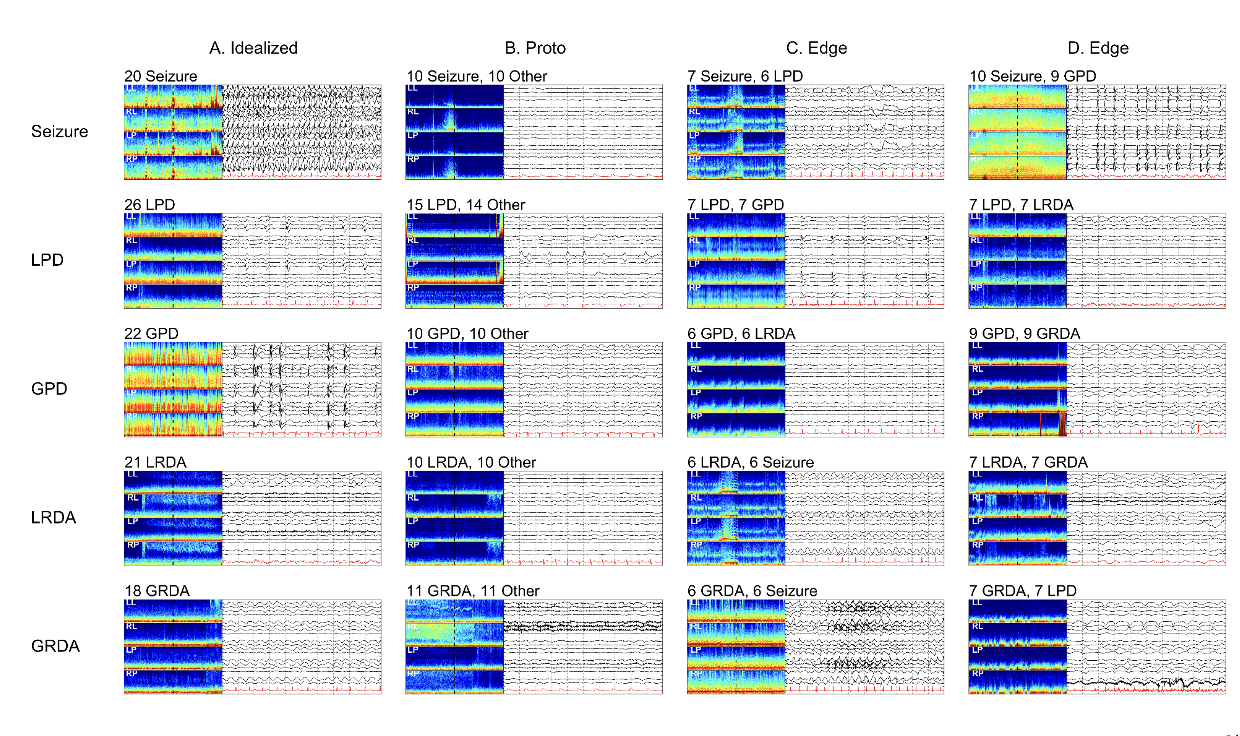

## Evaluation Metric
Kullback Liebler Divergence: Measures the divergence between predicted probabilities and observed targets. Predictions must sum to one for each `eeg_id`.


## Dataset Description
- **EEG Data**: Contains EEG recordings from patients, sampled at 200 samples per second.
- **Spectrograms**: Visual representations of the EEG data.
- **Metadata**: Information about EEG recordings, spectrograms, and patient details.
- **Annotator Votes**: Counts of votes for each brain activity class by experts.

## EGGs (waveforms) vs Spectrograms (images)
- EEGs directly measure the electrical activity of the brain through electrodes placed on the scalp. Offers more detailed and raw temporal data about brain activity
- Spectrograms are visual representations of the spectrum of frequencies of the EEG signal as they vary over time. Offers a time-frequency representation, capturing both the frequency content and how it changes over time.


## Submission Requirements
Participants must predict probabilities for each of the six brain activity patterns for each EEG segment in the test set. The submission format includes `eeg_id` followed by predicted probabilities for each pattern.

***Your total predicted probabilities for each row must sum to one or your submission will fail.***

# Import Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import random

import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import pad
import tqdm

# Exploratory Data Analysis (EDA)

## Data Collection

In [2]:
# !kaggle competitions download -c hms-harmful-brain-activity-classification
# !kaggle datasets download -d cdeotte/brain-spectrograms

In [3]:
# !tar -xf hms-harmful-brain-activity-classification.zip
# !tar -xf brain-spectrograms.zip

In [4]:
# root_path1 = "/kaggle/input/hms-harmful-brain-activity-classification/"
# root_path2 = "/kaggle/input/brain-spectrograms/"

root_path1 = ""
root_path2 = ""

train_df = pd.read_csv(root_path1 + 'train.csv')
test_df = pd.read_csv(root_path1 + 'test.csv')
train_df.shape, test_df.shape

((106800, 15), (1, 3))

In [5]:
train_df.sample(5)

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
102526   338172747           5                      20.0      2055294207   
8900    1335890931           0                       0.0       167668140   
28744   1889032491          53                     128.0       556125255   
101276  3499599476           2                       6.0      2029481152   
101019  3644306667           1                       2.0      2022364566   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
102526                   5                              20.0  3009432395   
8900                     8                             172.0   747965241   
28744                   53                             128.0  3750619021   
101276                   2                               6.0  1309020294   
101019                   1                               2.0  3580075172   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
102526       11966              LPD             0        12         0   
8900         57167          Seizure             3         0         0   
28744        16541             LRDA             0         0         0   
101276       29441              LPD             0         3         1   
101019        3838             GRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  
102526          0          0           2  
8900            0          0           0  
28744           3          0           0  
101276          0          0           0  
101019          0          3           2

Original Spectrograms (Won't use it)

In [6]:
pd.read_parquet(root_path1 + "train_spectrograms/1000086677.parquet").head()

time    LL_0.59    LL_0.78    LL_0.98    LL_1.17    LL_1.37    LL_1.56  \
0     1  28.680000  53.990002  67.629997  59.880001  50.880001  74.309998   
1     3  29.639999  38.959999  44.009998  66.800003  48.509998  42.180000   
2     5   8.890000   9.020000  16.360001  23.559999  27.340000  30.040001   
3     7   1.770000   1.930000   1.810000   1.600000   1.430000   1.280000   
4     9        NaN        NaN        NaN        NaN        NaN        NaN   

     LL_1.76    LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  \
0  78.480003  63.080002  59.869999  ...      0.13      0.14      0.08   
1  47.340000  48.599998  40.880001  ...      0.15      0.13      0.08   
2  27.559999  23.290001  15.120000  ...      0.12      0.11      0.08   
3   1.190000   1.110000   1.010000  ...      0.03      0.03      0.03   
4        NaN        NaN        NaN  ...       NaN       NaN       NaN   

   RP_18.75  RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0      0.11      0.04      0.03      0.05      0.05      0.04      0.05  
1      0.08      0.07      0.06      0.07      0.06      0.06      0.06  
2      0.08      0.09      0.10      0.12      0.14      0.13      0.14  
3      0.03      0.03      0.03      0.03      0.04      0.04      0.04  
4       NaN       NaN       NaN       NaN       NaN       NaN       NaN  

[5 rows x 401 columns]

Thanks to Chris Deotte for simplifying the dataset, here is the link:
https://www.kaggle.com/datasets/cdeotte/brain-spectrograms, 

He also provided how to use the data using Tensorflow, But since I prefer PyToch lets modify it a bit.

In [7]:
spectrograms = np.load(root_path2+ 'specs.npy',allow_pickle=True).item()
len(spectrograms)

11138

In [8]:
for i in spectrograms.items():
    print(i)
    break

(319287046, array([[16.72, 24.51, 36.19, ...,  0.1 ,  0.34,  0.35],
       [16.65, 19.84, 18.75, ...,  0.13,  0.46,  0.42],
       [ 8.47,  8.57, 11.68, ...,  0.12,  0.4 ,  0.38],
       ...,
       [43.94, 34.39, 36.66, ...,  0.31,  0.63,  0.52],
       [53.59, 73.56, 64.55, ...,  0.23,  0.47,  0.57],
       [54.76, 80.39, 76.  , ...,  0.49,  0.89,  0.81]], dtype=float32))


## Understanding the Data

<Axes: xlabel='expert_consensus', ylabel='Count'>

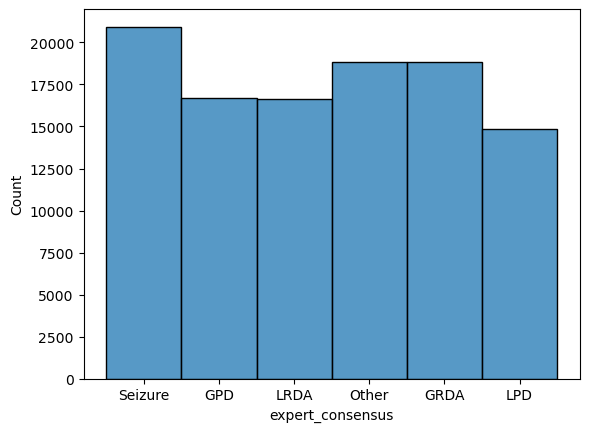

In [9]:
sns.histplot(train_df["expert_consensus"])

The classes are pretty much balanced. Good.

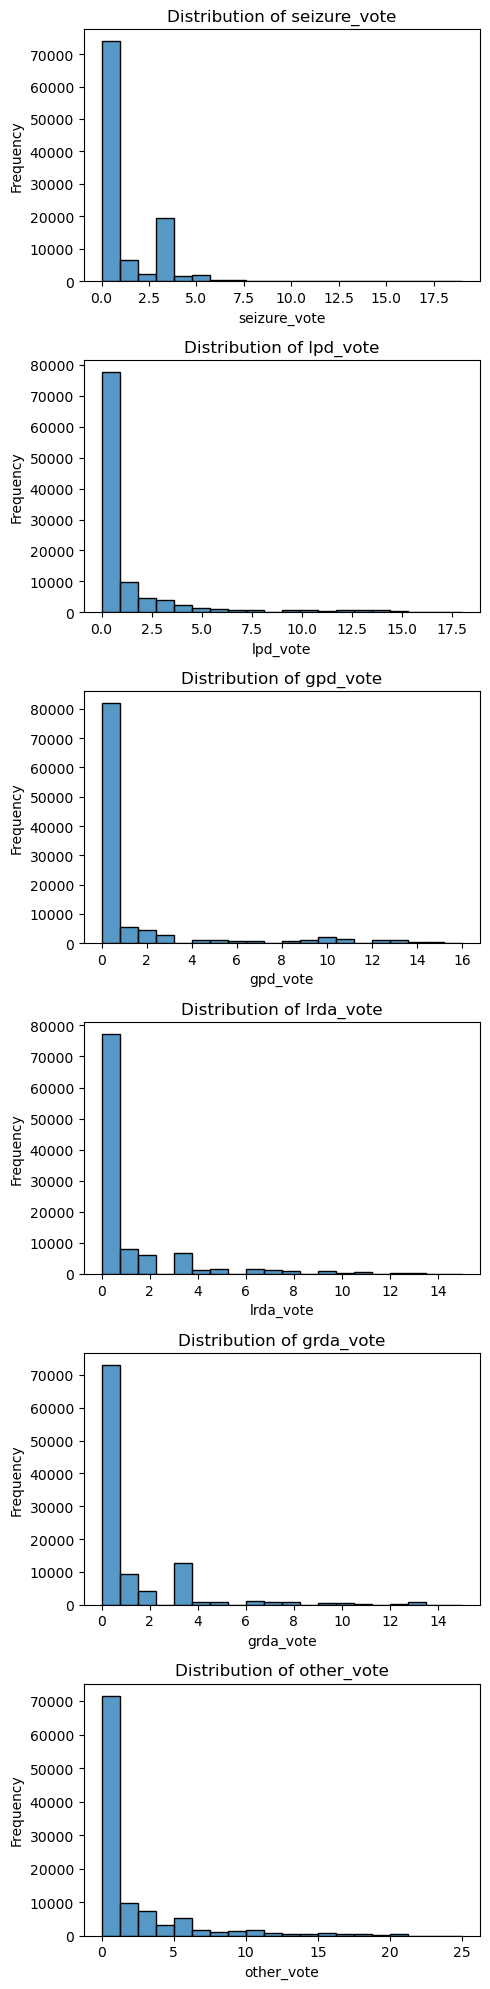

In [10]:
columns_to_plot = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(5, 20))

for i, col in enumerate(columns_to_plot):
    sns.histplot(train_df[col], bins=20, kde=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
def plot_spectrogram(eeg_id, spectrogram):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f'Spectrogram for EEG ID: {eeg_id}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()


# Data Preprocessing

## Create Non-Overlapping Eeg Id Train Data
Credit: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67

In [12]:
TARGETS = train_df.columns[-6:]
train = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = train_df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = train_df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = train_df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


eeg_id     spec_id     min     max  patient_id  seizure_vote  lpd_vote  \
0  568657   789577333     0.0    16.0       20654           0.0  0.000000   
1  582999  1552638400     0.0    38.0       20230           0.0  0.857143   
2  642382    14960202  1008.0  1032.0        5955           0.0  0.000000   
3  751790   618728447   908.0   908.0       38549           0.0  0.000000   
4  778705    52296320     0.0     0.0       40955           0.0  0.000000   

   gpd_vote  lrda_vote  grda_vote  other_vote target  
0      0.25   0.000000   0.166667    0.583333  Other  
1      0.00   0.071429   0.000000    0.071429    LPD  
2      0.00   0.000000   0.000000    1.000000  Other  
3      1.00   0.000000   0.000000    0.000000    GPD  
4      0.00   0.000000   0.000000    1.000000  Other

## Feature Engineer

In [13]:
SPEC_COLS = pd.read_parquet(f'{root_path1}train_spectrograms/1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

We are creating 1600 features for 17089 rows... 

In [14]:
def feature_engineer(df):
    data = np.zeros((len(df),len(FEATURES)))
    for k in range(len(df)):

        row = train.iloc[k]
        r = int( (row['min'] + row['max'])//4 ) 
    
        # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,:400] = x
        x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,400:800] = x
    
        # 20 SECOND WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,800:1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,1200:1600] = x

    return pd.DataFrame(data, columns=FEATURES)


In [15]:
train = pd.concat([train, feature_engineer(train)], axis=1)
train.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_3296\1639125574.py:15: RuntimeWarning: Mean of empty slice
  x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
C:\Users\USER\AppData\Local\Temp\ipykernel_3296\1639125574.py:17: RuntimeWarning: All-NaN slice encountered
  x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)


eeg_id     spec_id     min     max  patient_id  seizure_vote  lpd_vote  \
0  568657   789577333     0.0    16.0       20654           0.0  0.000000   
1  582999  1552638400     0.0    38.0       20230           0.0  0.857143   
2  642382    14960202  1008.0  1032.0        5955           0.0  0.000000   
3  751790   618728447   908.0   908.0       38549           0.0  0.000000   
4  778705    52296320     0.0     0.0       40955           0.0  0.000000   

   gpd_vote  lrda_vote  grda_vote  ...  RP_18.16_min_20s RP_18.36_min_20s  \
0      0.25   0.000000   0.166667  ...              0.20             0.19   
1      0.00   0.071429   0.000000  ...              0.02             0.02   
2      0.00   0.000000   0.000000  ...              0.05             0.04   
3      1.00   0.000000   0.000000  ...              0.06             0.05   
4      0.00   0.000000   0.000000  ...              0.15             0.15   

   RP_18.55_min_20s  RP_18.75_min_20s  RP_18.95_min_20s  RP_19.14_min_20s  \
0              0.17              0.16              0.25              0.21   
1              0.02              0.02              0.02              0.02   
2              0.07              0.05              0.04              0.06   
3              0.05              0.06              0.06              0.06   
4              0.13              0.13              0.08              0.06   

   RP_19.34_min_20s  RP_19.53_min_20s  RP_19.73_min_20s  RP_19.92_min_20s  
0              0.17              0.19              0.15              0.13  
1              0.03              0.02              0.02              0.02  
2              0.03              0.06              0.05              0.05  
3              0.07              0.05              0.05              0.03  
4              0.06              0.12              0.09              0.04  

[5 rows x 1612 columns]

In [16]:
train.isna().sum()

eeg_id               0
spec_id              0
min                  0
max                  0
patient_id           0
                    ..
RP_19.14_min_20s    18
RP_19.34_min_20s    18
RP_19.53_min_20s    18
RP_19.73_min_20s    18
RP_19.92_min_20s    18
Length: 1612, dtype: int64

Simple imputer

The rest is handled by the Chris's dataset

# Model Training

In [17]:
def kullback_leibler_divergence(true_labels, predictions):
    """
    Calculate the Kullback-Leibler Divergence.
    true_labels: Array of true labels.
    predictions: Array of predicted probabilities.
    """
    # One-hot encode the true labels
    n_classes = predictions.shape[1]
    one_hot_true = np.eye(n_classes)[true_labels]

    # Clip predictions to avoid log(0)
    epsilon = 1e-15
    predictions_clipped = np.clip(predictions, epsilon, 1 - epsilon)

    # Calculate KLD using valid entries only
    with np.errstate(divide='ignore', invalid='ignore'):
        log_term = np.log(one_hot_true / predictions_clipped)
        log_term[~np.isfinite(log_term)] = 0  # Replace -inf, inf, and NaN with 0
        kld = np.sum(one_hot_true * log_term, axis=1)
    return np.mean(kld)


## XGboost

In [18]:
import xgboost as xgb
import gc
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GroupKFold
import optuna
print('XGBoost version', xgb.__version__)

XGBoost version 2.0.3


In [19]:
def Xgb_objective(trial):
    trail_all_oof = []
    all_true = []
    TARS = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
    gkf = GroupKFold(n_splits=5)
    gkf_split = gkf.split(train, train.target, train.patient_id)

    for i, (train_index, valid_index) in enumerate(gkf_split):
        X_train = train.loc[train_index, FEATURES]
        y_train = train.loc[train_index, 'target'].map(TARS)
        X_valid = train.loc[valid_index, FEATURES]
        y_valid = train.loc[valid_index, 'target'].map(TARS)

        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'tree_method': 'hist',
            'device': 'cuda',
            'num_class': len(TARS),
            'objective': 'multi:softprob',
            'random_state': 42
        }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        model = xgb.train(params, dtrain, evals=[(dvalid, 'eval')], early_stopping_rounds=50)
        oof = model.predict(dvalid)
        trail_all_oof.append(oof)
        all_true.append(y_valid)
    
    trail_all_oof = np.concatenate(trail_all_oof)
    all_true = np.concatenate(all_true)
    return kullback_leibler_divergence(all_true, trail_all_oof)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(Xgb_objective, n_trials=50)
print('Best hyperparameters:', xgb_study.best_params)


[I 2024-01-31 21:20:41,734] A new study created in memory with name: no-name-ac021ba3-0902-4dcd-98cd-51e72b000735


[0]	eval-mlogloss:1.74368
[1]	eval-mlogloss:1.70028
[2]	eval-mlogloss:1.65962
[3]	eval-mlogloss:1.62573
[4]	eval-mlogloss:1.59474
[5]	eval-mlogloss:1.56460
[6]	eval-mlogloss:1.53789
[7]	eval-mlogloss:1.51427
[8]	eval-mlogloss:1.48912
[9]	eval-mlogloss:1.46803
[0]	eval-mlogloss:1.74468
[1]	eval-mlogloss:1.70320
[2]	eval-mlogloss:1.66384
[3]	eval-mlogloss:1.62795
[4]	eval-mlogloss:1.59790
[5]	eval-mlogloss:1.56870
[6]	eval-mlogloss:1.54175
[7]	eval-mlogloss:1.51630
[8]	eval-mlogloss:1.49358
[9]	eval-mlogloss:1.47290
[0]	eval-mlogloss:1.73842
[1]	eval-mlogloss:1.69111
[2]	eval-mlogloss:1.64895
[3]	eval-mlogloss:1.61097
[4]	eval-mlogloss:1.57525
[5]	eval-mlogloss:1.54232
[6]	eval-mlogloss:1.51224
[7]	eval-mlogloss:1.48413
[8]	eval-mlogloss:1.45715
[9]	eval-mlogloss:1.43266
[0]	eval-mlogloss:1.74258
[1]	eval-mlogloss:1.69859
[2]	eval-mlogloss:1.65898
[3]	eval-mlogloss:1.62309
[4]	eval-mlogloss:1.59039
[5]	eval-mlogloss:1.55871
[6]	eval-mlogloss:1.53115
[7]	eval-mlogloss:1.50614
[8]	eval-mlo

[I 2024-01-31 21:21:33,762] Trial 0 finished with value: 1.460600970365635 and parameters: {'max_depth': 10, 'learning_rate': 0.058752727079210004, 'subsample': 0.7728585083918115, 'colsample_bytree': 0.7917030346375162}. Best is trial 0 with value: 1.460600970365635.


[0]	eval-mlogloss:1.78083
[1]	eval-mlogloss:1.77014
[2]	eval-mlogloss:1.75962
[3]	eval-mlogloss:1.74989
[4]	eval-mlogloss:1.73998
[5]	eval-mlogloss:1.73000
[6]	eval-mlogloss:1.72053
[7]	eval-mlogloss:1.71119
[8]	eval-mlogloss:1.70215
[9]	eval-mlogloss:1.69331
[0]	eval-mlogloss:1.78047
[1]	eval-mlogloss:1.76984
[2]	eval-mlogloss:1.75977
[3]	eval-mlogloss:1.75001
[4]	eval-mlogloss:1.74024
[5]	eval-mlogloss:1.73062
[6]	eval-mlogloss:1.72126
[7]	eval-mlogloss:1.71189
[8]	eval-mlogloss:1.70300
[9]	eval-mlogloss:1.69398
[0]	eval-mlogloss:1.78008
[1]	eval-mlogloss:1.76862
[2]	eval-mlogloss:1.75701
[3]	eval-mlogloss:1.74601
[4]	eval-mlogloss:1.73503
[5]	eval-mlogloss:1.72481
[6]	eval-mlogloss:1.71450
[7]	eval-mlogloss:1.70432
[8]	eval-mlogloss:1.69438
[9]	eval-mlogloss:1.68493
[0]	eval-mlogloss:1.78066
[1]	eval-mlogloss:1.77031
[2]	eval-mlogloss:1.75995
[3]	eval-mlogloss:1.75009
[4]	eval-mlogloss:1.74043
[5]	eval-mlogloss:1.73086
[6]	eval-mlogloss:1.72096
[7]	eval-mlogloss:1.71150
[8]	eval-mlo

[I 2024-01-31 21:21:56,249] Trial 1 finished with value: 1.6916807758383277 and parameters: {'max_depth': 7, 'learning_rate': 0.013462155519233769, 'subsample': 0.9973714033430263, 'colsample_bytree': 0.849772502387909}. Best is trial 1 with value: 1.6916807758383277.


[0]	eval-mlogloss:1.63752
[1]	eval-mlogloss:1.53369
[2]	eval-mlogloss:1.45692
[3]	eval-mlogloss:1.39268
[4]	eval-mlogloss:1.35027
[5]	eval-mlogloss:1.31445
[6]	eval-mlogloss:1.28231
[7]	eval-mlogloss:1.26142
[8]	eval-mlogloss:1.23956
[9]	eval-mlogloss:1.22136
[0]	eval-mlogloss:1.64068
[1]	eval-mlogloss:1.54027
[2]	eval-mlogloss:1.46944
[3]	eval-mlogloss:1.41292
[4]	eval-mlogloss:1.37058
[5]	eval-mlogloss:1.33213
[6]	eval-mlogloss:1.30066
[7]	eval-mlogloss:1.27776
[8]	eval-mlogloss:1.25797
[9]	eval-mlogloss:1.24143
[0]	eval-mlogloss:1.63190
[1]	eval-mlogloss:1.51937
[2]	eval-mlogloss:1.43467
[3]	eval-mlogloss:1.36965
[4]	eval-mlogloss:1.32194
[5]	eval-mlogloss:1.28017
[6]	eval-mlogloss:1.24669
[7]	eval-mlogloss:1.21826
[8]	eval-mlogloss:1.19288
[9]	eval-mlogloss:1.17204
[0]	eval-mlogloss:1.64281
[1]	eval-mlogloss:1.53834
[2]	eval-mlogloss:1.45682
[3]	eval-mlogloss:1.39305
[4]	eval-mlogloss:1.34367
[5]	eval-mlogloss:1.29966
[6]	eval-mlogloss:1.26866
[7]	eval-mlogloss:1.24180
[8]	eval-mlo

[I 2024-01-31 21:22:21,571] Trial 2 finished with value: 1.2133433447360773 and parameters: {'max_depth': 7, 'learning_rate': 0.19781642264515711, 'subsample': 0.9163686932453339, 'colsample_bytree': 0.9623538273319885}. Best is trial 1 with value: 1.6916807758383277.


[0]	eval-mlogloss:1.75053
[1]	eval-mlogloss:1.71492
[2]	eval-mlogloss:1.68247
[3]	eval-mlogloss:1.65126
[4]	eval-mlogloss:1.62481
[5]	eval-mlogloss:1.60094
[6]	eval-mlogloss:1.57877
[7]	eval-mlogloss:1.55724
[8]	eval-mlogloss:1.53687
[9]	eval-mlogloss:1.51746
[0]	eval-mlogloss:1.74950
[1]	eval-mlogloss:1.71204
[2]	eval-mlogloss:1.67787
[3]	eval-mlogloss:1.64786
[4]	eval-mlogloss:1.61935
[5]	eval-mlogloss:1.59365
[6]	eval-mlogloss:1.57097
[7]	eval-mlogloss:1.54920
[8]	eval-mlogloss:1.52849
[9]	eval-mlogloss:1.50847
[0]	eval-mlogloss:1.74969
[1]	eval-mlogloss:1.71014
[2]	eval-mlogloss:1.67585
[3]	eval-mlogloss:1.64512
[4]	eval-mlogloss:1.61683
[5]	eval-mlogloss:1.58973
[6]	eval-mlogloss:1.56617
[7]	eval-mlogloss:1.54326
[8]	eval-mlogloss:1.52169
[9]	eval-mlogloss:1.50125
[0]	eval-mlogloss:1.75365
[1]	eval-mlogloss:1.71666
[2]	eval-mlogloss:1.68535
[3]	eval-mlogloss:1.65641
[4]	eval-mlogloss:1.62826
[5]	eval-mlogloss:1.60392
[6]	eval-mlogloss:1.58110
[7]	eval-mlogloss:1.56026
[8]	eval-mlo

[I 2024-01-31 21:22:32,675] Trial 3 finished with value: 1.5116256315364967 and parameters: {'max_depth': 4, 'learning_rate': 0.058411156402314174, 'subsample': 0.9090961179990081, 'colsample_bytree': 0.840480175472639}. Best is trial 1 with value: 1.6916807758383277.


[0]	eval-mlogloss:1.69629
[1]	eval-mlogloss:1.62486
[2]	eval-mlogloss:1.55927
[3]	eval-mlogloss:1.50759
[4]	eval-mlogloss:1.46449
[5]	eval-mlogloss:1.42654
[6]	eval-mlogloss:1.39200
[7]	eval-mlogloss:1.36401
[8]	eval-mlogloss:1.33690
[9]	eval-mlogloss:1.31747
[0]	eval-mlogloss:1.69223
[1]	eval-mlogloss:1.61693
[2]	eval-mlogloss:1.55728
[3]	eval-mlogloss:1.50680
[4]	eval-mlogloss:1.46473
[5]	eval-mlogloss:1.42836
[6]	eval-mlogloss:1.39541
[7]	eval-mlogloss:1.37002
[8]	eval-mlogloss:1.34521
[9]	eval-mlogloss:1.32769
[0]	eval-mlogloss:1.68864
[1]	eval-mlogloss:1.60968
[2]	eval-mlogloss:1.54533
[3]	eval-mlogloss:1.49193
[4]	eval-mlogloss:1.44711
[5]	eval-mlogloss:1.40673
[6]	eval-mlogloss:1.37292
[7]	eval-mlogloss:1.34083
[8]	eval-mlogloss:1.31288
[9]	eval-mlogloss:1.28957
[0]	eval-mlogloss:1.69461
[1]	eval-mlogloss:1.62209
[2]	eval-mlogloss:1.56149
[3]	eval-mlogloss:1.51435
[4]	eval-mlogloss:1.47005
[5]	eval-mlogloss:1.43165
[6]	eval-mlogloss:1.40289
[7]	eval-mlogloss:1.37339
[8]	eval-mlo

[I 2024-01-31 21:22:46,271] Trial 4 finished with value: 1.3127190602375785 and parameters: {'max_depth': 5, 'learning_rate': 0.1324613652525686, 'subsample': 0.6764921950064726, 'colsample_bytree': 0.5295280717492978}. Best is trial 1 with value: 1.6916807758383277.


[0]	eval-mlogloss:1.64547
[1]	eval-mlogloss:1.54244
[2]	eval-mlogloss:1.46324
[3]	eval-mlogloss:1.41047
[4]	eval-mlogloss:1.36108
[5]	eval-mlogloss:1.32214
[6]	eval-mlogloss:1.28445
[7]	eval-mlogloss:1.25924
[8]	eval-mlogloss:1.23804
[9]	eval-mlogloss:1.21696
[0]	eval-mlogloss:1.63846
[1]	eval-mlogloss:1.54020
[2]	eval-mlogloss:1.46014
[3]	eval-mlogloss:1.40271
[4]	eval-mlogloss:1.35533
[5]	eval-mlogloss:1.31817
[6]	eval-mlogloss:1.28891
[7]	eval-mlogloss:1.26567
[8]	eval-mlogloss:1.24419
[9]	eval-mlogloss:1.22995
[0]	eval-mlogloss:1.62763
[1]	eval-mlogloss:1.51219
[2]	eval-mlogloss:1.43339
[3]	eval-mlogloss:1.36903
[4]	eval-mlogloss:1.31938
[5]	eval-mlogloss:1.27448
[6]	eval-mlogloss:1.24314
[7]	eval-mlogloss:1.21254
[8]	eval-mlogloss:1.19019
[9]	eval-mlogloss:1.16825
[0]	eval-mlogloss:1.64188
[1]	eval-mlogloss:1.53626
[2]	eval-mlogloss:1.46113
[3]	eval-mlogloss:1.40462
[4]	eval-mlogloss:1.35118
[5]	eval-mlogloss:1.31195
[6]	eval-mlogloss:1.27715
[7]	eval-mlogloss:1.25313
[8]	eval-mlo

[I 2024-01-31 21:23:12,962] Trial 5 finished with value: 1.208795628517779 and parameters: {'max_depth': 7, 'learning_rate': 0.20078140065351108, 'subsample': 0.841558908824807, 'colsample_bytree': 0.7942411956442623}. Best is trial 1 with value: 1.6916807758383277.


[0]	eval-mlogloss:1.73461
[1]	eval-mlogloss:1.68909
[2]	eval-mlogloss:1.64593
[3]	eval-mlogloss:1.60851
[4]	eval-mlogloss:1.57553
[5]	eval-mlogloss:1.54641
[6]	eval-mlogloss:1.51700
[7]	eval-mlogloss:1.49226
[8]	eval-mlogloss:1.46914
[9]	eval-mlogloss:1.44782
[0]	eval-mlogloss:1.73273
[1]	eval-mlogloss:1.68398
[2]	eval-mlogloss:1.63918
[3]	eval-mlogloss:1.60125
[4]	eval-mlogloss:1.56691
[5]	eval-mlogloss:1.53751
[6]	eval-mlogloss:1.51042
[7]	eval-mlogloss:1.48537
[8]	eval-mlogloss:1.46440
[9]	eval-mlogloss:1.44543
[0]	eval-mlogloss:1.73443
[1]	eval-mlogloss:1.68552
[2]	eval-mlogloss:1.64114
[3]	eval-mlogloss:1.60308
[4]	eval-mlogloss:1.56861
[5]	eval-mlogloss:1.53712
[6]	eval-mlogloss:1.50888
[7]	eval-mlogloss:1.48336
[8]	eval-mlogloss:1.45762
[9]	eval-mlogloss:1.43486
[0]	eval-mlogloss:1.73768
[1]	eval-mlogloss:1.69206
[2]	eval-mlogloss:1.65053
[3]	eval-mlogloss:1.61491
[4]	eval-mlogloss:1.58302
[5]	eval-mlogloss:1.55462
[6]	eval-mlogloss:1.52557
[7]	eval-mlogloss:1.49905
[8]	eval-mlo

[I 2024-01-31 21:23:24,626] Trial 6 finished with value: 1.4429254570732182 and parameters: {'max_depth': 4, 'learning_rate': 0.08190790508943036, 'subsample': 0.5329663065670751, 'colsample_bytree': 0.5954604662414631}. Best is trial 1 with value: 1.6916807758383277.


[0]	eval-mlogloss:1.78183
[1]	eval-mlogloss:1.77269
[2]	eval-mlogloss:1.76329
[3]	eval-mlogloss:1.75456
[4]	eval-mlogloss:1.74618
[5]	eval-mlogloss:1.73760
[6]	eval-mlogloss:1.72949
[7]	eval-mlogloss:1.72123
[8]	eval-mlogloss:1.71373
[9]	eval-mlogloss:1.70654
[0]	eval-mlogloss:1.78189
[1]	eval-mlogloss:1.77263
[2]	eval-mlogloss:1.76320
[3]	eval-mlogloss:1.75424
[4]	eval-mlogloss:1.74538
[5]	eval-mlogloss:1.73654
[6]	eval-mlogloss:1.72822
[7]	eval-mlogloss:1.71980
[8]	eval-mlogloss:1.71165
[9]	eval-mlogloss:1.70375
[0]	eval-mlogloss:1.78195
[1]	eval-mlogloss:1.77201
[2]	eval-mlogloss:1.76264
[3]	eval-mlogloss:1.75333
[4]	eval-mlogloss:1.74421
[5]	eval-mlogloss:1.73540
[6]	eval-mlogloss:1.72712
[7]	eval-mlogloss:1.71893
[8]	eval-mlogloss:1.71048
[9]	eval-mlogloss:1.70193
[0]	eval-mlogloss:1.78228
[1]	eval-mlogloss:1.77350
[2]	eval-mlogloss:1.76454
[3]	eval-mlogloss:1.75643
[4]	eval-mlogloss:1.74812
[5]	eval-mlogloss:1.74004
[6]	eval-mlogloss:1.73160
[7]	eval-mlogloss:1.72381
[8]	eval-mlo

[I 2024-01-31 21:23:35,981] Trial 7 finished with value: 1.70419891674522 and parameters: {'max_depth': 4, 'learning_rate': 0.013637908185512032, 'subsample': 0.7434946733878458, 'colsample_bytree': 0.6024679950462672}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.77910
[1]	eval-mlogloss:1.76690
[2]	eval-mlogloss:1.75563
[3]	eval-mlogloss:1.74378
[4]	eval-mlogloss:1.73266
[5]	eval-mlogloss:1.72205
[6]	eval-mlogloss:1.71117
[7]	eval-mlogloss:1.70095
[8]	eval-mlogloss:1.69137
[9]	eval-mlogloss:1.68141
[0]	eval-mlogloss:1.77918
[1]	eval-mlogloss:1.76778
[2]	eval-mlogloss:1.75656
[3]	eval-mlogloss:1.74528
[4]	eval-mlogloss:1.73444
[5]	eval-mlogloss:1.72387
[6]	eval-mlogloss:1.71415
[7]	eval-mlogloss:1.70423
[8]	eval-mlogloss:1.69426
[9]	eval-mlogloss:1.68487
[0]	eval-mlogloss:1.77787
[1]	eval-mlogloss:1.76410
[2]	eval-mlogloss:1.75142
[3]	eval-mlogloss:1.73913
[4]	eval-mlogloss:1.72727
[5]	eval-mlogloss:1.71593
[6]	eval-mlogloss:1.70417
[7]	eval-mlogloss:1.69284
[8]	eval-mlogloss:1.68169
[9]	eval-mlogloss:1.67102
[0]	eval-mlogloss:1.77931
[1]	eval-mlogloss:1.76607
[2]	eval-mlogloss:1.75416
[3]	eval-mlogloss:1.74214
[4]	eval-mlogloss:1.73098
[5]	eval-mlogloss:1.72013
[6]	eval-mlogloss:1.70928
[7]	eval-mlogloss:1.69832
[8]	eval-mlo

[I 2024-01-31 21:24:40,327] Trial 8 finished with value: 1.679749270664456 and parameters: {'max_depth': 10, 'learning_rate': 0.014364540630759037, 'subsample': 0.9260993361514218, 'colsample_bytree': 0.7812918519845629}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.59501
[1]	eval-mlogloss:1.47865
[2]	eval-mlogloss:1.39848
[3]	eval-mlogloss:1.33914
[4]	eval-mlogloss:1.29443
[5]	eval-mlogloss:1.26251
[6]	eval-mlogloss:1.23765
[7]	eval-mlogloss:1.21569
[8]	eval-mlogloss:1.19939
[9]	eval-mlogloss:1.18476
[0]	eval-mlogloss:1.60285
[1]	eval-mlogloss:1.49490
[2]	eval-mlogloss:1.41683
[3]	eval-mlogloss:1.35999
[4]	eval-mlogloss:1.31618
[5]	eval-mlogloss:1.28438
[6]	eval-mlogloss:1.25904
[7]	eval-mlogloss:1.23979
[8]	eval-mlogloss:1.22318
[9]	eval-mlogloss:1.20844
[0]	eval-mlogloss:1.58758
[1]	eval-mlogloss:1.46143
[2]	eval-mlogloss:1.37670
[3]	eval-mlogloss:1.31560
[4]	eval-mlogloss:1.26444
[5]	eval-mlogloss:1.22241
[6]	eval-mlogloss:1.18994
[7]	eval-mlogloss:1.16287
[8]	eval-mlogloss:1.14450
[9]	eval-mlogloss:1.12678
[0]	eval-mlogloss:1.60451
[1]	eval-mlogloss:1.48083
[2]	eval-mlogloss:1.39972
[3]	eval-mlogloss:1.34016
[4]	eval-mlogloss:1.28853
[5]	eval-mlogloss:1.25123
[6]	eval-mlogloss:1.22448
[7]	eval-mlogloss:1.20303
[8]	eval-mlo

[I 2024-01-31 21:25:17,819] Trial 9 finished with value: 1.179905771291647 and parameters: {'max_depth': 8, 'learning_rate': 0.2566952435517939, 'subsample': 0.9909073991708779, 'colsample_bytree': 0.7999985591376213}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.62898
[1]	eval-mlogloss:1.52292
[2]	eval-mlogloss:1.45363
[3]	eval-mlogloss:1.40146
[4]	eval-mlogloss:1.36867
[5]	eval-mlogloss:1.33712
[6]	eval-mlogloss:1.31190
[7]	eval-mlogloss:1.29278
[8]	eval-mlogloss:1.27642
[9]	eval-mlogloss:1.26080
[0]	eval-mlogloss:1.61739
[1]	eval-mlogloss:1.52006
[2]	eval-mlogloss:1.45068
[3]	eval-mlogloss:1.41053
[4]	eval-mlogloss:1.37517
[5]	eval-mlogloss:1.34375
[6]	eval-mlogloss:1.32274
[7]	eval-mlogloss:1.30797
[8]	eval-mlogloss:1.29605
[9]	eval-mlogloss:1.28221
[0]	eval-mlogloss:1.61849
[1]	eval-mlogloss:1.51331
[2]	eval-mlogloss:1.43903
[3]	eval-mlogloss:1.38905
[4]	eval-mlogloss:1.34535
[5]	eval-mlogloss:1.31051
[6]	eval-mlogloss:1.28513
[7]	eval-mlogloss:1.26476
[8]	eval-mlogloss:1.24829
[9]	eval-mlogloss:1.22839
[0]	eval-mlogloss:1.62859
[1]	eval-mlogloss:1.53092
[2]	eval-mlogloss:1.46387
[3]	eval-mlogloss:1.41959
[4]	eval-mlogloss:1.37387
[5]	eval-mlogloss:1.34711
[6]	eval-mlogloss:1.31650
[7]	eval-mlogloss:1.29614
[8]	eval-mlo

[I 2024-01-31 21:25:28,125] Trial 10 finished with value: 1.2588033594812569 and parameters: {'max_depth': 3, 'learning_rate': 0.2929840255906228, 'subsample': 0.6512631191301664, 'colsample_bytree': 0.6497086470595779}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.78025
[1]	eval-mlogloss:1.76917
[2]	eval-mlogloss:1.75803
[3]	eval-mlogloss:1.74771
[4]	eval-mlogloss:1.73817
[5]	eval-mlogloss:1.72825
[6]	eval-mlogloss:1.71839
[7]	eval-mlogloss:1.70883
[8]	eval-mlogloss:1.69997
[9]	eval-mlogloss:1.69098
[0]	eval-mlogloss:1.78057
[1]	eval-mlogloss:1.76950
[2]	eval-mlogloss:1.75904
[3]	eval-mlogloss:1.74883
[4]	eval-mlogloss:1.73908
[5]	eval-mlogloss:1.72855
[6]	eval-mlogloss:1.71887
[7]	eval-mlogloss:1.70929
[8]	eval-mlogloss:1.69990
[9]	eval-mlogloss:1.69057
[0]	eval-mlogloss:1.77963
[1]	eval-mlogloss:1.76751
[2]	eval-mlogloss:1.75610
[3]	eval-mlogloss:1.74477
[4]	eval-mlogloss:1.73373
[5]	eval-mlogloss:1.72281
[6]	eval-mlogloss:1.71258
[7]	eval-mlogloss:1.70280
[8]	eval-mlogloss:1.69302
[9]	eval-mlogloss:1.68293
[0]	eval-mlogloss:1.78054
[1]	eval-mlogloss:1.76939
[2]	eval-mlogloss:1.75817
[3]	eval-mlogloss:1.74796
[4]	eval-mlogloss:1.73799
[5]	eval-mlogloss:1.72777
[6]	eval-mlogloss:1.71795
[7]	eval-mlogloss:1.70817
[8]	eval-mlo

[I 2024-01-31 21:25:48,444] Trial 11 finished with value: 1.6884627327517054 and parameters: {'max_depth': 6, 'learning_rate': 0.014275154237693155, 'subsample': 0.7534082876711709, 'colsample_bytree': 0.9267074963546407}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.69838
[1]	eval-mlogloss:1.62923
[2]	eval-mlogloss:1.56554
[3]	eval-mlogloss:1.51431
[4]	eval-mlogloss:1.47002
[5]	eval-mlogloss:1.43174
[6]	eval-mlogloss:1.39695
[7]	eval-mlogloss:1.36615
[8]	eval-mlogloss:1.33752
[9]	eval-mlogloss:1.31330
[0]	eval-mlogloss:1.70152
[1]	eval-mlogloss:1.63272
[2]	eval-mlogloss:1.57138
[3]	eval-mlogloss:1.52204
[4]	eval-mlogloss:1.47874
[5]	eval-mlogloss:1.44059
[6]	eval-mlogloss:1.40984
[7]	eval-mlogloss:1.38157
[8]	eval-mlogloss:1.35567
[9]	eval-mlogloss:1.33306
[0]	eval-mlogloss:1.69720
[1]	eval-mlogloss:1.61916
[2]	eval-mlogloss:1.55606
[3]	eval-mlogloss:1.50233
[4]	eval-mlogloss:1.45495
[5]	eval-mlogloss:1.41363
[6]	eval-mlogloss:1.37636
[7]	eval-mlogloss:1.34501
[8]	eval-mlogloss:1.31671
[9]	eval-mlogloss:1.29295
[0]	eval-mlogloss:1.69878
[1]	eval-mlogloss:1.62648
[2]	eval-mlogloss:1.56400
[3]	eval-mlogloss:1.51402
[4]	eval-mlogloss:1.46752
[5]	eval-mlogloss:1.43051
[6]	eval-mlogloss:1.39484
[7]	eval-mlogloss:1.36290
[8]	eval-mlo

[I 2024-01-31 21:26:21,016] Trial 12 finished with value: 1.3161100774071033 and parameters: {'max_depth': 8, 'learning_rate': 0.1121929331324235, 'subsample': 0.6453594496316262, 'colsample_bytree': 0.6902121505388454}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.78177
[1]	eval-mlogloss:1.77175
[2]	eval-mlogloss:1.76194
[3]	eval-mlogloss:1.75237
[4]	eval-mlogloss:1.74360
[5]	eval-mlogloss:1.73445
[6]	eval-mlogloss:1.72555
[7]	eval-mlogloss:1.71713
[8]	eval-mlogloss:1.70909
[9]	eval-mlogloss:1.70075
[0]	eval-mlogloss:1.78152
[1]	eval-mlogloss:1.77167
[2]	eval-mlogloss:1.76192
[3]	eval-mlogloss:1.75251
[4]	eval-mlogloss:1.74323
[5]	eval-mlogloss:1.73394
[6]	eval-mlogloss:1.72520
[7]	eval-mlogloss:1.71677
[8]	eval-mlogloss:1.70813
[9]	eval-mlogloss:1.69954
[0]	eval-mlogloss:1.78088
[1]	eval-mlogloss:1.77005
[2]	eval-mlogloss:1.76005
[3]	eval-mlogloss:1.75030
[4]	eval-mlogloss:1.74061
[5]	eval-mlogloss:1.73173
[6]	eval-mlogloss:1.72273
[7]	eval-mlogloss:1.71375
[8]	eval-mlogloss:1.70484
[9]	eval-mlogloss:1.69567
[0]	eval-mlogloss:1.78208
[1]	eval-mlogloss:1.77253
[2]	eval-mlogloss:1.76270
[3]	eval-mlogloss:1.75408
[4]	eval-mlogloss:1.74544
[5]	eval-mlogloss:1.73676
[6]	eval-mlogloss:1.72778
[7]	eval-mlogloss:1.71906
[8]	eval-mlo

[I 2024-01-31 21:26:33,825] Trial 13 finished with value: 1.6986401338499069 and parameters: {'max_depth': 5, 'learning_rate': 0.013434552659090234, 'subsample': 0.82028186722465, 'colsample_bytree': 0.5142843761064583}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.74363
[1]	eval-mlogloss:1.70170
[2]	eval-mlogloss:1.66351
[3]	eval-mlogloss:1.62935
[4]	eval-mlogloss:1.59758
[5]	eval-mlogloss:1.56874
[6]	eval-mlogloss:1.54344
[7]	eval-mlogloss:1.52117
[8]	eval-mlogloss:1.49986
[9]	eval-mlogloss:1.48095
[0]	eval-mlogloss:1.73905
[1]	eval-mlogloss:1.69292
[2]	eval-mlogloss:1.65311
[3]	eval-mlogloss:1.61911
[4]	eval-mlogloss:1.58882
[5]	eval-mlogloss:1.55899
[6]	eval-mlogloss:1.53468
[7]	eval-mlogloss:1.51178
[8]	eval-mlogloss:1.49164
[9]	eval-mlogloss:1.47118
[0]	eval-mlogloss:1.74030
[1]	eval-mlogloss:1.69418
[2]	eval-mlogloss:1.65443
[3]	eval-mlogloss:1.61985
[4]	eval-mlogloss:1.58942
[5]	eval-mlogloss:1.56087
[6]	eval-mlogloss:1.53587
[7]	eval-mlogloss:1.51176
[8]	eval-mlogloss:1.49149
[9]	eval-mlogloss:1.47210
[0]	eval-mlogloss:1.74014
[1]	eval-mlogloss:1.69754
[2]	eval-mlogloss:1.65941
[3]	eval-mlogloss:1.62747
[4]	eval-mlogloss:1.59655
[5]	eval-mlogloss:1.56864
[6]	eval-mlogloss:1.54497
[7]	eval-mlogloss:1.52369
[8]	eval-mlo

[I 2024-01-31 21:26:43,516] Trial 14 finished with value: 1.473185576688305 and parameters: {'max_depth': 3, 'learning_rate': 0.08100236245533869, 'subsample': 0.8231234613326854, 'colsample_bytree': 0.5102515976332885}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.66962
[1]	eval-mlogloss:1.58369
[2]	eval-mlogloss:1.51128
[3]	eval-mlogloss:1.45373
[4]	eval-mlogloss:1.41011
[5]	eval-mlogloss:1.37257
[6]	eval-mlogloss:1.33916
[7]	eval-mlogloss:1.31112
[8]	eval-mlogloss:1.28545
[9]	eval-mlogloss:1.26787
[0]	eval-mlogloss:1.66549
[1]	eval-mlogloss:1.57471
[2]	eval-mlogloss:1.50386
[3]	eval-mlogloss:1.45338
[4]	eval-mlogloss:1.41149
[5]	eval-mlogloss:1.37690
[6]	eval-mlogloss:1.34533
[7]	eval-mlogloss:1.32011
[8]	eval-mlogloss:1.30036
[9]	eval-mlogloss:1.28339
[0]	eval-mlogloss:1.66172
[1]	eval-mlogloss:1.56988
[2]	eval-mlogloss:1.49482
[3]	eval-mlogloss:1.43618
[4]	eval-mlogloss:1.38783
[5]	eval-mlogloss:1.34511
[6]	eval-mlogloss:1.31120
[7]	eval-mlogloss:1.27936
[8]	eval-mlogloss:1.25525
[9]	eval-mlogloss:1.23288
[0]	eval-mlogloss:1.66722
[1]	eval-mlogloss:1.57842
[2]	eval-mlogloss:1.50980
[3]	eval-mlogloss:1.46172
[4]	eval-mlogloss:1.41716
[5]	eval-mlogloss:1.37945
[6]	eval-mlogloss:1.34688
[7]	eval-mlogloss:1.31501
[8]	eval-mlo

[I 2024-01-31 21:26:56,973] Trial 15 finished with value: 1.2635512237733892 and parameters: {'max_depth': 5, 'learning_rate': 0.17713893539697054, 'subsample': 0.7024805424866757, 'colsample_bytree': 0.5798653976450814}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.75953
[1]	eval-mlogloss:1.73186
[2]	eval-mlogloss:1.70475
[3]	eval-mlogloss:1.67809
[4]	eval-mlogloss:1.65431
[5]	eval-mlogloss:1.63274
[6]	eval-mlogloss:1.61169
[7]	eval-mlogloss:1.59007
[8]	eval-mlogloss:1.57161
[9]	eval-mlogloss:1.55475
[0]	eval-mlogloss:1.75925
[1]	eval-mlogloss:1.73013
[2]	eval-mlogloss:1.70195
[3]	eval-mlogloss:1.67614
[4]	eval-mlogloss:1.65120
[5]	eval-mlogloss:1.62849
[6]	eval-mlogloss:1.60842
[7]	eval-mlogloss:1.58810
[8]	eval-mlogloss:1.57025
[9]	eval-mlogloss:1.55225
[0]	eval-mlogloss:1.75728
[1]	eval-mlogloss:1.72783
[2]	eval-mlogloss:1.70152
[3]	eval-mlogloss:1.67486
[4]	eval-mlogloss:1.64929
[5]	eval-mlogloss:1.62632
[6]	eval-mlogloss:1.60398
[7]	eval-mlogloss:1.58264
[8]	eval-mlogloss:1.56298
[9]	eval-mlogloss:1.54333
[0]	eval-mlogloss:1.76141
[1]	eval-mlogloss:1.73291
[2]	eval-mlogloss:1.70559
[3]	eval-mlogloss:1.68203
[4]	eval-mlogloss:1.65812
[5]	eval-mlogloss:1.63608
[6]	eval-mlogloss:1.61488
[7]	eval-mlogloss:1.59436
[8]	eval-mlo

[I 2024-01-31 21:27:10,725] Trial 16 finished with value: 1.5505943279037298 and parameters: {'max_depth': 5, 'learning_rate': 0.04238338071386796, 'subsample': 0.5384881725763444, 'colsample_bytree': 0.6725940875336465}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.71474
[1]	eval-mlogloss:1.65363
[2]	eval-mlogloss:1.60015
[3]	eval-mlogloss:1.55727
[4]	eval-mlogloss:1.51964
[5]	eval-mlogloss:1.48756
[6]	eval-mlogloss:1.45601
[7]	eval-mlogloss:1.43073
[8]	eval-mlogloss:1.40656
[9]	eval-mlogloss:1.38383
[0]	eval-mlogloss:1.71255
[1]	eval-mlogloss:1.64963
[2]	eval-mlogloss:1.59489
[3]	eval-mlogloss:1.54834
[4]	eval-mlogloss:1.50944
[5]	eval-mlogloss:1.47562
[6]	eval-mlogloss:1.44832
[7]	eval-mlogloss:1.42114
[8]	eval-mlogloss:1.39667
[9]	eval-mlogloss:1.37682
[0]	eval-mlogloss:1.70995
[1]	eval-mlogloss:1.64522
[2]	eval-mlogloss:1.59015
[3]	eval-mlogloss:1.54431
[4]	eval-mlogloss:1.50455
[5]	eval-mlogloss:1.46766
[6]	eval-mlogloss:1.43807
[7]	eval-mlogloss:1.40956
[8]	eval-mlogloss:1.38447
[9]	eval-mlogloss:1.36013
[0]	eval-mlogloss:1.71533
[1]	eval-mlogloss:1.65326
[2]	eval-mlogloss:1.60323
[3]	eval-mlogloss:1.56145
[4]	eval-mlogloss:1.52353
[5]	eval-mlogloss:1.49125
[6]	eval-mlogloss:1.46165
[7]	eval-mlogloss:1.43437
[8]	eval-mlo

[I 2024-01-31 21:27:21,976] Trial 17 finished with value: 1.3760008669005699 and parameters: {'max_depth': 4, 'learning_rate': 0.1142544237319954, 'subsample': 0.8279441206495814, 'colsample_bytree': 0.5879614926180785}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.68041
[1]	eval-mlogloss:1.59543
[2]	eval-mlogloss:1.52330
[3]	eval-mlogloss:1.46960
[4]	eval-mlogloss:1.42508
[5]	eval-mlogloss:1.38488
[6]	eval-mlogloss:1.34704
[7]	eval-mlogloss:1.31911
[8]	eval-mlogloss:1.29643
[9]	eval-mlogloss:1.27422
[0]	eval-mlogloss:1.67833
[1]	eval-mlogloss:1.59351
[2]	eval-mlogloss:1.52186
[3]	eval-mlogloss:1.46547
[4]	eval-mlogloss:1.42552
[5]	eval-mlogloss:1.38855
[6]	eval-mlogloss:1.35729
[7]	eval-mlogloss:1.32927
[8]	eval-mlogloss:1.30768
[9]	eval-mlogloss:1.28628
[0]	eval-mlogloss:1.66811
[1]	eval-mlogloss:1.58076
[2]	eval-mlogloss:1.51023
[3]	eval-mlogloss:1.45224
[4]	eval-mlogloss:1.40237
[5]	eval-mlogloss:1.35968
[6]	eval-mlogloss:1.32389
[7]	eval-mlogloss:1.29431
[8]	eval-mlogloss:1.26776
[9]	eval-mlogloss:1.24162
[0]	eval-mlogloss:1.67933
[1]	eval-mlogloss:1.58937
[2]	eval-mlogloss:1.52061
[3]	eval-mlogloss:1.46634
[4]	eval-mlogloss:1.41946
[5]	eval-mlogloss:1.38019
[6]	eval-mlogloss:1.34622
[7]	eval-mlogloss:1.31507
[8]	eval-mlo

[I 2024-01-31 21:27:38,935] Trial 18 finished with value: 1.2695269835670084 and parameters: {'max_depth': 6, 'learning_rate': 0.153464992223468, 'subsample': 0.5857363022988247, 'colsample_bytree': 0.5478905133801494}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.73906
[1]	eval-mlogloss:1.69382
[2]	eval-mlogloss:1.65380
[3]	eval-mlogloss:1.61894
[4]	eval-mlogloss:1.58781
[5]	eval-mlogloss:1.56000
[6]	eval-mlogloss:1.53415
[7]	eval-mlogloss:1.51220
[8]	eval-mlogloss:1.49110
[9]	eval-mlogloss:1.47148
[0]	eval-mlogloss:1.73302
[1]	eval-mlogloss:1.68664
[2]	eval-mlogloss:1.64654
[3]	eval-mlogloss:1.61136
[4]	eval-mlogloss:1.57893
[5]	eval-mlogloss:1.54993
[6]	eval-mlogloss:1.52480
[7]	eval-mlogloss:1.50053
[8]	eval-mlogloss:1.47804
[9]	eval-mlogloss:1.46022
[0]	eval-mlogloss:1.73638
[1]	eval-mlogloss:1.68773
[2]	eval-mlogloss:1.64707
[3]	eval-mlogloss:1.61153
[4]	eval-mlogloss:1.58079
[5]	eval-mlogloss:1.54993
[6]	eval-mlogloss:1.52510
[7]	eval-mlogloss:1.50077
[8]	eval-mlogloss:1.47998
[9]	eval-mlogloss:1.45926
[0]	eval-mlogloss:1.73687
[1]	eval-mlogloss:1.69314
[2]	eval-mlogloss:1.65322
[3]	eval-mlogloss:1.62080
[4]	eval-mlogloss:1.58778
[5]	eval-mlogloss:1.55985
[6]	eval-mlogloss:1.53497
[7]	eval-mlogloss:1.51305
[8]	eval-mlo

[I 2024-01-31 21:27:48,745] Trial 19 finished with value: 1.462528173313657 and parameters: {'max_depth': 3, 'learning_rate': 0.0858538764295576, 'subsample': 0.7306365559888458, 'colsample_bytree': 0.7142828530645428}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.75670
[1]	eval-mlogloss:1.72643
[2]	eval-mlogloss:1.69540
[3]	eval-mlogloss:1.66885
[4]	eval-mlogloss:1.64421
[5]	eval-mlogloss:1.62001
[6]	eval-mlogloss:1.59899
[7]	eval-mlogloss:1.57838
[8]	eval-mlogloss:1.55947
[9]	eval-mlogloss:1.53981
[0]	eval-mlogloss:1.75543
[1]	eval-mlogloss:1.72162
[2]	eval-mlogloss:1.69032
[3]	eval-mlogloss:1.66243
[4]	eval-mlogloss:1.63862
[5]	eval-mlogloss:1.61495
[6]	eval-mlogloss:1.59174
[7]	eval-mlogloss:1.57015
[8]	eval-mlogloss:1.55065
[9]	eval-mlogloss:1.53264
[0]	eval-mlogloss:1.75478
[1]	eval-mlogloss:1.71940
[2]	eval-mlogloss:1.68854
[3]	eval-mlogloss:1.65994
[4]	eval-mlogloss:1.63332
[5]	eval-mlogloss:1.60799
[6]	eval-mlogloss:1.58523
[7]	eval-mlogloss:1.56356
[8]	eval-mlogloss:1.54110
[9]	eval-mlogloss:1.52026
[0]	eval-mlogloss:1.75710
[1]	eval-mlogloss:1.72579
[2]	eval-mlogloss:1.69629
[3]	eval-mlogloss:1.67119
[4]	eval-mlogloss:1.64570
[5]	eval-mlogloss:1.62174
[6]	eval-mlogloss:1.59951
[7]	eval-mlogloss:1.57894
[8]	eval-mlo

[I 2024-01-31 21:28:02,354] Trial 20 finished with value: 1.5315710810706835 and parameters: {'max_depth': 5, 'learning_rate': 0.04763104858888125, 'subsample': 0.7857648963385802, 'colsample_bytree': 0.6311917889147467}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.78084
[1]	eval-mlogloss:1.77018
[2]	eval-mlogloss:1.76048
[3]	eval-mlogloss:1.75051
[4]	eval-mlogloss:1.74091
[5]	eval-mlogloss:1.73153
[6]	eval-mlogloss:1.72227
[7]	eval-mlogloss:1.71317
[8]	eval-mlogloss:1.70450
[9]	eval-mlogloss:1.69592
[0]	eval-mlogloss:1.78108
[1]	eval-mlogloss:1.77088
[2]	eval-mlogloss:1.76093
[3]	eval-mlogloss:1.75161
[4]	eval-mlogloss:1.74177
[5]	eval-mlogloss:1.73227
[6]	eval-mlogloss:1.72326
[7]	eval-mlogloss:1.71465
[8]	eval-mlogloss:1.70587
[9]	eval-mlogloss:1.69745
[0]	eval-mlogloss:1.78033
[1]	eval-mlogloss:1.76929
[2]	eval-mlogloss:1.75819
[3]	eval-mlogloss:1.74800
[4]	eval-mlogloss:1.73779
[5]	eval-mlogloss:1.72779
[6]	eval-mlogloss:1.71798
[7]	eval-mlogloss:1.70830
[8]	eval-mlogloss:1.69892
[9]	eval-mlogloss:1.68958
[0]	eval-mlogloss:1.78117
[1]	eval-mlogloss:1.77098
[2]	eval-mlogloss:1.76048
[3]	eval-mlogloss:1.75085
[4]	eval-mlogloss:1.74141
[5]	eval-mlogloss:1.73173
[6]	eval-mlogloss:1.72264
[7]	eval-mlogloss:1.71371
[8]	eval-mlo

[I 2024-01-31 21:28:41,903] Trial 21 finished with value: 1.6949664378356404 and parameters: {'max_depth': 8, 'learning_rate': 0.01258975870003706, 'subsample': 0.9910673323651764, 'colsample_bytree': 0.8808742647155061}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.75882
[1]	eval-mlogloss:1.72921
[2]	eval-mlogloss:1.70163
[3]	eval-mlogloss:1.67613
[4]	eval-mlogloss:1.65327
[5]	eval-mlogloss:1.63027
[6]	eval-mlogloss:1.60912
[7]	eval-mlogloss:1.58791
[8]	eval-mlogloss:1.56859
[9]	eval-mlogloss:1.54957
[0]	eval-mlogloss:1.75960
[1]	eval-mlogloss:1.73056
[2]	eval-mlogloss:1.70350
[3]	eval-mlogloss:1.67852
[4]	eval-mlogloss:1.65655
[5]	eval-mlogloss:1.63435
[6]	eval-mlogloss:1.61473
[7]	eval-mlogloss:1.59623
[8]	eval-mlogloss:1.57655
[9]	eval-mlogloss:1.55922
[0]	eval-mlogloss:1.75715
[1]	eval-mlogloss:1.72474
[2]	eval-mlogloss:1.69427
[3]	eval-mlogloss:1.66607
[4]	eval-mlogloss:1.64010
[5]	eval-mlogloss:1.61586
[6]	eval-mlogloss:1.59363
[7]	eval-mlogloss:1.57117
[8]	eval-mlogloss:1.55062
[9]	eval-mlogloss:1.53027
[0]	eval-mlogloss:1.76020
[1]	eval-mlogloss:1.72999
[2]	eval-mlogloss:1.70140
[3]	eval-mlogloss:1.67503
[4]	eval-mlogloss:1.65039
[5]	eval-mlogloss:1.62773
[6]	eval-mlogloss:1.60609
[7]	eval-mlogloss:1.58471
[8]	eval-mlo

[I 2024-01-31 21:29:35,345] Trial 22 finished with value: 1.548632749762028 and parameters: {'max_depth': 9, 'learning_rate': 0.03745504250413439, 'subsample': 0.8775947731431231, 'colsample_bytree': 0.8947297676752219}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.76635
[1]	eval-mlogloss:1.74225
[2]	eval-mlogloss:1.71981
[3]	eval-mlogloss:1.69794
[4]	eval-mlogloss:1.67646
[5]	eval-mlogloss:1.65703
[6]	eval-mlogloss:1.63809
[7]	eval-mlogloss:1.62008
[8]	eval-mlogloss:1.60426
[9]	eval-mlogloss:1.58819
[0]	eval-mlogloss:1.76582
[1]	eval-mlogloss:1.74231
[2]	eval-mlogloss:1.72102
[3]	eval-mlogloss:1.69968
[4]	eval-mlogloss:1.67943
[5]	eval-mlogloss:1.66018
[6]	eval-mlogloss:1.64239
[7]	eval-mlogloss:1.62560
[8]	eval-mlogloss:1.60886
[9]	eval-mlogloss:1.59326
[0]	eval-mlogloss:1.76398
[1]	eval-mlogloss:1.73882
[2]	eval-mlogloss:1.71360
[3]	eval-mlogloss:1.69006
[4]	eval-mlogloss:1.66751
[5]	eval-mlogloss:1.64590
[6]	eval-mlogloss:1.62716
[7]	eval-mlogloss:1.60760
[8]	eval-mlogloss:1.58887
[9]	eval-mlogloss:1.57128
[0]	eval-mlogloss:1.76681
[1]	eval-mlogloss:1.74338
[2]	eval-mlogloss:1.72087
[3]	eval-mlogloss:1.69842
[4]	eval-mlogloss:1.67707
[5]	eval-mlogloss:1.65791
[6]	eval-mlogloss:1.63922
[7]	eval-mlogloss:1.62162
[8]	eval-mlo

[I 2024-01-31 21:30:10,183] Trial 23 finished with value: 1.5866753627647532 and parameters: {'max_depth': 8, 'learning_rate': 0.030518122890641118, 'subsample': 0.9532977672283456, 'colsample_bytree': 0.7170257254000695}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.73863
[1]	eval-mlogloss:1.69251
[2]	eval-mlogloss:1.64769
[3]	eval-mlogloss:1.61003
[4]	eval-mlogloss:1.57838
[5]	eval-mlogloss:1.54720
[6]	eval-mlogloss:1.51853
[7]	eval-mlogloss:1.49268
[8]	eval-mlogloss:1.46995
[9]	eval-mlogloss:1.44640
[0]	eval-mlogloss:1.73810
[1]	eval-mlogloss:1.69086
[2]	eval-mlogloss:1.64830
[3]	eval-mlogloss:1.61207
[4]	eval-mlogloss:1.58093
[5]	eval-mlogloss:1.54876
[6]	eval-mlogloss:1.52256
[7]	eval-mlogloss:1.49720
[8]	eval-mlogloss:1.47322
[9]	eval-mlogloss:1.45112
[0]	eval-mlogloss:1.73569
[1]	eval-mlogloss:1.68347
[2]	eval-mlogloss:1.63733
[3]	eval-mlogloss:1.59691
[4]	eval-mlogloss:1.55771
[5]	eval-mlogloss:1.52468
[6]	eval-mlogloss:1.49405
[7]	eval-mlogloss:1.46599
[8]	eval-mlogloss:1.44009
[9]	eval-mlogloss:1.41646
[0]	eval-mlogloss:1.73973
[1]	eval-mlogloss:1.69380
[2]	eval-mlogloss:1.65238
[3]	eval-mlogloss:1.61515
[4]	eval-mlogloss:1.58065
[5]	eval-mlogloss:1.54851
[6]	eval-mlogloss:1.51965
[7]	eval-mlogloss:1.49456
[8]	eval-mlo

[I 2024-01-31 21:30:30,804] Trial 24 finished with value: 1.4416710166244646 and parameters: {'max_depth': 6, 'learning_rate': 0.06905209106904436, 'subsample': 0.860886317296409, 'colsample_bytree': 0.9856942554661012}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.71240
[1]	eval-mlogloss:1.65076
[2]	eval-mlogloss:1.59318
[3]	eval-mlogloss:1.54607
[4]	eval-mlogloss:1.50676
[5]	eval-mlogloss:1.46951
[6]	eval-mlogloss:1.43347
[7]	eval-mlogloss:1.40555
[8]	eval-mlogloss:1.37720
[9]	eval-mlogloss:1.35388
[0]	eval-mlogloss:1.71423
[1]	eval-mlogloss:1.64891
[2]	eval-mlogloss:1.59222
[3]	eval-mlogloss:1.54432
[4]	eval-mlogloss:1.50546
[5]	eval-mlogloss:1.46691
[6]	eval-mlogloss:1.43405
[7]	eval-mlogloss:1.40476
[8]	eval-mlogloss:1.37816
[9]	eval-mlogloss:1.35506
[0]	eval-mlogloss:1.70511
[1]	eval-mlogloss:1.63337
[2]	eval-mlogloss:1.57601
[3]	eval-mlogloss:1.52182
[4]	eval-mlogloss:1.47691
[5]	eval-mlogloss:1.43674
[6]	eval-mlogloss:1.40173
[7]	eval-mlogloss:1.36691
[8]	eval-mlogloss:1.33910
[9]	eval-mlogloss:1.31325
[0]	eval-mlogloss:1.70867
[1]	eval-mlogloss:1.63988
[2]	eval-mlogloss:1.58082
[3]	eval-mlogloss:1.53509
[4]	eval-mlogloss:1.49363
[5]	eval-mlogloss:1.45557
[6]	eval-mlogloss:1.42411
[7]	eval-mlogloss:1.39391
[8]	eval-mlo

[I 2024-01-31 21:31:08,154] Trial 25 finished with value: 1.343336653602449 and parameters: {'max_depth': 9, 'learning_rate': 0.09931876961189419, 'subsample': 0.5986527513625115, 'colsample_bytree': 0.5492334099347804}. Best is trial 7 with value: 1.70419891674522.


[0]	eval-mlogloss:1.78410
[1]	eval-mlogloss:1.77645
[2]	eval-mlogloss:1.76891
[3]	eval-mlogloss:1.76158
[4]	eval-mlogloss:1.75403
[5]	eval-mlogloss:1.74665
[6]	eval-mlogloss:1.73969
[7]	eval-mlogloss:1.73246
[8]	eval-mlogloss:1.72527
[9]	eval-mlogloss:1.71833
[0]	eval-mlogloss:1.78389
[1]	eval-mlogloss:1.77599
[2]	eval-mlogloss:1.76824
[3]	eval-mlogloss:1.76072
[4]	eval-mlogloss:1.75365
[5]	eval-mlogloss:1.74628
[6]	eval-mlogloss:1.73919
[7]	eval-mlogloss:1.73259
[8]	eval-mlogloss:1.72571
[9]	eval-mlogloss:1.71874
[0]	eval-mlogloss:1.78338
[1]	eval-mlogloss:1.77482
[2]	eval-mlogloss:1.76685
[3]	eval-mlogloss:1.75864
[4]	eval-mlogloss:1.75094
[5]	eval-mlogloss:1.74327
[6]	eval-mlogloss:1.73581
[7]	eval-mlogloss:1.72848
[8]	eval-mlogloss:1.72101
[9]	eval-mlogloss:1.71344
[0]	eval-mlogloss:1.78376
[1]	eval-mlogloss:1.77637
[2]	eval-mlogloss:1.76847
[3]	eval-mlogloss:1.76120
[4]	eval-mlogloss:1.75390
[5]	eval-mlogloss:1.74685
[6]	eval-mlogloss:1.73979
[7]	eval-mlogloss:1.73295
[8]	eval-mlo

[I 2024-01-31 21:31:24,574] Trial 26 finished with value: 1.7169069895139264 and parameters: {'max_depth': 6, 'learning_rate': 0.010078579978625223, 'subsample': 0.8010071849901487, 'colsample_bytree': 0.5020222423514418}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.77227
[1]	eval-mlogloss:1.75383
[2]	eval-mlogloss:1.73583
[3]	eval-mlogloss:1.71936
[4]	eval-mlogloss:1.70359
[5]	eval-mlogloss:1.68791
[6]	eval-mlogloss:1.67324
[7]	eval-mlogloss:1.65837
[8]	eval-mlogloss:1.64432
[9]	eval-mlogloss:1.63079
[0]	eval-mlogloss:1.77062
[1]	eval-mlogloss:1.75126
[2]	eval-mlogloss:1.73331
[3]	eval-mlogloss:1.71522
[4]	eval-mlogloss:1.69858
[5]	eval-mlogloss:1.68244
[6]	eval-mlogloss:1.66779
[7]	eval-mlogloss:1.65346
[8]	eval-mlogloss:1.63947
[9]	eval-mlogloss:1.62598
[0]	eval-mlogloss:1.77144
[1]	eval-mlogloss:1.75096
[2]	eval-mlogloss:1.73226
[3]	eval-mlogloss:1.71456
[4]	eval-mlogloss:1.69807
[5]	eval-mlogloss:1.68223
[6]	eval-mlogloss:1.66679
[7]	eval-mlogloss:1.65158
[8]	eval-mlogloss:1.63709
[9]	eval-mlogloss:1.62253
[0]	eval-mlogloss:1.77228
[1]	eval-mlogloss:1.75401
[2]	eval-mlogloss:1.73658
[3]	eval-mlogloss:1.72086
[4]	eval-mlogloss:1.70602
[5]	eval-mlogloss:1.69103
[6]	eval-mlogloss:1.67612
[7]	eval-mlogloss:1.66218
[8]	eval-mlo

[I 2024-01-31 21:31:35,317] Trial 27 finished with value: 1.6271318125493492 and parameters: {'max_depth': 4, 'learning_rate': 0.028475603383452418, 'subsample': 0.7949163236563271, 'colsample_bytree': 0.500545769230933}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.62284
[1]	eval-mlogloss:1.51163
[2]	eval-mlogloss:1.42571
[3]	eval-mlogloss:1.36877
[4]	eval-mlogloss:1.32472
[5]	eval-mlogloss:1.29312
[6]	eval-mlogloss:1.26280
[7]	eval-mlogloss:1.23795
[8]	eval-mlogloss:1.21660
[9]	eval-mlogloss:1.19876
[0]	eval-mlogloss:1.61284
[1]	eval-mlogloss:1.50320
[2]	eval-mlogloss:1.42912
[3]	eval-mlogloss:1.37697
[4]	eval-mlogloss:1.33845
[5]	eval-mlogloss:1.30013
[6]	eval-mlogloss:1.27263
[7]	eval-mlogloss:1.24827
[8]	eval-mlogloss:1.23160
[9]	eval-mlogloss:1.21976
[0]	eval-mlogloss:1.60827
[1]	eval-mlogloss:1.49679
[2]	eval-mlogloss:1.41340
[3]	eval-mlogloss:1.35333
[4]	eval-mlogloss:1.30405
[5]	eval-mlogloss:1.26526
[6]	eval-mlogloss:1.23109
[7]	eval-mlogloss:1.20361
[8]	eval-mlogloss:1.18335
[9]	eval-mlogloss:1.16314
[0]	eval-mlogloss:1.62056
[1]	eval-mlogloss:1.51159
[2]	eval-mlogloss:1.43241
[3]	eval-mlogloss:1.37813
[4]	eval-mlogloss:1.33124
[5]	eval-mlogloss:1.29359
[6]	eval-mlogloss:1.26550
[7]	eval-mlogloss:1.23785
[8]	eval-mlo

[I 2024-01-31 21:31:52,653] Trial 28 finished with value: 1.1983784495678291 and parameters: {'max_depth': 6, 'learning_rate': 0.23510270810678247, 'subsample': 0.730887949129875, 'colsample_bytree': 0.6236495320192961}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.75051
[1]	eval-mlogloss:1.71414
[2]	eval-mlogloss:1.67926
[3]	eval-mlogloss:1.64852
[4]	eval-mlogloss:1.62223
[5]	eval-mlogloss:1.59614
[6]	eval-mlogloss:1.57277
[7]	eval-mlogloss:1.54969
[8]	eval-mlogloss:1.52811
[9]	eval-mlogloss:1.50763
[0]	eval-mlogloss:1.74900
[1]	eval-mlogloss:1.71034
[2]	eval-mlogloss:1.67636
[3]	eval-mlogloss:1.64456
[4]	eval-mlogloss:1.61800
[5]	eval-mlogloss:1.59134
[6]	eval-mlogloss:1.56814
[7]	eval-mlogloss:1.54548
[8]	eval-mlogloss:1.52449
[9]	eval-mlogloss:1.50372
[0]	eval-mlogloss:1.74888
[1]	eval-mlogloss:1.70808
[2]	eval-mlogloss:1.67211
[3]	eval-mlogloss:1.63974
[4]	eval-mlogloss:1.61074
[5]	eval-mlogloss:1.58308
[6]	eval-mlogloss:1.55842
[7]	eval-mlogloss:1.53473
[8]	eval-mlogloss:1.51256
[9]	eval-mlogloss:1.49095
[0]	eval-mlogloss:1.74981
[1]	eval-mlogloss:1.71497
[2]	eval-mlogloss:1.68151
[3]	eval-mlogloss:1.65343
[4]	eval-mlogloss:1.62343
[5]	eval-mlogloss:1.59657
[6]	eval-mlogloss:1.57311
[7]	eval-mlogloss:1.55020
[8]	eval-mlo

[I 2024-01-31 21:32:05,625] Trial 29 finished with value: 1.500349754230125 and parameters: {'max_depth': 5, 'learning_rate': 0.05601656057105901, 'subsample': 0.7934748424569117, 'colsample_bytree': 0.5646878221875842}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.74347
[1]	eval-mlogloss:1.70315
[2]	eval-mlogloss:1.66498
[3]	eval-mlogloss:1.63162
[4]	eval-mlogloss:1.60245
[5]	eval-mlogloss:1.57559
[6]	eval-mlogloss:1.54971
[7]	eval-mlogloss:1.52697
[8]	eval-mlogloss:1.50500
[9]	eval-mlogloss:1.48454
[0]	eval-mlogloss:1.74251
[1]	eval-mlogloss:1.69931
[2]	eval-mlogloss:1.66108
[3]	eval-mlogloss:1.62730
[4]	eval-mlogloss:1.59820
[5]	eval-mlogloss:1.57171
[6]	eval-mlogloss:1.54726
[7]	eval-mlogloss:1.52253
[8]	eval-mlogloss:1.50117
[9]	eval-mlogloss:1.48136
[0]	eval-mlogloss:1.74162
[1]	eval-mlogloss:1.69697
[2]	eval-mlogloss:1.65824
[3]	eval-mlogloss:1.62439
[4]	eval-mlogloss:1.59351
[5]	eval-mlogloss:1.56417
[6]	eval-mlogloss:1.53955
[7]	eval-mlogloss:1.51307
[8]	eval-mlogloss:1.49081
[9]	eval-mlogloss:1.46873
[0]	eval-mlogloss:1.74475
[1]	eval-mlogloss:1.70410
[2]	eval-mlogloss:1.66781
[3]	eval-mlogloss:1.63714
[4]	eval-mlogloss:1.60513
[5]	eval-mlogloss:1.57787
[6]	eval-mlogloss:1.55367
[7]	eval-mlogloss:1.52976
[8]	eval-mlo

[I 2024-01-31 21:32:16,646] Trial 30 finished with value: 1.4776651168684762 and parameters: {'max_depth': 4, 'learning_rate': 0.06903255943188423, 'subsample': 0.7599538529484281, 'colsample_bytree': 0.6061329153414321}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.78365
[1]	eval-mlogloss:1.77498
[2]	eval-mlogloss:1.76707
[3]	eval-mlogloss:1.75907
[4]	eval-mlogloss:1.75100
[5]	eval-mlogloss:1.74340
[6]	eval-mlogloss:1.73605
[7]	eval-mlogloss:1.72881
[8]	eval-mlogloss:1.72157
[9]	eval-mlogloss:1.71454
[0]	eval-mlogloss:1.78319
[1]	eval-mlogloss:1.77527
[2]	eval-mlogloss:1.76740
[3]	eval-mlogloss:1.75962
[4]	eval-mlogloss:1.75234
[5]	eval-mlogloss:1.74465
[6]	eval-mlogloss:1.73759
[7]	eval-mlogloss:1.73069
[8]	eval-mlogloss:1.72368
[9]	eval-mlogloss:1.71663
[0]	eval-mlogloss:1.78309
[1]	eval-mlogloss:1.77404
[2]	eval-mlogloss:1.76515
[3]	eval-mlogloss:1.75674
[4]	eval-mlogloss:1.74861
[5]	eval-mlogloss:1.74033
[6]	eval-mlogloss:1.73245
[7]	eval-mlogloss:1.72433
[8]	eval-mlogloss:1.71680
[9]	eval-mlogloss:1.70906
[0]	eval-mlogloss:1.78351
[1]	eval-mlogloss:1.77503
[2]	eval-mlogloss:1.76681
[3]	eval-mlogloss:1.75941
[4]	eval-mlogloss:1.75184
[5]	eval-mlogloss:1.74408
[6]	eval-mlogloss:1.73692
[7]	eval-mlogloss:1.72961
[8]	eval-mlo

[I 2024-01-31 21:32:38,780] Trial 31 finished with value: 1.713820334665934 and parameters: {'max_depth': 7, 'learning_rate': 0.010112921652357594, 'subsample': 0.8789910736972223, 'colsample_bytree': 0.526445452219314}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.76338
[1]	eval-mlogloss:1.73630
[2]	eval-mlogloss:1.71074
[3]	eval-mlogloss:1.68803
[4]	eval-mlogloss:1.66479
[5]	eval-mlogloss:1.64316
[6]	eval-mlogloss:1.62327
[7]	eval-mlogloss:1.60525
[8]	eval-mlogloss:1.58753
[9]	eval-mlogloss:1.57155
[0]	eval-mlogloss:1.76316
[1]	eval-mlogloss:1.73741
[2]	eval-mlogloss:1.71335
[3]	eval-mlogloss:1.69060
[4]	eval-mlogloss:1.67012
[5]	eval-mlogloss:1.65027
[6]	eval-mlogloss:1.63125
[7]	eval-mlogloss:1.61424
[8]	eval-mlogloss:1.59638
[9]	eval-mlogloss:1.57927
[0]	eval-mlogloss:1.76173
[1]	eval-mlogloss:1.73282
[2]	eval-mlogloss:1.70598
[3]	eval-mlogloss:1.68006
[4]	eval-mlogloss:1.65633
[5]	eval-mlogloss:1.63410
[6]	eval-mlogloss:1.61345
[7]	eval-mlogloss:1.59291
[8]	eval-mlogloss:1.57366
[9]	eval-mlogloss:1.55486
[0]	eval-mlogloss:1.76354
[1]	eval-mlogloss:1.73682
[2]	eval-mlogloss:1.71218
[3]	eval-mlogloss:1.69022
[4]	eval-mlogloss:1.66897
[5]	eval-mlogloss:1.64810
[6]	eval-mlogloss:1.62836
[7]	eval-mlogloss:1.60779
[8]	eval-mlo

[I 2024-01-31 21:33:00,552] Trial 32 finished with value: 1.5695445437784104 and parameters: {'max_depth': 7, 'learning_rate': 0.03460520046281106, 'subsample': 0.8697823034966528, 'colsample_bytree': 0.5330340849154066}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.77278
[1]	eval-mlogloss:1.75397
[2]	eval-mlogloss:1.73633
[3]	eval-mlogloss:1.71986
[4]	eval-mlogloss:1.70325
[5]	eval-mlogloss:1.68749
[6]	eval-mlogloss:1.67233
[7]	eval-mlogloss:1.65811
[8]	eval-mlogloss:1.64364
[9]	eval-mlogloss:1.63003
[0]	eval-mlogloss:1.77316
[1]	eval-mlogloss:1.75466
[2]	eval-mlogloss:1.73700
[3]	eval-mlogloss:1.71988
[4]	eval-mlogloss:1.70354
[5]	eval-mlogloss:1.68668
[6]	eval-mlogloss:1.67160
[7]	eval-mlogloss:1.65742
[8]	eval-mlogloss:1.64289
[9]	eval-mlogloss:1.62863
[0]	eval-mlogloss:1.77070
[1]	eval-mlogloss:1.75064
[2]	eval-mlogloss:1.73151
[3]	eval-mlogloss:1.71323
[4]	eval-mlogloss:1.69620
[5]	eval-mlogloss:1.67951
[6]	eval-mlogloss:1.66381
[7]	eval-mlogloss:1.64833
[8]	eval-mlogloss:1.63291
[9]	eval-mlogloss:1.61781
[0]	eval-mlogloss:1.77264
[1]	eval-mlogloss:1.75403
[2]	eval-mlogloss:1.73567
[3]	eval-mlogloss:1.71951
[4]	eval-mlogloss:1.70326
[5]	eval-mlogloss:1.68700
[6]	eval-mlogloss:1.67152
[7]	eval-mlogloss:1.65599
[8]	eval-mlo

[I 2024-01-31 21:33:16,704] Trial 33 finished with value: 1.6255618523667283 and parameters: {'max_depth': 6, 'learning_rate': 0.02492560980492219, 'subsample': 0.8120147818070557, 'colsample_bytree': 0.5002620927860424}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.78286
[1]	eval-mlogloss:1.77395
[2]	eval-mlogloss:1.76524
[3]	eval-mlogloss:1.75663
[4]	eval-mlogloss:1.74824
[5]	eval-mlogloss:1.74016
[6]	eval-mlogloss:1.73203
[7]	eval-mlogloss:1.72425
[8]	eval-mlogloss:1.71654
[9]	eval-mlogloss:1.70875
[0]	eval-mlogloss:1.78269
[1]	eval-mlogloss:1.77323
[2]	eval-mlogloss:1.76467
[3]	eval-mlogloss:1.75616
[4]	eval-mlogloss:1.74833
[5]	eval-mlogloss:1.74014
[6]	eval-mlogloss:1.73214
[7]	eval-mlogloss:1.72461
[8]	eval-mlogloss:1.71665
[9]	eval-mlogloss:1.70911
[0]	eval-mlogloss:1.78180
[1]	eval-mlogloss:1.77204
[2]	eval-mlogloss:1.76230
[3]	eval-mlogloss:1.75304
[4]	eval-mlogloss:1.74410
[5]	eval-mlogloss:1.73522
[6]	eval-mlogloss:1.72652
[7]	eval-mlogloss:1.71791
[8]	eval-mlogloss:1.70966
[9]	eval-mlogloss:1.70136
[0]	eval-mlogloss:1.78227
[1]	eval-mlogloss:1.77333
[2]	eval-mlogloss:1.76417
[3]	eval-mlogloss:1.75576
[4]	eval-mlogloss:1.74710
[5]	eval-mlogloss:1.73885
[6]	eval-mlogloss:1.73097
[7]	eval-mlogloss:1.72292
[8]	eval-mlo

[I 2024-01-31 21:33:38,738] Trial 34 finished with value: 1.706687359086686 and parameters: {'max_depth': 7, 'learning_rate': 0.011087171291070645, 'subsample': 0.893958459198445, 'colsample_bytree': 0.5653857114350008}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.75039
[1]	eval-mlogloss:1.71272
[2]	eval-mlogloss:1.67816
[3]	eval-mlogloss:1.64713
[4]	eval-mlogloss:1.61816
[5]	eval-mlogloss:1.59118
[6]	eval-mlogloss:1.56721
[7]	eval-mlogloss:1.54405
[8]	eval-mlogloss:1.52157
[9]	eval-mlogloss:1.50226
[0]	eval-mlogloss:1.75121
[1]	eval-mlogloss:1.71295
[2]	eval-mlogloss:1.67739
[3]	eval-mlogloss:1.64868
[4]	eval-mlogloss:1.62010
[5]	eval-mlogloss:1.59388
[6]	eval-mlogloss:1.56989
[7]	eval-mlogloss:1.54791
[8]	eval-mlogloss:1.52635
[9]	eval-mlogloss:1.50615
[0]	eval-mlogloss:1.74747
[1]	eval-mlogloss:1.70704
[2]	eval-mlogloss:1.66938
[3]	eval-mlogloss:1.63759
[4]	eval-mlogloss:1.60766
[5]	eval-mlogloss:1.57794
[6]	eval-mlogloss:1.55162
[7]	eval-mlogloss:1.52584
[8]	eval-mlogloss:1.50235
[9]	eval-mlogloss:1.48024
[0]	eval-mlogloss:1.74851
[1]	eval-mlogloss:1.71190
[2]	eval-mlogloss:1.67433
[3]	eval-mlogloss:1.64335
[4]	eval-mlogloss:1.61627
[5]	eval-mlogloss:1.58742
[6]	eval-mlogloss:1.56404
[7]	eval-mlogloss:1.54003
[8]	eval-mlo

[I 2024-01-31 21:34:01,088] Trial 35 finished with value: 1.497084869203242 and parameters: {'max_depth': 7, 'learning_rate': 0.051060088622675026, 'subsample': 0.8874918247650948, 'colsample_bytree': 0.5669448030533971}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.73887
[1]	eval-mlogloss:1.69272
[2]	eval-mlogloss:1.65109
[3]	eval-mlogloss:1.61236
[4]	eval-mlogloss:1.57744
[5]	eval-mlogloss:1.54763
[6]	eval-mlogloss:1.51985
[7]	eval-mlogloss:1.49341
[8]	eval-mlogloss:1.46934
[9]	eval-mlogloss:1.44674
[0]	eval-mlogloss:1.73716
[1]	eval-mlogloss:1.69000
[2]	eval-mlogloss:1.64804
[3]	eval-mlogloss:1.61088
[4]	eval-mlogloss:1.57764
[5]	eval-mlogloss:1.54754
[6]	eval-mlogloss:1.51986
[7]	eval-mlogloss:1.49628
[8]	eval-mlogloss:1.47151
[9]	eval-mlogloss:1.44935
[0]	eval-mlogloss:1.73391
[1]	eval-mlogloss:1.68201
[2]	eval-mlogloss:1.63713
[3]	eval-mlogloss:1.59709
[4]	eval-mlogloss:1.56041
[5]	eval-mlogloss:1.52637
[6]	eval-mlogloss:1.49674
[7]	eval-mlogloss:1.46842
[8]	eval-mlogloss:1.44365
[9]	eval-mlogloss:1.41885
[0]	eval-mlogloss:1.73647
[1]	eval-mlogloss:1.68941
[2]	eval-mlogloss:1.64723
[3]	eval-mlogloss:1.61146
[4]	eval-mlogloss:1.57646
[5]	eval-mlogloss:1.54329
[6]	eval-mlogloss:1.51598
[7]	eval-mlogloss:1.48881
[8]	eval-mlo

[I 2024-01-31 21:34:25,712] Trial 36 finished with value: 1.4402043335617918 and parameters: {'max_depth': 7, 'learning_rate': 0.06655516177689319, 'subsample': 0.9477917206661278, 'colsample_bytree': 0.5394009049584275}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.75337
[1]	eval-mlogloss:1.71729
[2]	eval-mlogloss:1.68501
[3]	eval-mlogloss:1.65558
[4]	eval-mlogloss:1.62939
[5]	eval-mlogloss:1.60259
[6]	eval-mlogloss:1.57917
[7]	eval-mlogloss:1.55779
[8]	eval-mlogloss:1.53762
[9]	eval-mlogloss:1.51820
[0]	eval-mlogloss:1.75545
[1]	eval-mlogloss:1.72143
[2]	eval-mlogloss:1.68991
[3]	eval-mlogloss:1.66139
[4]	eval-mlogloss:1.63415
[5]	eval-mlogloss:1.60748
[6]	eval-mlogloss:1.58452
[7]	eval-mlogloss:1.56172
[8]	eval-mlogloss:1.54141
[9]	eval-mlogloss:1.52132
[0]	eval-mlogloss:1.74991
[1]	eval-mlogloss:1.71204
[2]	eval-mlogloss:1.67823
[3]	eval-mlogloss:1.64618
[4]	eval-mlogloss:1.61546
[5]	eval-mlogloss:1.58873
[6]	eval-mlogloss:1.56311
[7]	eval-mlogloss:1.53707
[8]	eval-mlogloss:1.51473
[9]	eval-mlogloss:1.49310
[0]	eval-mlogloss:1.75181
[1]	eval-mlogloss:1.71672
[2]	eval-mlogloss:1.68412
[3]	eval-mlogloss:1.65399
[4]	eval-mlogloss:1.62620
[5]	eval-mlogloss:1.59934
[6]	eval-mlogloss:1.57449
[7]	eval-mlogloss:1.55085
[8]	eval-mlo

[I 2024-01-31 21:35:10,342] Trial 37 finished with value: 1.513143455728183 and parameters: {'max_depth': 9, 'learning_rate': 0.04549459907882382, 'subsample': 0.8463959921042757, 'colsample_bytree': 0.6203758211849553}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.78255
[1]	eval-mlogloss:1.77320
[2]	eval-mlogloss:1.76420
[3]	eval-mlogloss:1.75574
[4]	eval-mlogloss:1.74742
[5]	eval-mlogloss:1.73883
[6]	eval-mlogloss:1.73083
[7]	eval-mlogloss:1.72271
[8]	eval-mlogloss:1.71469
[9]	eval-mlogloss:1.70656
[0]	eval-mlogloss:1.78260
[1]	eval-mlogloss:1.77305
[2]	eval-mlogloss:1.76425
[3]	eval-mlogloss:1.75563
[4]	eval-mlogloss:1.74712
[5]	eval-mlogloss:1.73880
[6]	eval-mlogloss:1.73083
[7]	eval-mlogloss:1.72312
[8]	eval-mlogloss:1.71540
[9]	eval-mlogloss:1.70772
[0]	eval-mlogloss:1.78188
[1]	eval-mlogloss:1.77170
[2]	eval-mlogloss:1.76184
[3]	eval-mlogloss:1.75262
[4]	eval-mlogloss:1.74335
[5]	eval-mlogloss:1.73416
[6]	eval-mlogloss:1.72510
[7]	eval-mlogloss:1.71648
[8]	eval-mlogloss:1.70773
[9]	eval-mlogloss:1.69931
[0]	eval-mlogloss:1.78250
[1]	eval-mlogloss:1.77322
[2]	eval-mlogloss:1.76438
[3]	eval-mlogloss:1.75570
[4]	eval-mlogloss:1.74696
[5]	eval-mlogloss:1.73875
[6]	eval-mlogloss:1.73061
[7]	eval-mlogloss:1.72205
[8]	eval-mlo

[I 2024-01-31 21:35:34,164] Trial 38 finished with value: 1.7050341526958896 and parameters: {'max_depth': 7, 'learning_rate': 0.01137336373166752, 'subsample': 0.9048200813328641, 'colsample_bytree': 0.6601712371525832}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.76920
[1]	eval-mlogloss:1.74710
[2]	eval-mlogloss:1.72647
[3]	eval-mlogloss:1.70683
[4]	eval-mlogloss:1.68786
[5]	eval-mlogloss:1.66999
[6]	eval-mlogloss:1.65353
[7]	eval-mlogloss:1.63758
[8]	eval-mlogloss:1.62140
[9]	eval-mlogloss:1.60687
[0]	eval-mlogloss:1.77002
[1]	eval-mlogloss:1.74848
[2]	eval-mlogloss:1.72755
[3]	eval-mlogloss:1.70840
[4]	eval-mlogloss:1.68996
[5]	eval-mlogloss:1.67214
[6]	eval-mlogloss:1.65547
[7]	eval-mlogloss:1.63979
[8]	eval-mlogloss:1.62406
[9]	eval-mlogloss:1.60928
[0]	eval-mlogloss:1.76739
[1]	eval-mlogloss:1.74300
[2]	eval-mlogloss:1.72033
[3]	eval-mlogloss:1.69962
[4]	eval-mlogloss:1.67996
[5]	eval-mlogloss:1.66109
[6]	eval-mlogloss:1.64214
[7]	eval-mlogloss:1.62454
[8]	eval-mlogloss:1.60812
[9]	eval-mlogloss:1.59191
[0]	eval-mlogloss:1.76921
[1]	eval-mlogloss:1.74725
[2]	eval-mlogloss:1.72645
[3]	eval-mlogloss:1.70714
[4]	eval-mlogloss:1.68792
[5]	eval-mlogloss:1.66860
[6]	eval-mlogloss:1.65241
[7]	eval-mlogloss:1.63547
[8]	eval-mlo

[I 2024-01-31 21:35:57,487] Trial 39 finished with value: 1.6043556716585838 and parameters: {'max_depth': 7, 'learning_rate': 0.027979756824194922, 'subsample': 0.9231356187049087, 'colsample_bytree': 0.6504998699392683}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.74379
[1]	eval-mlogloss:1.70015
[2]	eval-mlogloss:1.66045
[3]	eval-mlogloss:1.62309
[4]	eval-mlogloss:1.59143
[5]	eval-mlogloss:1.56433
[6]	eval-mlogloss:1.53677
[7]	eval-mlogloss:1.51049
[8]	eval-mlogloss:1.48634
[9]	eval-mlogloss:1.46466
[0]	eval-mlogloss:1.74381
[1]	eval-mlogloss:1.70231
[2]	eval-mlogloss:1.66310
[3]	eval-mlogloss:1.62901
[4]	eval-mlogloss:1.59863
[5]	eval-mlogloss:1.56989
[6]	eval-mlogloss:1.54416
[7]	eval-mlogloss:1.52043
[8]	eval-mlogloss:1.49656
[9]	eval-mlogloss:1.47548
[0]	eval-mlogloss:1.73840
[1]	eval-mlogloss:1.68951
[2]	eval-mlogloss:1.64708
[3]	eval-mlogloss:1.60758
[4]	eval-mlogloss:1.57166
[5]	eval-mlogloss:1.53894
[6]	eval-mlogloss:1.51119
[7]	eval-mlogloss:1.48366
[8]	eval-mlogloss:1.45856
[9]	eval-mlogloss:1.43441
[0]	eval-mlogloss:1.74314
[1]	eval-mlogloss:1.69677
[2]	eval-mlogloss:1.65736
[3]	eval-mlogloss:1.62069
[4]	eval-mlogloss:1.58690
[5]	eval-mlogloss:1.55748
[6]	eval-mlogloss:1.53087
[7]	eval-mlogloss:1.50381
[8]	eval-mlo

[I 2024-01-31 21:36:32,519] Trial 40 finished with value: 1.460374413216835 and parameters: {'max_depth': 8, 'learning_rate': 0.0596021860266502, 'subsample': 0.9002569438754471, 'colsample_bytree': 0.7610730195746339}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.78237
[1]	eval-mlogloss:1.77291
[2]	eval-mlogloss:1.76349
[3]	eval-mlogloss:1.75488
[4]	eval-mlogloss:1.74586
[5]	eval-mlogloss:1.73766
[6]	eval-mlogloss:1.72931
[7]	eval-mlogloss:1.72099
[8]	eval-mlogloss:1.71326
[9]	eval-mlogloss:1.70533
[0]	eval-mlogloss:1.78239
[1]	eval-mlogloss:1.77298
[2]	eval-mlogloss:1.76388
[3]	eval-mlogloss:1.75569
[4]	eval-mlogloss:1.74736
[5]	eval-mlogloss:1.73880
[6]	eval-mlogloss:1.73094
[7]	eval-mlogloss:1.72291
[8]	eval-mlogloss:1.71479
[9]	eval-mlogloss:1.70677
[0]	eval-mlogloss:1.78145
[1]	eval-mlogloss:1.77119
[2]	eval-mlogloss:1.76129
[3]	eval-mlogloss:1.75186
[4]	eval-mlogloss:1.74253
[5]	eval-mlogloss:1.73320
[6]	eval-mlogloss:1.72436
[7]	eval-mlogloss:1.71545
[8]	eval-mlogloss:1.70662
[9]	eval-mlogloss:1.69816
[0]	eval-mlogloss:1.78198
[1]	eval-mlogloss:1.77302
[2]	eval-mlogloss:1.76412
[3]	eval-mlogloss:1.75537
[4]	eval-mlogloss:1.74666
[5]	eval-mlogloss:1.73817
[6]	eval-mlogloss:1.72959
[7]	eval-mlogloss:1.72144
[8]	eval-mlo

[I 2024-01-31 21:36:55,389] Trial 41 finished with value: 1.7040097951723965 and parameters: {'max_depth': 7, 'learning_rate': 0.011550964243411342, 'subsample': 0.949552329671473, 'colsample_bytree': 0.5929623011824553}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.77269
[1]	eval-mlogloss:1.75455
[2]	eval-mlogloss:1.73656
[3]	eval-mlogloss:1.71921
[4]	eval-mlogloss:1.70297
[5]	eval-mlogloss:1.68654
[6]	eval-mlogloss:1.67172
[7]	eval-mlogloss:1.65789
[8]	eval-mlogloss:1.64362
[9]	eval-mlogloss:1.63072
[0]	eval-mlogloss:1.77196
[1]	eval-mlogloss:1.75313
[2]	eval-mlogloss:1.73473
[3]	eval-mlogloss:1.71843
[4]	eval-mlogloss:1.70297
[5]	eval-mlogloss:1.68775
[6]	eval-mlogloss:1.67313
[7]	eval-mlogloss:1.65898
[8]	eval-mlogloss:1.64498
[9]	eval-mlogloss:1.63120
[0]	eval-mlogloss:1.77128
[1]	eval-mlogloss:1.75134
[2]	eval-mlogloss:1.73185
[3]	eval-mlogloss:1.71424
[4]	eval-mlogloss:1.69735
[5]	eval-mlogloss:1.68075
[6]	eval-mlogloss:1.66447
[7]	eval-mlogloss:1.64919
[8]	eval-mlogloss:1.63457
[9]	eval-mlogloss:1.62000
[0]	eval-mlogloss:1.77221
[1]	eval-mlogloss:1.75456
[2]	eval-mlogloss:1.73651
[3]	eval-mlogloss:1.72008
[4]	eval-mlogloss:1.70405
[5]	eval-mlogloss:1.68920
[6]	eval-mlogloss:1.67470
[7]	eval-mlogloss:1.66024
[8]	eval-mlo

[I 2024-01-31 21:37:11,616] Trial 42 finished with value: 1.6282623541448302 and parameters: {'max_depth': 6, 'learning_rate': 0.024463407372363764, 'subsample': 0.905755874670797, 'colsample_bytree': 0.5616098026770495}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.75902
[1]	eval-mlogloss:1.72910
[2]	eval-mlogloss:1.70171
[3]	eval-mlogloss:1.67629
[4]	eval-mlogloss:1.65209
[5]	eval-mlogloss:1.62913
[6]	eval-mlogloss:1.60711
[7]	eval-mlogloss:1.58751
[8]	eval-mlogloss:1.56924
[9]	eval-mlogloss:1.55171
[0]	eval-mlogloss:1.76026
[1]	eval-mlogloss:1.73135
[2]	eval-mlogloss:1.70269
[3]	eval-mlogloss:1.67721
[4]	eval-mlogloss:1.65411
[5]	eval-mlogloss:1.63170
[6]	eval-mlogloss:1.61218
[7]	eval-mlogloss:1.59194
[8]	eval-mlogloss:1.57302
[9]	eval-mlogloss:1.55497
[0]	eval-mlogloss:1.75751
[1]	eval-mlogloss:1.72576
[2]	eval-mlogloss:1.69611
[3]	eval-mlogloss:1.66824
[4]	eval-mlogloss:1.64233
[5]	eval-mlogloss:1.61755
[6]	eval-mlogloss:1.59517
[7]	eval-mlogloss:1.57254
[8]	eval-mlogloss:1.55090
[9]	eval-mlogloss:1.53028
[0]	eval-mlogloss:1.75967
[1]	eval-mlogloss:1.72901
[2]	eval-mlogloss:1.69993
[3]	eval-mlogloss:1.67650
[4]	eval-mlogloss:1.65162
[5]	eval-mlogloss:1.62737
[6]	eval-mlogloss:1.60573
[7]	eval-mlogloss:1.58476
[8]	eval-mlo

[I 2024-01-31 21:37:35,293] Trial 43 finished with value: 1.5470272505964136 and parameters: {'max_depth': 7, 'learning_rate': 0.03954244706258995, 'subsample': 0.8521399243482749, 'colsample_bytree': 0.6479719135264997}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.78336
[1]	eval-mlogloss:1.77549
[2]	eval-mlogloss:1.76714
[3]	eval-mlogloss:1.75943
[4]	eval-mlogloss:1.75149
[5]	eval-mlogloss:1.74388
[6]	eval-mlogloss:1.73604
[7]	eval-mlogloss:1.72872
[8]	eval-mlogloss:1.72154
[9]	eval-mlogloss:1.71442
[0]	eval-mlogloss:1.78321
[1]	eval-mlogloss:1.77497
[2]	eval-mlogloss:1.76715
[3]	eval-mlogloss:1.75921
[4]	eval-mlogloss:1.75179
[5]	eval-mlogloss:1.74396
[6]	eval-mlogloss:1.73653
[7]	eval-mlogloss:1.72864
[8]	eval-mlogloss:1.72099
[9]	eval-mlogloss:1.71360
[0]	eval-mlogloss:1.78287
[1]	eval-mlogloss:1.77383
[2]	eval-mlogloss:1.76471
[3]	eval-mlogloss:1.75616
[4]	eval-mlogloss:1.74805
[5]	eval-mlogloss:1.74007
[6]	eval-mlogloss:1.73190
[7]	eval-mlogloss:1.72400
[8]	eval-mlogloss:1.71614
[9]	eval-mlogloss:1.70831
[0]	eval-mlogloss:1.78324
[1]	eval-mlogloss:1.77469
[2]	eval-mlogloss:1.76608
[3]	eval-mlogloss:1.75806
[4]	eval-mlogloss:1.74959
[5]	eval-mlogloss:1.74210
[6]	eval-mlogloss:1.73459
[7]	eval-mlogloss:1.72690
[8]	eval-mlo

[I 2024-01-31 21:38:03,843] Trial 44 finished with value: 1.7121891401169598 and parameters: {'max_depth': 8, 'learning_rate': 0.01016897445624346, 'subsample': 0.702152752791819, 'colsample_bytree': 0.5301081939266066}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.77139
[1]	eval-mlogloss:1.75315
[2]	eval-mlogloss:1.73423
[3]	eval-mlogloss:1.71664
[4]	eval-mlogloss:1.69991
[5]	eval-mlogloss:1.68410
[6]	eval-mlogloss:1.66775
[7]	eval-mlogloss:1.65409
[8]	eval-mlogloss:1.63970
[9]	eval-mlogloss:1.62674
[0]	eval-mlogloss:1.77180
[1]	eval-mlogloss:1.75266
[2]	eval-mlogloss:1.73476
[3]	eval-mlogloss:1.71798
[4]	eval-mlogloss:1.70148
[5]	eval-mlogloss:1.68382
[6]	eval-mlogloss:1.66872
[7]	eval-mlogloss:1.65318
[8]	eval-mlogloss:1.63794
[9]	eval-mlogloss:1.62312
[0]	eval-mlogloss:1.76972
[1]	eval-mlogloss:1.74948
[2]	eval-mlogloss:1.72883
[3]	eval-mlogloss:1.70946
[4]	eval-mlogloss:1.69201
[5]	eval-mlogloss:1.67539
[6]	eval-mlogloss:1.65818
[7]	eval-mlogloss:1.64220
[8]	eval-mlogloss:1.62672
[9]	eval-mlogloss:1.61198
[0]	eval-mlogloss:1.77065
[1]	eval-mlogloss:1.75045
[2]	eval-mlogloss:1.73104
[3]	eval-mlogloss:1.71457
[4]	eval-mlogloss:1.69714
[5]	eval-mlogloss:1.68027
[6]	eval-mlogloss:1.66411
[7]	eval-mlogloss:1.64867
[8]	eval-mlo

[I 2024-01-31 21:38:32,160] Trial 45 finished with value: 1.6213137207399944 and parameters: {'max_depth': 8, 'learning_rate': 0.024268620468128423, 'subsample': 0.6928619650540921, 'colsample_bytree': 0.5309969783019842}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.71733
[1]	eval-mlogloss:1.65603
[2]	eval-mlogloss:1.60365
[3]	eval-mlogloss:1.55946
[4]	eval-mlogloss:1.51816
[5]	eval-mlogloss:1.48270
[6]	eval-mlogloss:1.45270
[7]	eval-mlogloss:1.42312
[8]	eval-mlogloss:1.39874
[9]	eval-mlogloss:1.37516
[0]	eval-mlogloss:1.71953
[1]	eval-mlogloss:1.66229
[2]	eval-mlogloss:1.61274
[3]	eval-mlogloss:1.57078
[4]	eval-mlogloss:1.53158
[5]	eval-mlogloss:1.49847
[6]	eval-mlogloss:1.46727
[7]	eval-mlogloss:1.44077
[8]	eval-mlogloss:1.41525
[9]	eval-mlogloss:1.39149
[0]	eval-mlogloss:1.71594
[1]	eval-mlogloss:1.65022
[2]	eval-mlogloss:1.59515
[3]	eval-mlogloss:1.54518
[4]	eval-mlogloss:1.50093
[5]	eval-mlogloss:1.46000
[6]	eval-mlogloss:1.42514
[7]	eval-mlogloss:1.39428
[8]	eval-mlogloss:1.36693
[9]	eval-mlogloss:1.34221
[0]	eval-mlogloss:1.71861
[1]	eval-mlogloss:1.65992
[2]	eval-mlogloss:1.60470
[3]	eval-mlogloss:1.56099
[4]	eval-mlogloss:1.51941
[5]	eval-mlogloss:1.48346
[6]	eval-mlogloss:1.45330
[7]	eval-mlogloss:1.42348
[8]	eval-mlo

[I 2024-01-31 21:39:12,333] Trial 46 finished with value: 1.3727493240765725 and parameters: {'max_depth': 9, 'learning_rate': 0.08703820469255835, 'subsample': 0.9683260215671909, 'colsample_bytree': 0.5228109624066553}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.63134
[1]	eval-mlogloss:1.52344
[2]	eval-mlogloss:1.44078
[3]	eval-mlogloss:1.37850
[4]	eval-mlogloss:1.32996
[5]	eval-mlogloss:1.28853
[6]	eval-mlogloss:1.26094
[7]	eval-mlogloss:1.23763
[8]	eval-mlogloss:1.21621
[9]	eval-mlogloss:1.19894
[0]	eval-mlogloss:1.62937
[1]	eval-mlogloss:1.52697
[2]	eval-mlogloss:1.44659
[3]	eval-mlogloss:1.38541
[4]	eval-mlogloss:1.34059
[5]	eval-mlogloss:1.30304
[6]	eval-mlogloss:1.27240
[7]	eval-mlogloss:1.24921
[8]	eval-mlogloss:1.23131
[9]	eval-mlogloss:1.21634
[0]	eval-mlogloss:1.61744
[1]	eval-mlogloss:1.50171
[2]	eval-mlogloss:1.41915
[3]	eval-mlogloss:1.35289
[4]	eval-mlogloss:1.30272
[5]	eval-mlogloss:1.25884
[6]	eval-mlogloss:1.22689
[7]	eval-mlogloss:1.19896
[8]	eval-mlogloss:1.17724
[9]	eval-mlogloss:1.15190
[0]	eval-mlogloss:1.62884
[1]	eval-mlogloss:1.51373
[2]	eval-mlogloss:1.43212
[3]	eval-mlogloss:1.37159
[4]	eval-mlogloss:1.32387
[5]	eval-mlogloss:1.28353
[6]	eval-mlogloss:1.25068
[7]	eval-mlogloss:1.22239
[8]	eval-mlo

[I 2024-01-31 21:39:35,481] Trial 47 finished with value: 1.1945737508852725 and parameters: {'max_depth': 7, 'learning_rate': 0.2171974061206083, 'subsample': 0.9285754252858544, 'colsample_bytree': 0.5736759034137187}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.57646
[1]	eval-mlogloss:1.45912
[2]	eval-mlogloss:1.38235
[3]	eval-mlogloss:1.32134
[4]	eval-mlogloss:1.27636
[5]	eval-mlogloss:1.24675
[6]	eval-mlogloss:1.22520
[7]	eval-mlogloss:1.20075
[8]	eval-mlogloss:1.18532
[9]	eval-mlogloss:1.17276
[0]	eval-mlogloss:1.57700
[1]	eval-mlogloss:1.46056
[2]	eval-mlogloss:1.37833
[3]	eval-mlogloss:1.32326
[4]	eval-mlogloss:1.28137
[5]	eval-mlogloss:1.25410
[6]	eval-mlogloss:1.23519
[7]	eval-mlogloss:1.22276
[8]	eval-mlogloss:1.21549
[9]	eval-mlogloss:1.21155
[0]	eval-mlogloss:1.55630
[1]	eval-mlogloss:1.42870
[2]	eval-mlogloss:1.33661
[3]	eval-mlogloss:1.27504
[4]	eval-mlogloss:1.23574
[5]	eval-mlogloss:1.20266
[6]	eval-mlogloss:1.17632
[7]	eval-mlogloss:1.15100
[8]	eval-mlogloss:1.13090
[9]	eval-mlogloss:1.11806
[0]	eval-mlogloss:1.57139
[1]	eval-mlogloss:1.43966
[2]	eval-mlogloss:1.34789
[3]	eval-mlogloss:1.29476
[4]	eval-mlogloss:1.25614
[5]	eval-mlogloss:1.22386
[6]	eval-mlogloss:1.20216
[7]	eval-mlogloss:1.18489
[8]	eval-mlo

[I 2024-01-31 21:40:25,579] Trial 48 finished with value: 1.1764063619827534 and parameters: {'max_depth': 10, 'learning_rate': 0.29587714523606756, 'subsample': 0.6407403119981075, 'colsample_bytree': 0.6907003245767651}. Best is trial 26 with value: 1.7169069895139264.


[0]	eval-mlogloss:1.69525
[1]	eval-mlogloss:1.61528
[2]	eval-mlogloss:1.54977
[3]	eval-mlogloss:1.49782
[4]	eval-mlogloss:1.45390
[5]	eval-mlogloss:1.41718
[6]	eval-mlogloss:1.38027
[7]	eval-mlogloss:1.35038
[8]	eval-mlogloss:1.32398
[9]	eval-mlogloss:1.30089
[0]	eval-mlogloss:1.68966
[1]	eval-mlogloss:1.61201
[2]	eval-mlogloss:1.54736
[3]	eval-mlogloss:1.49397
[4]	eval-mlogloss:1.45204
[5]	eval-mlogloss:1.41588
[6]	eval-mlogloss:1.38526
[7]	eval-mlogloss:1.35619
[8]	eval-mlogloss:1.33462
[9]	eval-mlogloss:1.31386
[0]	eval-mlogloss:1.68001
[1]	eval-mlogloss:1.59928
[2]	eval-mlogloss:1.53412
[3]	eval-mlogloss:1.47713
[4]	eval-mlogloss:1.42624
[5]	eval-mlogloss:1.38300
[6]	eval-mlogloss:1.34673
[7]	eval-mlogloss:1.31420
[8]	eval-mlogloss:1.28689
[9]	eval-mlogloss:1.26027
[0]	eval-mlogloss:1.68977
[1]	eval-mlogloss:1.60591
[2]	eval-mlogloss:1.53858
[3]	eval-mlogloss:1.48584
[4]	eval-mlogloss:1.44041
[5]	eval-mlogloss:1.39941
[6]	eval-mlogloss:1.36365
[7]	eval-mlogloss:1.33103
[8]	eval-mlo

[I 2024-01-31 21:40:54,031] Trial 49 finished with value: 1.289919833347228 and parameters: {'max_depth': 8, 'learning_rate': 0.12867245887896228, 'subsample': 0.7777327824978986, 'colsample_bytree': 0.5219157277140167}. Best is trial 26 with value: 1.7169069895139264.


Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.010078579978625223, 'subsample': 0.8010071849901487, 'colsample_bytree': 0.5020222423514418}


In [20]:
xgb_study.best_params

{'max_depth': 6,
 'learning_rate': 0.010078579978625223,
 'subsample': 0.8010071849901487,
 'colsample_bytree': 0.5020222423514418}

In [21]:
all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
temp_count = 0
gkf = GroupKFold(n_splits=5)
gkf_split = gkf.split(train, train.target, train.patient_id)
for i, (train_index, valid_index) in enumerate(gkf_split):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = XGBClassifier(tree_method='hist', objective='multi:softprob', early_stopping_rounds=500, device='cuda', n_estimators=20000, **xgb_study.best_params)

    X_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'target'].map(TARS)
    X_valid = train.loc[valid_index, FEATURES]
    y_valid = train.loc[valid_index, 'target'].map(TARS)

    model.fit(X_train, y_train,
              verbose=True,
              eval_set=[(X_valid, y_valid)])
    
    if not os.path.exists("XGB_models"):
        os.makedirs("XGB_models")
    
    model.save_model(f'XGB_models/v{i}.json')
    
    oof = model.predict_proba(X_valid)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, 'target'].map(TARS).values)
    
    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()
    temp_count = i
    
    #break
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
[0]	validation_0-mlogloss:1.78435
[1]	validation_0-mlogloss:1.77693
[2]	validation_0-mlogloss:1.76945
[3]	validation_0-mlogloss:1.76229
[4]	validation_0-mlogloss:1.75491
[5]	validation_0-mlogloss:1.74782
[6]	validation_0-mlogloss:1.74094
[7]	validation_0-mlogloss:1.73382
[8]	validation_0-mlogloss:1.72697
[9]	validation_0-mlogloss:1.72039
[10]	validation_0-mlogloss:1.71345
[11]	validation_0-mlogloss:1.70681
[12]	validation_0-mlogloss:1.70039
[13]	validation_0-mlogloss:1.69396
[14]	validation_0-mlogloss:1.68802
[15]	validation_0-mlogloss:1.68182
[16]	validation_0-mlogloss:1.67582
[17]	validation_0-mlogloss:1.66975
[18]	validation_0-mlogloss:1.66380
[19]	validation_0-mlogloss:1.65790
[20]	validation_0-mlogloss:1.65254
[21]	validation_0-mlogloss:1.64671
[22]	validation_0-mlogloss:1.64123
[23]	validation_0-mlogloss:1.63563
[24]	validation_0-mlogloss:1.63022
[25]	validation_0-mlogloss:1.62504

C:\Users\USER\anaconda3\envs\JTorch\lib\site-packages\xgboost\core.py:160: UserWarning: [21:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 2
### train size 13671, valid size 3418
#########################
[0]	validation_0-mlogloss:1.78358
[1]	validation_0-mlogloss:1.77555
[2]	validation_0-mlogloss:1.76804
[3]	validation_0-mlogloss:1.76033
[4]	validation_0-mlogloss:1.75275
[5]	validation_0-mlogloss:1.74542
[6]	validation_0-mlogloss:1.73825
[7]	validation_0-mlogloss:1.73116
[8]	validation_0-mlogloss:1.72429
[9]	validation_0-mlogloss:1.71733
[10]	validation_0-mlogloss:1.71038
[11]	validation_0-mlogloss:1.70404
[12]	validation_0-mlogloss:1.69769
[13]	validation_0-mlogloss:1.69126
[14]	validation_0-mlogloss:1.68466
[15]	validation_0-mlogloss:1.67848
[16]	validation_0-mlogloss:1.67266
[17]	validation_0-mlogloss:1.66662
[18]	validation_0-mlogloss:1.66103
[19]	validation_0-mlogloss:1.65498
[20]	validation_0-mlogloss:1.64912
[21]	validation_0-mlogloss:1.64360
[22]	validation_0-mlogloss:1.63846
[23]	validation_0-mlogloss:1.63278
[24]	validation_0-mlogloss:1.62758
[25]	validation_0-mlogloss:1.62221

In [22]:
kullback_leibler_divergence(all_true, all_oof)

1.067879541918669

## CatBoost

In [23]:
import catboost as cat, gc
from catboost import CatBoostClassifier, Pool
print('CatBoost version', cat.__version__)

CatBoost version 1.2


In [24]:
def CatBoost_objective(trial):
    all_cat_oof = []
    all_true = []
    TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
    gkf = GroupKFold(n_splits=5)
    gkf_split = gkf.split(train, train.target, train.patient_id)

    for i, (train_index, valid_index) in enumerate(gkf_split):   
        X_train = train.loc[train_index, FEATURES]
        y_train = train.loc[train_index, 'target'].map(TARS)
        X_valid = train.loc[valid_index, FEATURES]
        y_valid = train.loc[valid_index, 'target'].map(TARS)

        train_pool = Pool(data=X_train, label=y_train)
        valid_pool = Pool(data=X_valid, label=y_valid)

        params = {
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
            'task_type': 'GPU',
            'loss_function': 'MultiClass'
        }


        model = CatBoostClassifier(**params)
        model.fit(train_pool, verbose=100, eval_set=valid_pool)
        
        oof = model.predict_proba(valid_pool)
        all_cat_oof.append(oof)
        all_true.append(y_valid)

    all_cat_oof = np.concatenate(all_cat_oof)
    all_true = np.concatenate(all_true)
    return kullback_leibler_divergence(all_true, all_cat_oof)

cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(CatBoost_objective, n_trials=50)

print('Best hyperparameters:', cat_study.best_params)

[I 2024-01-31 22:04:46,519] A new study created in memory with name: no-name-34d84ef0-458c-4c89-b447-db78d619f96c


0:	learn: 1.5712940	test: 1.6099964	best: 1.6099964 (0)	total: 33.8ms	remaining: 10.5s
100:	learn: 0.7851086	test: 1.0950376	best: 1.0932646 (99)	total: 1.58s	remaining: 3.3s
200:	learn: 0.6436938	test: 1.0700681	best: 1.0688027 (199)	total: 3.17s	remaining: 1.75s
300:	learn: 0.5532825	test: 1.0663107	best: 1.0638146 (263)	total: 4.7s	remaining: 172ms
311:	learn: 0.5446925	test: 1.0650445	best: 1.0638146 (263)	total: 4.87s	remaining: 0us
bestTest = 1.063814559
bestIteration = 263
Shrink model to first 264 iterations.
0:	learn: 1.5784270	test: 1.6046878	best: 1.6046878 (0)	total: 22.2ms	remaining: 6.9s
100:	learn: 0.7836192	test: 1.1531305	best: 1.1530673 (93)	total: 1.58s	remaining: 3.29s
200:	learn: 0.6459136	test: 1.1408416	best: 1.1376844 (166)	total: 3.11s	remaining: 1.72s
300:	learn: 0.5563575	test: 1.1469039	best: 1.1376844 (166)	total: 4.64s	remaining: 170ms
311:	learn: 0.5487311	test: 1.1492169	best: 1.1376844 (166)	total: 4.81s	remaining: 0us
bestTest = 1.137684384
bestIterati

[I 2024-01-31 22:05:18,172] Trial 0 finished with value: 1.0919940763938722 and parameters: {'depth': 4, 'learning_rate': 0.2577675884136025, 'iterations': 312, 'l2_leaf_reg': 3.976344576102612}. Best is trial 0 with value: 1.0919940763938722.


0:	learn: 1.5554954	test: 1.5939307	best: 1.5939307 (0)	total: 51.6ms	remaining: 34.7s
100:	learn: 0.6841824	test: 1.0961893	best: 1.0958507 (99)	total: 4.46s	remaining: 25.4s
200:	learn: 0.5260804	test: 1.0731698	best: 1.0715798 (168)	total: 8.78s	remaining: 20.7s
300:	learn: 0.4158293	test: 1.0711431	best: 1.0709781 (254)	total: 13.1s	remaining: 16.2s
400:	learn: 0.3425997	test: 1.0786409	best: 1.0697326 (307)	total: 17.3s	remaining: 11.8s
500:	learn: 0.2884175	test: 1.0849775	best: 1.0697326 (307)	total: 21.5s	remaining: 7.47s
600:	learn: 0.2441590	test: 1.0918820	best: 1.0697326 (307)	total: 25.7s	remaining: 3.17s
674:	learn: 0.2182204	test: 1.0981658	best: 1.0697326 (307)	total: 28.8s	remaining: 0us
bestTest = 1.069732648
bestIteration = 307
Shrink model to first 308 iterations.
0:	learn: 1.5607213	test: 1.5866935	best: 1.5866935 (0)	total: 51.8ms	remaining: 34.9s
100:	learn: 0.6789654	test: 1.1515350	best: 1.1489302 (98)	total: 4.47s	remaining: 25.4s
200:	learn: 0.5086369	test: 1

[I 2024-01-31 22:07:49,345] Trial 1 finished with value: 1.0914105496009834 and parameters: {'depth': 6, 'learning_rate': 0.25525763963821296, 'iterations': 675, 'l2_leaf_reg': 7.34898619925736}. Best is trial 0 with value: 1.0919940763938722.


674:	learn: 0.2261901	test: 1.1820467	best: 1.1490556 (139)	total: 28.7s	remaining: 0us
bestTest = 1.149055604
bestIteration = 139
Shrink model to first 140 iterations.
0:	learn: 1.6306731	test: 1.6596928	best: 1.6596928 (0)	total: 86.4ms	remaining: 45.4s
100:	learn: 0.7347946	test: 1.1147651	best: 1.1147603 (98)	total: 7.85s	remaining: 33s
200:	learn: 0.5722014	test: 1.0772564	best: 1.0766842 (194)	total: 15.5s	remaining: 25s
300:	learn: 0.4691552	test: 1.0615093	best: 1.0606279 (297)	total: 23s	remaining: 17.2s
400:	learn: 0.3931062	test: 1.0631470	best: 1.0605754 (343)	total: 30.5s	remaining: 9.51s
500:	learn: 0.3342786	test: 1.0607422	best: 1.0600832 (471)	total: 37.9s	remaining: 1.89s
525:	learn: 0.3215294	test: 1.0596709	best: 1.0587251 (523)	total: 39.7s	remaining: 0us
bestTest = 1.058725106
bestIteration = 523
Shrink model to first 524 iterations.
0:	learn: 1.6347235	test: 1.6527916	best: 1.6527916 (0)	total: 86.5ms	remaining: 45.4s
100:	learn: 0.7306238	test: 1.1604277	best: 1

[I 2024-01-31 22:11:15,604] Trial 2 finished with value: 1.078255713604078 and parameters: {'depth': 7, 'learning_rate': 0.1636750161150551, 'iterations': 526, 'l2_leaf_reg': 8.004863535969285}. Best is trial 0 with value: 1.0919940763938722.


525:	learn: 0.3263460	test: 1.1424394	best: 1.1382273 (481)	total: 39.6s	remaining: 0us
bestTest = 1.13822732
bestIteration = 481
Shrink model to first 482 iterations.
0:	learn: 1.5450712	test: 1.5879843	best: 1.5879843 (0)	total: 52ms	remaining: 9.61s
100:	learn: 0.5045780	test: 1.1218909	best: 1.1191703 (91)	total: 4.49s	remaining: 3.78s
185:	learn: 0.3129687	test: 1.1465393	best: 1.1177262 (127)	total: 8.18s	remaining: 0us
bestTest = 1.117726209
bestIteration = 127
Shrink model to first 128 iterations.
0:	learn: 1.5503448	test: 1.5802440	best: 1.5802440 (0)	total: 51.5ms	remaining: 9.53s
100:	learn: 0.5112647	test: 1.1674483	best: 1.1563174 (63)	total: 4.49s	remaining: 3.78s
185:	learn: 0.3177681	test: 1.1871918	best: 1.1563174 (63)	total: 8.21s	remaining: 0us
bestTest = 1.156317428
bestIteration = 63
Shrink model to first 64 iterations.
0:	learn: 1.5507430	test: 1.5926840	best: 1.5926840 (0)	total: 51ms	remaining: 9.44s
100:	learn: 0.5149633	test: 1.0548778	best: 1.0548778 (100)	to

[I 2024-01-31 22:12:03,292] Trial 3 finished with value: 1.1293331282877228 and parameters: {'depth': 6, 'learning_rate': 0.23756152300987984, 'iterations': 186, 'l2_leaf_reg': 0.04024888103426632}. Best is trial 3 with value: 1.1293331282877228.


185:	learn: 0.3217953	test: 1.2316176	best: 1.2177217 (42)	total: 8.16s	remaining: 0us
bestTest = 1.217721709
bestIteration = 42
Shrink model to first 43 iterations.
0:	learn: 1.6733095	test: 1.6917862	best: 1.6917862 (0)	total: 20.9ms	remaining: 7.91s
100:	learn: 0.9272936	test: 1.1574061	best: 1.1574061 (100)	total: 1.54s	remaining: 4.25s
200:	learn: 0.8018704	test: 1.1022821	best: 1.1022556 (199)	total: 3.08s	remaining: 2.73s
300:	learn: 0.7206771	test: 1.0735660	best: 1.0732665 (299)	total: 4.61s	remaining: 1.19s
378:	learn: 0.6755329	test: 1.0611197	best: 1.0611197 (378)	total: 5.79s	remaining: 0us
bestTest = 1.061119727
bestIteration = 378
0:	learn: 1.6776201	test: 1.6901020	best: 1.6901020 (0)	total: 21.9ms	remaining: 8.27s
100:	learn: 0.9230936	test: 1.1671728	best: 1.1671728 (100)	total: 1.59s	remaining: 4.38s
200:	learn: 0.7919528	test: 1.1184462	best: 1.1184462 (200)	total: 3.12s	remaining: 2.77s
300:	learn: 0.7144474	test: 1.1003673	best: 1.1003673 (300)	total: 4.66s	remain

[I 2024-01-31 22:12:39,566] Trial 4 finished with value: 1.0718525949187538 and parameters: {'depth': 4, 'learning_rate': 0.12915540288968036, 'iterations': 379, 'l2_leaf_reg': 6.85417109034003}. Best is trial 3 with value: 1.1293331282877228.


378:	learn: 0.6667250	test: 1.1294888	best: 1.1294888 (378)	total: 5.85s	remaining: 0us
bestTest = 1.129488844
bestIteration = 378
0:	learn: 1.6613626	test: 1.6846003	best: 1.6846003 (0)	total: 87ms	remaining: 33.5s
100:	learn: 0.7773353	test: 1.1163987	best: 1.1163987 (100)	total: 7.82s	remaining: 22.1s
200:	learn: 0.6111149	test: 1.0738685	best: 1.0738685 (200)	total: 15.6s	remaining: 14.3s
300:	learn: 0.5122815	test: 1.0588764	best: 1.0588764 (300)	total: 23.1s	remaining: 6.53s
385:	learn: 0.4472154	test: 1.0502583	best: 1.0491534 (361)	total: 29.5s	remaining: 0us
bestTest = 1.049153408
bestIteration = 361
Shrink model to first 362 iterations.
0:	learn: 1.6646771	test: 1.6789968	best: 1.6789968 (0)	total: 86.7ms	remaining: 33.4s
100:	learn: 0.7763627	test: 1.1519318	best: 1.1515219 (97)	total: 7.83s	remaining: 22.1s
200:	learn: 0.6150271	test: 1.1246989	best: 1.1239119 (197)	total: 15.5s	remaining: 14.3s
300:	learn: 0.5133275	test: 1.1188250	best: 1.1188188 (299)	total: 23.1s	remain

[I 2024-01-31 22:15:14,158] Trial 5 finished with value: 1.0691916738606349 and parameters: {'depth': 7, 'learning_rate': 0.1282914587997155, 'iterations': 386, 'l2_leaf_reg': 7.192908178794153}. Best is trial 3 with value: 1.1293331282877228.


385:	learn: 0.4587181	test: 1.1394852	best: 1.1389469 (365)	total: 29.3s	remaining: 0us
bestTest = 1.138946882
bestIteration = 365
Shrink model to first 366 iterations.
0:	learn: 1.5462610	test: 1.5942739	best: 1.5942739 (0)	total: 87ms	remaining: 1m 2s
100:	learn: 0.6021951	test: 1.0960450	best: 1.0951778 (99)	total: 7.82s	remaining: 47.6s
200:	learn: 0.4298632	test: 1.0806167	best: 1.0806167 (200)	total: 15.3s	remaining: 39.2s
300:	learn: 0.3246264	test: 1.0774661	best: 1.0758894 (273)	total: 22.8s	remaining: 31.3s
400:	learn: 0.2545145	test: 1.0829388	best: 1.0748573 (314)	total: 30.1s	remaining: 23.6s
500:	learn: 0.2061999	test: 1.0923390	best: 1.0748573 (314)	total: 37.4s	remaining: 16s
600:	learn: 0.1674329	test: 1.1021104	best: 1.0748573 (314)	total: 44.7s	remaining: 8.47s
700:	learn: 0.1398531	test: 1.1099916	best: 1.0748573 (314)	total: 51.9s	remaining: 1.04s
714:	learn: 0.1358614	test: 1.1115776	best: 1.0748573 (314)	total: 53s	remaining: 0us
bestTest = 1.074857316
bestIterat

[I 2024-01-31 22:19:46,242] Trial 6 finished with value: 1.094770125307439 and parameters: {'depth': 7, 'learning_rate': 0.2562886431069206, 'iterations': 715, 'l2_leaf_reg': 6.11003252559666}. Best is trial 3 with value: 1.1293331282877228.


714:	learn: 0.1368806	test: 1.2048966	best: 1.1627839 (118)	total: 52.7s	remaining: 0us
bestTest = 1.162783923
bestIteration = 118
Shrink model to first 119 iterations.
0:	learn: 1.7414592	test: 1.7487740	best: 1.7487740 (0)	total: 51.8ms	remaining: 23.9s
100:	learn: 1.0021163	test: 1.2080474	best: 1.2080474 (100)	total: 4.5s	remaining: 16.1s
200:	learn: 0.8679758	test: 1.1382703	best: 1.1382703 (200)	total: 8.87s	remaining: 11.5s
300:	learn: 0.7825388	test: 1.1063196	best: 1.1063196 (300)	total: 13.3s	remaining: 7.11s
400:	learn: 0.7197884	test: 1.0855099	best: 1.0855099 (400)	total: 17.7s	remaining: 2.69s
461:	learn: 0.6892673	test: 1.0776044	best: 1.0776044 (461)	total: 20.3s	remaining: 0us
bestTest = 1.077604433
bestIteration = 461
0:	learn: 1.7426400	test: 1.7473822	best: 1.7473822 (0)	total: 51.7ms	remaining: 23.8s
100:	learn: 1.0042416	test: 1.2226680	best: 1.2226680 (100)	total: 4.49s	remaining: 16s
200:	learn: 0.8690623	test: 1.1609790	best: 1.1609790 (200)	total: 8.86s	remain

[I 2024-01-31 22:21:35,038] Trial 7 finished with value: 1.0836408427814113 and parameters: {'depth': 6, 'learning_rate': 0.047018036651140876, 'iterations': 462, 'l2_leaf_reg': 5.401345681744165}. Best is trial 3 with value: 1.1293331282877228.


461:	learn: 0.6866322	test: 1.1489058	best: 1.1482737 (458)	total: 20.3s	remaining: 0us
bestTest = 1.148273739
bestIteration = 458
Shrink model to first 459 iterations.
0:	learn: 1.5386340	test: 1.5885715	best: 1.5885715 (0)	total: 86.2ms	remaining: 34.6s
100:	learn: 0.5989439	test: 1.0950111	best: 1.0938334 (99)	total: 7.82s	remaining: 23.4s
200:	learn: 0.4193596	test: 1.0772567	best: 1.0772098 (198)	total: 15.3s	remaining: 15.4s
300:	learn: 0.3131941	test: 1.0739421	best: 1.0713796 (273)	total: 22.7s	remaining: 7.71s
400:	learn: 0.2419023	test: 1.0870152	best: 1.0713796 (273)	total: 30.1s	remaining: 150ms
402:	learn: 0.2403208	test: 1.0870533	best: 1.0713796 (273)	total: 30.2s	remaining: 0us
bestTest = 1.071379562
bestIteration = 273
Shrink model to first 274 iterations.
0:	learn: 1.5447069	test: 1.5760827	best: 1.5760827 (0)	total: 86.2ms	remaining: 34.7s
100:	learn: 0.5898960	test: 1.1527088	best: 1.1500626 (95)	total: 7.91s	remaining: 23.7s
200:	learn: 0.4120498	test: 1.1413040	be

[I 2024-01-31 22:24:13,263] Trial 8 finished with value: 1.0881166612618944 and parameters: {'depth': 7, 'learning_rate': 0.2648278594563274, 'iterations': 403, 'l2_leaf_reg': 5.892011919242361}. Best is trial 3 with value: 1.1293331282877228.


0:	learn: 1.6992072	test: 1.7189603	best: 1.7189603 (0)	total: 280ms	remaining: 2m 27s
100:	learn: 0.7436042	test: 1.1408789	best: 1.1408789 (100)	total: 25.5s	remaining: 1m 47s
200:	learn: 0.5553163	test: 1.0923846	best: 1.0923846 (200)	total: 50.7s	remaining: 1m 21s
300:	learn: 0.4416681	test: 1.0762171	best: 1.0751388 (295)	total: 1m 15s	remaining: 56.1s
400:	learn: 0.3638536	test: 1.0691022	best: 1.0683271 (396)	total: 1m 39s	remaining: 30.9s
500:	learn: 0.3033463	test: 1.0622194	best: 1.0618876 (491)	total: 2m 3s	remaining: 6.14s
525:	learn: 0.2918388	test: 1.0622546	best: 1.0618876 (491)	total: 2m 8s	remaining: 0us
bestTest = 1.061887577
bestIteration = 491
Shrink model to first 492 iterations.
0:	learn: 1.6998734	test: 1.7150042	best: 1.7150042 (0)	total: 263ms	remaining: 2m 18s
100:	learn: 0.7470500	test: 1.1680726	best: 1.1680726 (100)	total: 25.4s	remaining: 1m 47s
200:	learn: 0.5602141	test: 1.1437658	best: 1.1437658 (200)	total: 50.9s	remaining: 1m 22s
300:	learn: 0.4475605

[I 2024-01-31 22:35:05,178] Trial 9 finished with value: 1.0725476991632448 and parameters: {'depth': 9, 'learning_rate': 0.08469400303014718, 'iterations': 526, 'l2_leaf_reg': 4.140347325886235}. Best is trial 3 with value: 1.1293331282877228.


525:	learn: 0.2960460	test: 1.1392780	best: 1.1390175 (491)	total: 2m 8s	remaining: 0us
bestTest = 1.139017544
bestIteration = 491
Shrink model to first 492 iterations.
0:	learn: 1.5116485	test: 1.6111733	best: 1.6111733 (0)	total: 512ms	remaining: 1m 10s
100:	learn: 0.1381485	test: 1.1836120	best: 1.1632137 (50)	total: 45.8s	remaining: 17.3s
138:	learn: 0.0812677	test: 1.2046890	best: 1.1632137 (50)	total: 1m 2s	remaining: 0us
bestTest = 1.163213651
bestIteration = 50
Shrink model to first 51 iterations.
0:	learn: 1.5225562	test: 1.5816993	best: 1.5816993 (0)	total: 495ms	remaining: 1m 8s
100:	learn: 0.1461673	test: 1.2210026	best: 1.1877475 (38)	total: 45.8s	remaining: 17.2s
138:	learn: 0.0842554	test: 1.2573006	best: 1.1877475 (38)	total: 1m 2s	remaining: 0us
bestTest = 1.187747498
bestIteration = 38
Shrink model to first 39 iterations.
0:	learn: 1.5120098	test: 1.6060890	best: 1.6060890 (0)	total: 495ms	remaining: 1m 8s
100:	learn: 0.1425250	test: 1.0924311	best: 1.0858109 (78)	tot

[I 2024-01-31 22:40:23,660] Trial 10 finished with value: 1.1556569915223909 and parameters: {'depth': 10, 'learning_rate': 0.19567234985558568, 'iterations': 139, 'l2_leaf_reg': 0.0806845693225311}. Best is trial 10 with value: 1.1556569915223909.


138:	learn: 0.0859181	test: 1.2396238	best: 1.2077772 (48)	total: 1m 2s	remaining: 0us
bestTest = 1.207777176
bestIteration = 48
Shrink model to first 49 iterations.
0:	learn: 1.5272922	test: 1.6195853	best: 1.6195853 (0)	total: 512ms	remaining: 50.7s
99:	learn: 0.1708386	test: 1.1398179	best: 1.1248597 (76)	total: 45.1s	remaining: 0us
bestTest = 1.124859716
bestIteration = 76
Shrink model to first 77 iterations.
0:	learn: 1.5371672	test: 1.5922617	best: 1.5922617 (0)	total: 497ms	remaining: 49.2s
99:	learn: 0.1732783	test: 1.2073577	best: 1.1821786 (54)	total: 45s	remaining: 0us
bestTest = 1.18217862
bestIteration = 54
Shrink model to first 55 iterations.
0:	learn: 1.5271449	test: 1.6148177	best: 1.6148177 (0)	total: 495ms	remaining: 49s
99:	learn: 0.1721940	test: 1.0697049	best: 1.0646218 (80)	total: 45.3s	remaining: 0us
bestTest = 1.064621838
bestIteration = 80
Shrink model to first 81 iterations.
0:	learn: 1.5395608	test: 1.6113254	best: 1.6113254 (0)	total: 457ms	remaining: 45.3s


[I 2024-01-31 22:44:15,920] Trial 11 finished with value: 1.1355871915481723 and parameters: {'depth': 10, 'learning_rate': 0.18587632952033295, 'iterations': 100, 'l2_leaf_reg': 0.12786732302350823}. Best is trial 10 with value: 1.1556569915223909.


99:	learn: 0.1762131	test: 1.2067893	best: 1.1927919 (66)	total: 44.8s	remaining: 0us
bestTest = 1.192791928
bestIteration = 66
Shrink model to first 67 iterations.
0:	learn: 1.5413465	test: 1.6260340	best: 1.6260340 (0)	total: 512ms	remaining: 52.7s
100:	learn: 0.1992430	test: 1.1497105	best: 1.1377811 (64)	total: 46.3s	remaining: 1.38s
103:	learn: 0.1931030	test: 1.1464324	best: 1.1377811 (64)	total: 47.6s	remaining: 0us
bestTest = 1.137781097
bestIteration = 64
Shrink model to first 65 iterations.
0:	learn: 1.5497378	test: 1.6009936	best: 1.6009936 (0)	total: 496ms	remaining: 51.1s
100:	learn: 0.2103003	test: 1.1843016	best: 1.1591923 (63)	total: 45.6s	remaining: 1.35s
103:	learn: 0.2011698	test: 1.1862056	best: 1.1591923 (63)	total: 47s	remaining: 0us
bestTest = 1.15919233
bestIteration = 63
Shrink model to first 64 iterations.
0:	learn: 1.5401541	test: 1.6215060	best: 1.6215060 (0)	total: 495ms	remaining: 51s
100:	learn: 0.2049974	test: 1.0562034	best: 1.0560582 (99)	total: 46.2s	

[I 2024-01-31 22:48:19,791] Trial 12 finished with value: 1.1281496047873392 and parameters: {'depth': 10, 'learning_rate': 0.18106852683199362, 'iterations': 104, 'l2_leaf_reg': 0.27058657888253934}. Best is trial 10 with value: 1.1556569915223909.


103:	learn: 0.1986137	test: 1.1844903	best: 1.1787737 (72)	total: 47.1s	remaining: 0us
bestTest = 1.17877367
bestIteration = 72
Shrink model to first 73 iterations.
0:	learn: 1.5723835	test: 1.6364263	best: 1.6364263 (0)	total: 513ms	remaining: 1m 59s
100:	learn: 0.3832018	test: 1.1177724	best: 1.1152250 (95)	total: 45.4s	remaining: 59.7s
200:	learn: 0.2008981	test: 1.1196332	best: 1.1129297 (132)	total: 1m 28s	remaining: 14.5s
233:	learn: 0.1686100	test: 1.1221407	best: 1.1129297 (132)	total: 1m 42s	remaining: 0us
bestTest = 1.112929682
bestIteration = 132
Shrink model to first 133 iterations.
0:	learn: 1.5744155	test: 1.6172266	best: 1.6172266 (0)	total: 495ms	remaining: 1m 55s
100:	learn: 0.3654779	test: 1.1663860	best: 1.1623154 (78)	total: 47.1s	remaining: 1m 2s
200:	learn: 0.1940228	test: 1.1761161	best: 1.1623154 (78)	total: 1m 30s	remaining: 14.8s
233:	learn: 0.1642537	test: 1.1836527	best: 1.1623154 (78)	total: 1m 44s	remaining: 0us
bestTest = 1.162315373
bestIteration = 78
Sh

[I 2024-01-31 22:57:03,302] Trial 13 finished with value: 1.1019819282774868 and parameters: {'depth': 10, 'learning_rate': 0.1934101446021243, 'iterations': 234, 'l2_leaf_reg': 2.0868602291198086}. Best is trial 10 with value: 1.1556569915223909.


233:	learn: 0.1669993	test: 1.1526744	best: 1.1462557 (117)	total: 1m 42s	remaining: 0us
bestTest = 1.146255739
bestIteration = 117
Shrink model to first 118 iterations.
0:	learn: 1.6112445	test: 1.6463222	best: 1.6463222 (0)	total: 282ms	remaining: 4m 35s
100:	learn: 0.6233496	test: 1.1102084	best: 1.1102084 (100)	total: 25.5s	remaining: 3m 42s
200:	learn: 0.4397205	test: 1.0843248	best: 1.0837205 (193)	total: 50s	remaining: 3m 14s
300:	learn: 0.3335678	test: 1.0757897	best: 1.0745103 (287)	total: 1m 13s	remaining: 2m 46s
400:	learn: 0.2667529	test: 1.0726321	best: 1.0691859 (354)	total: 1m 36s	remaining: 2m 20s
500:	learn: 0.2158224	test: 1.0738565	best: 1.0680545 (428)	total: 2m	remaining: 1m 55s
600:	learn: 0.1799551	test: 1.0783450	best: 1.0680545 (428)	total: 2m 23s	remaining: 1m 30s
700:	learn: 0.1534943	test: 1.0794768	best: 1.0680545 (428)	total: 2m 46s	remaining: 1m 6s
800:	learn: 0.1329389	test: 1.0865219	best: 1.0680545 (428)	total: 3m 8s	remaining: 42.4s
900:	learn: 0.1159

[I 2024-01-31 23:16:28,291] Trial 14 finished with value: 1.084617788037285 and parameters: {'depth': 9, 'learning_rate': 0.2063609565878631, 'iterations': 981, 'l2_leaf_reg': 9.785148955293755}. Best is trial 10 with value: 1.1556569915223909.


980:	learn: 0.1095650	test: 1.1858698	best: 1.1531131 (200)	total: 3m 48s	remaining: 0us
bestTest = 1.153113111
bestIteration = 200
Shrink model to first 201 iterations.
0:	learn: 1.5492007	test: 1.6096883	best: 1.6096883 (0)	total: 280ms	remaining: 28.8s
100:	learn: 0.3952283	test: 1.1219745	best: 1.1165482 (95)	total: 25.2s	remaining: 747ms
103:	learn: 0.3864857	test: 1.1214025	best: 1.1165482 (95)	total: 25.8s	remaining: 0us
bestTest = 1.11654822
bestIteration = 95
Shrink model to first 96 iterations.
0:	learn: 1.5549129	test: 1.5973234	best: 1.5973234 (0)	total: 275ms	remaining: 28.3s
100:	learn: 0.3939379	test: 1.1579393	best: 1.1539337 (96)	total: 25.5s	remaining: 756ms
103:	learn: 0.3853288	test: 1.1550082	best: 1.1539337 (96)	total: 26.1s	remaining: 0us
bestTest = 1.153933664
bestIteration = 96
Shrink model to first 97 iterations.
0:	learn: 1.5453065	test: 1.6141138	best: 1.6141138 (0)	total: 272ms	remaining: 28s
100:	learn: 0.3954431	test: 1.0283042	best: 1.0283042 (100)	total

[I 2024-01-31 23:18:45,384] Trial 15 finished with value: 1.110990754310662 and parameters: {'depth': 9, 'learning_rate': 0.2145885790846445, 'iterations': 104, 'l2_leaf_reg': 1.7930696030797493}. Best is trial 10 with value: 1.1556569915223909.


103:	learn: 0.3820491	test: 1.1718408	best: 1.1701138 (98)	total: 25.9s	remaining: 0us
bestTest = 1.170113787
bestIteration = 98
Shrink model to first 99 iterations.
0:	learn: 1.4715528	test: 1.5718045	best: 1.5718045 (0)	total: 511ms	remaining: 1m 58s
100:	learn: 0.2470427	test: 1.1451982	best: 1.1378128 (79)	total: 44.8s	remaining: 58.5s
200:	learn: 0.1070956	test: 1.1587775	best: 1.1378128 (79)	total: 1m 27s	remaining: 13.9s
232:	learn: 0.0856870	test: 1.1672300	best: 1.1378128 (79)	total: 1m 41s	remaining: 0us
bestTest = 1.137812811
bestIteration = 79
Shrink model to first 80 iterations.
0:	learn: 1.4760442	test: 1.5424635	best: 1.5424635 (0)	total: 494ms	remaining: 1m 54s
100:	learn: 0.2432005	test: 1.1826165	best: 1.1662257 (62)	total: 45s	remaining: 58.8s
200:	learn: 0.1033681	test: 1.2163457	best: 1.1662257 (62)	total: 1m 27s	remaining: 14s
232:	learn: 0.0838347	test: 1.2264774	best: 1.1662257 (62)	total: 1m 41s	remaining: 0us
bestTest = 1.166225695
bestIteration = 62
Shrink mo

[I 2024-01-31 23:27:18,397] Trial 16 finished with value: 1.1417916594600683 and parameters: {'depth': 10, 'learning_rate': 0.2920519442225844, 'iterations': 233, 'l2_leaf_reg': 1.6916236978257653}. Best is trial 10 with value: 1.1556569915223909.


232:	learn: 0.0850579	test: 1.2613915	best: 1.2154559 (47)	total: 1m 41s	remaining: 0us
bestTest = 1.215455924
bestIteration = 47
Shrink model to first 48 iterations.
0:	learn: 1.4893669	test: 1.5581938	best: 1.5581938 (0)	total: 153ms	remaining: 39.4s
100:	learn: 0.3971877	test: 1.1322995	best: 1.1194488 (75)	total: 13.8s	remaining: 21.5s
200:	learn: 0.2090193	test: 1.1449091	best: 1.1194488 (75)	total: 27s	remaining: 7.67s
257:	learn: 0.1503083	test: 1.1599140	best: 1.1194488 (75)	total: 34.6s	remaining: 0us
bestTest = 1.119448765
bestIteration = 75
Shrink model to first 76 iterations.
0:	learn: 1.4985000	test: 1.5451492	best: 1.5451492 (0)	total: 152ms	remaining: 39s
100:	learn: 0.3939020	test: 1.1409971	best: 1.1334854 (66)	total: 14s	remaining: 21.7s
200:	learn: 0.2130597	test: 1.1784172	best: 1.1334854 (66)	total: 27s	remaining: 7.65s
257:	learn: 0.1556304	test: 1.1902607	best: 1.1334854 (66)	total: 34.5s	remaining: 0us
bestTest = 1.133485422
bestIteration = 66
Shrink model to fi

[I 2024-01-31 23:30:16,965] Trial 17 finished with value: 1.113652119523257 and parameters: {'depth': 8, 'learning_rate': 0.28876394456256643, 'iterations': 258, 'l2_leaf_reg': 1.8915575519291565}. Best is trial 10 with value: 1.1556569915223909.


257:	learn: 0.1591810	test: 1.2382400	best: 1.1865157 (64)	total: 34s	remaining: 0us
bestTest = 1.186515721
bestIteration = 64
Shrink model to first 65 iterations.
0:	learn: 1.4903205	test: 1.5571500	best: 1.5571500 (0)	total: 154ms	remaining: 2m 18s
100:	learn: 0.4327756	test: 1.1255319	best: 1.1144943 (76)	total: 13.8s	remaining: 1m 50s
200:	learn: 0.2423271	test: 1.1304784	best: 1.1144943 (76)	total: 26.9s	remaining: 1m 34s
300:	learn: 0.1543027	test: 1.1572674	best: 1.1144943 (76)	total: 39.6s	remaining: 1m 19s
400:	learn: 0.1036143	test: 1.1695928	best: 1.1144943 (76)	total: 52.5s	remaining: 1m 5s
500:	learn: 0.0746299	test: 1.1853279	best: 1.1144943 (76)	total: 1m 5s	remaining: 52.7s
600:	learn: 0.0569006	test: 1.2000182	best: 1.1144943 (76)	total: 1m 18s	remaining: 39.5s
700:	learn: 0.0446872	test: 1.2154617	best: 1.1144943 (76)	total: 1m 31s	remaining: 26.5s
800:	learn: 0.0359208	test: 1.2252631	best: 1.1144943 (76)	total: 1m 43s	remaining: 13.5s
900:	learn: 0.0298071	test: 1.2

[I 2024-01-31 23:40:12,542] Trial 18 finished with value: 1.1203682738774232 and parameters: {'depth': 8, 'learning_rate': 0.299646793231047, 'iterations': 905, 'l2_leaf_reg': 2.8714592145489544}. Best is trial 10 with value: 1.1556569915223909.


904:	learn: 0.0310958	test: 1.3565159	best: 1.2024227 (25)	total: 1m 56s	remaining: 0us
bestTest = 1.202422658
bestIteration = 25
Shrink model to first 26 iterations.
0:	learn: 1.6623584	test: 1.6939845	best: 1.6939845 (0)	total: 280ms	remaining: 3m 12s
100:	learn: 0.5774392	test: 1.1107459	best: 1.1107459 (100)	total: 25.4s	remaining: 2m 27s
200:	learn: 0.3605509	test: 1.0907068	best: 1.0898462 (199)	total: 49.8s	remaining: 2m
300:	learn: 0.2455825	test: 1.0887880	best: 1.0849407 (227)	total: 1m 14s	remaining: 1m 35s
400:	learn: 0.1760181	test: 1.0918282	best: 1.0849407 (227)	total: 1m 37s	remaining: 1m 9s
500:	learn: 0.1327793	test: 1.0982326	best: 1.0849407 (227)	total: 2m 1s	remaining: 45.3s
600:	learn: 0.1016267	test: 1.1068756	best: 1.0849407 (227)	total: 2m 25s	remaining: 21s
687:	learn: 0.0844892	test: 1.1173142	best: 1.0849407 (227)	total: 2m 45s	remaining: 0us
bestTest = 1.084940723
bestIteration = 227
Shrink model to first 228 iterations.
0:	learn: 1.6657398	test: 1.6873607	

[I 2024-01-31 23:54:09,592] Trial 19 finished with value: 1.0857393473793544 and parameters: {'depth': 9, 'learning_rate': 0.10290860503118793, 'iterations': 688, 'l2_leaf_reg': 1.1466439562536612}. Best is trial 10 with value: 1.1556569915223909.


687:	learn: 0.0865902	test: 1.1727936	best: 1.1428107 (292)	total: 2m 44s	remaining: 0us
bestTest = 1.142810691
bestIteration = 292
Shrink model to first 293 iterations.
0:	learn: 1.7774890	test: 1.7811079	best: 1.7811079 (0)	total: 513ms	remaining: 1m 37s
100:	learn: 1.1836738	test: 1.3735356	best: 1.3735356 (100)	total: 51.1s	remaining: 45.6s
190:	learn: 1.0095680	test: 1.2703932	best: 1.2703932 (190)	total: 1m 33s	remaining: 0us
bestTest = 1.270393242
bestIteration = 190
0:	learn: 1.7773798	test: 1.7801762	best: 1.7801762 (0)	total: 472ms	remaining: 1m 29s
100:	learn: 1.1833997	test: 1.3635630	best: 1.3635630 (100)	total: 49.6s	remaining: 44.2s
190:	learn: 1.0164532	test: 1.2727898	best: 1.2727898 (190)	total: 1m 30s	remaining: 0us
bestTest = 1.272789792
bestIteration = 190
0:	learn: 1.7769943	test: 1.7809747	best: 1.7809747 (0)	total: 495ms	remaining: 1m 33s
100:	learn: 1.1845275	test: 1.3501214	best: 1.3501214 (100)	total: 49.8s	remaining: 44.4s
190:	learn: 1.0215067	test: 1.23975

[I 2024-02-01 00:01:56,309] Trial 20 finished with value: 1.2620198841909578 and parameters: {'depth': 10, 'learning_rate': 0.012590968020655957, 'iterations': 191, 'l2_leaf_reg': 3.5639325310639505}. Best is trial 20 with value: 1.2620198841909578.


190:	learn: 1.0149588	test: 1.2723941	best: 1.2723941 (190)	total: 1m 31s	remaining: 0us
bestTest = 1.272394061
bestIteration = 190
0:	learn: 1.7759461	test: 1.7799840	best: 1.7799840 (0)	total: 515ms	remaining: 1m 41s
100:	learn: 1.1531642	test: 1.3569950	best: 1.3569950 (100)	total: 51.2s	remaining: 49.1s
197:	learn: 0.9736194	test: 1.2525331	best: 1.2525331 (197)	total: 1m 35s	remaining: 0us
bestTest = 1.25253312
bestIteration = 197
0:	learn: 1.7758412	test: 1.7789413	best: 1.7789413 (0)	total: 472ms	remaining: 1m 33s
100:	learn: 1.1542762	test: 1.3478628	best: 1.3478628 (100)	total: 49.5s	remaining: 47.6s
197:	learn: 0.9779776	test: 1.2557701	best: 1.2557701 (197)	total: 1m 33s	remaining: 0us
bestTest = 1.25577009
bestIteration = 197
0:	learn: 1.7754095	test: 1.7798346	best: 1.7798346 (0)	total: 494ms	remaining: 1m 37s
100:	learn: 1.1564684	test: 1.3311077	best: 1.3311077 (100)	total: 49.7s	remaining: 47.8s
197:	learn: 0.9839635	test: 1.2148625	best: 1.2148625 (197)	total: 1m 35s	r

[I 2024-02-01 00:09:57,017] Trial 21 finished with value: 1.2428732070309467 and parameters: {'depth': 10, 'learning_rate': 0.013845221007415195, 'iterations': 198, 'l2_leaf_reg': 3.4120025614958776}. Best is trial 20 with value: 1.2620198841909578.


197:	learn: 0.9763591	test: 1.2557856	best: 1.2557856 (197)	total: 1m 34s	remaining: 0us
bestTest = 1.25578564
bestIteration = 197
0:	learn: 1.7557932	test: 1.7651503	best: 1.7651503 (0)	total: 511ms	remaining: 1m 30s
100:	learn: 0.9288505	test: 1.2331273	best: 1.2331273 (100)	total: 48.6s	remaining: 37.5s
178:	learn: 0.7877138	test: 1.1703139	best: 1.1703139 (178)	total: 1m 23s	remaining: 0us
bestTest = 1.170313871
bestIteration = 178
0:	learn: 1.7556351	test: 1.7627182	best: 1.7627182 (0)	total: 473ms	remaining: 1m 24s
100:	learn: 0.9362111	test: 1.2361233	best: 1.2361233 (100)	total: 47.7s	remaining: 36.8s
178:	learn: 0.7931943	test: 1.1859560	best: 1.1859560 (178)	total: 1m 23s	remaining: 0us
bestTest = 1.185956014
bestIteration = 178
0:	learn: 1.7546302	test: 1.7647933	best: 1.7647933 (0)	total: 494ms	remaining: 1m 27s
100:	learn: 0.9397880	test: 1.1870856	best: 1.1870856 (100)	total: 48.5s	remaining: 37.4s
178:	learn: 0.7977892	test: 1.1124690	best: 1.1124690 (178)	total: 1m 23s	

[I 2024-02-01 00:16:58,403] Trial 22 finished with value: 1.1649755747292192 and parameters: {'depth': 10, 'learning_rate': 0.031220617486278752, 'iterations': 179, 'l2_leaf_reg': 3.129059835905477}. Best is trial 20 with value: 1.2620198841909578.


178:	learn: 0.7910687	test: 1.1999292	best: 1.1999292 (178)	total: 1m 22s	remaining: 0us
bestTest = 1.199929237
bestIteration = 178
0:	learn: 1.7638609	test: 1.7690605	best: 1.7690605 (0)	total: 154ms	remaining: 47.7s
100:	learn: 1.0546773	test: 1.2627055	best: 1.2627055 (100)	total: 14.5s	remaining: 30.1s
200:	learn: 0.9074338	test: 1.1833295	best: 1.1833295 (200)	total: 28.1s	remaining: 15.4s
300:	learn: 0.8166405	test: 1.1417623	best: 1.1417623 (300)	total: 41.9s	remaining: 1.39s
310:	learn: 0.8082034	test: 1.1394944	best: 1.1394944 (310)	total: 43.3s	remaining: 0us
bestTest = 1.139494367
bestIteration = 310
0:	learn: 1.7639412	test: 1.7678128	best: 1.7678128 (0)	total: 152ms	remaining: 47s
100:	learn: 1.0554269	test: 1.2615375	best: 1.2615375 (100)	total: 14.4s	remaining: 29.9s
200:	learn: 0.9083402	test: 1.1959885	best: 1.1959885 (200)	total: 28.2s	remaining: 15.4s
300:	learn: 0.8138717	test: 1.1612261	best: 1.1612261 (300)	total: 42.1s	remaining: 1.4s
310:	learn: 0.8065528	test: 

[I 2024-02-01 00:20:42,499] Trial 23 finished with value: 1.1357444277468505 and parameters: {'depth': 8, 'learning_rate': 0.02406997787914824, 'iterations': 311, 'l2_leaf_reg': 3.5197801662655777}. Best is trial 20 with value: 1.2620198841909578.


310:	learn: 0.8046755	test: 1.1730936	best: 1.1730936 (310)	total: 43.1s	remaining: 0us
bestTest = 1.17309356
bestIteration = 310
0:	learn: 1.7707943	test: 1.7750722	best: 1.7750722 (0)	total: 280ms	remaining: 1m 25s
100:	learn: 1.1037956	test: 1.3078235	best: 1.3078235 (100)	total: 27.3s	remaining: 55.2s
200:	learn: 0.9415820	test: 1.2126649	best: 1.2126649 (200)	total: 51.9s	remaining: 26.9s
300:	learn: 0.8522288	test: 1.1706608	best: 1.1706608 (300)	total: 1m 16s	remaining: 1.01s
304:	learn: 0.8494639	test: 1.1697700	best: 1.1697700 (304)	total: 1m 17s	remaining: 0us
bestTest = 1.169770019
bestIteration = 304
0:	learn: 1.7709141	test: 1.7742523	best: 1.7742523 (0)	total: 262ms	remaining: 1m 19s
100:	learn: 1.1066073	test: 1.3052605	best: 1.3052605 (100)	total: 26.8s	remaining: 54.1s
200:	learn: 0.9479044	test: 1.2253159	best: 1.2253159 (200)	total: 51.6s	remaining: 26.7s
300:	learn: 0.8547334	test: 1.1894001	best: 1.1894001 (300)	total: 1m 16s	remaining: 1.02s
304:	learn: 0.8520509	

[I 2024-02-01 00:27:15,190] Trial 24 finished with value: 1.1654312394502124 and parameters: {'depth': 9, 'learning_rate': 0.01899128383622345, 'iterations': 305, 'l2_leaf_reg': 4.67131264031234}. Best is trial 20 with value: 1.2620198841909578.


304:	learn: 0.8513856	test: 1.1990883	best: 1.1990883 (304)	total: 1m 16s	remaining: 0us
bestTest = 1.199088284
bestIteration = 304
0:	learn: 1.7303249	test: 1.7429875	best: 1.7429875 (0)	total: 280ms	remaining: 1m 26s
100:	learn: 0.8540957	test: 1.1731843	best: 1.1731843 (100)	total: 25.3s	remaining: 52.6s
200:	learn: 0.6886073	test: 1.1115901	best: 1.1115713 (198)	total: 50.1s	remaining: 27.4s
300:	learn: 0.5767448	test: 1.0862269	best: 1.0862269 (300)	total: 1m 15s	remaining: 2.5s
310:	learn: 0.5665281	test: 1.0843557	best: 1.0843557 (310)	total: 1m 17s	remaining: 0us
bestTest = 1.084355657
bestIteration = 310
0:	learn: 1.7306619	test: 1.7405565	best: 1.7405565 (0)	total: 262ms	remaining: 1m 21s
100:	learn: 0.8556701	test: 1.1979145	best: 1.1979145 (100)	total: 25.6s	remaining: 53.2s
200:	learn: 0.6837937	test: 1.1547039	best: 1.1547039 (200)	total: 50.8s	remaining: 27.8s
300:	learn: 0.5764897	test: 1.1335108	best: 1.1335108 (300)	total: 1m 15s	remaining: 2.51s
310:	learn: 0.5681959

[I 2024-02-01 00:33:52,766] Trial 25 finished with value: 1.092410688478844 and parameters: {'depth': 9, 'learning_rate': 0.05693696483855621, 'iterations': 311, 'l2_leaf_reg': 4.842607217994585}. Best is trial 20 with value: 1.2620198841909578.


310:	learn: 0.5697143	test: 1.1469597	best: 1.1465645 (300)	total: 1m 17s	remaining: 0us
bestTest = 1.146564541
bestIteration = 300
Shrink model to first 301 iterations.
0:	learn: 1.7737624	test: 1.7774327	best: 1.7774327 (0)	total: 280ms	remaining: 2m 48s
100:	learn: 1.1448061	test: 1.3322871	best: 1.3322871 (100)	total: 27.5s	remaining: 2m 16s
200:	learn: 0.9805427	test: 1.2296828	best: 1.2296828 (200)	total: 52.2s	remaining: 1m 44s
300:	learn: 0.8893109	test: 1.1824998	best: 1.1824998 (300)	total: 1m 16s	remaining: 1m 16s
400:	learn: 0.8226810	test: 1.1548616	best: 1.1548616 (400)	total: 1m 41s	remaining: 50.7s
500:	learn: 0.7696860	test: 1.1328834	best: 1.1328834 (500)	total: 2m 5s	remaining: 25.3s
600:	learn: 0.7243625	test: 1.1186664	best: 1.1186664 (600)	total: 2m 30s	remaining: 250ms
601:	learn: 0.7239851	test: 1.1185729	best: 1.1185729 (601)	total: 2m 30s	remaining: 0us
bestTest = 1.118572916
bestIteration = 601
0:	learn: 1.7738654	test: 1.7767293	best: 1.7767293 (0)	total: 26

[I 2024-02-01 00:46:38,726] Trial 26 finished with value: 1.1197811276359144 and parameters: {'depth': 9, 'learning_rate': 0.016271314852854386, 'iterations': 602, 'l2_leaf_reg': 4.649681611128123}. Best is trial 20 with value: 1.2620198841909578.


601:	learn: 0.7195933	test: 1.1657421	best: 1.1657421 (601)	total: 2m 30s	remaining: 0us
bestTest = 1.165742119
bestIteration = 601
0:	learn: 1.7118178	test: 1.7273995	best: 1.7273995 (0)	total: 152ms	remaining: 28.3s
100:	learn: 0.8089003	test: 1.1541241	best: 1.1541241 (100)	total: 14.1s	remaining: 12s
186:	learn: 0.6476670	test: 1.1028353	best: 1.1028353 (186)	total: 26.1s	remaining: 0us
bestTest = 1.102835346
bestIteration = 186
0:	learn: 1.7123694	test: 1.7237172	best: 1.7237172 (0)	total: 152ms	remaining: 28.2s
100:	learn: 0.8122854	test: 1.1667584	best: 1.1667584 (100)	total: 14.1s	remaining: 12s
186:	learn: 0.6495962	test: 1.1313652	best: 1.1313652 (186)	total: 26.1s	remaining: 0us
bestTest = 1.131365228
bestIteration = 186
0:	learn: 1.7111771	test: 1.7281226	best: 1.7281226 (0)	total: 153ms	remaining: 28.4s
100:	learn: 0.8213396	test: 1.0905280	best: 1.0905280 (100)	total: 14.2s	remaining: 12.1s
186:	learn: 0.6603513	test: 1.0432412	best: 1.0432412 (186)	total: 26.3s	remaining

[I 2024-02-01 00:48:56,385] Trial 27 finished with value: 1.1021385261070267 and parameters: {'depth': 8, 'learning_rate': 0.06869554987018187, 'iterations': 187, 'l2_leaf_reg': 2.741237565456843}. Best is trial 20 with value: 1.2620198841909578.


186:	learn: 0.6476977	test: 1.1539652	best: 1.1539652 (186)	total: 26s	remaining: 0us
bestTest = 1.15396521
bestIteration = 186
0:	learn: 1.7777482	test: 1.7812151	best: 1.7812151 (0)	total: 511ms	remaining: 2m 14s
100:	learn: 1.1927275	test: 1.3772047	best: 1.3772047 (100)	total: 51.3s	remaining: 1m 22s
200:	learn: 1.0075668	test: 1.2716322	best: 1.2716322 (200)	total: 1m 38s	remaining: 31s
263:	learn: 0.9391532	test: 1.2339086	best: 1.2339086 (263)	total: 2m 6s	remaining: 0us
bestTest = 1.233908576
bestIteration = 263
0:	learn: 1.7775901	test: 1.7803349	best: 1.7803349 (0)	total: 472ms	remaining: 2m 4s
100:	learn: 1.1922626	test: 1.3682843	best: 1.3682843 (100)	total: 49.6s	remaining: 1m 20s
200:	learn: 1.0137950	test: 1.2710728	best: 1.2710728 (200)	total: 1m 35s	remaining: 30s
263:	learn: 0.9444317	test: 1.2395085	best: 1.2395085 (263)	total: 2m 4s	remaining: 0us
bestTest = 1.239508524
bestIteration = 263
0:	learn: 1.7772259	test: 1.7810914	best: 1.7810914 (0)	total: 494ms	remainin

[I 2024-02-01 00:59:28,894] Trial 28 finished with value: 1.2244998173723387 and parameters: {'depth': 10, 'learning_rate': 0.012742769534071668, 'iterations': 264, 'l2_leaf_reg': 4.157374450453374}. Best is trial 20 with value: 1.2620198841909578.


263:	learn: 0.9425063	test: 1.2439417	best: 1.2439417 (263)	total: 2m 4s	remaining: 0us
bestTest = 1.243941711
bestIteration = 263
0:	learn: 1.7487745	test: 1.7541100	best: 1.7541100 (0)	total: 32.3ms	remaining: 13.9s
100:	learn: 1.0647948	test: 1.2411557	best: 1.2411557 (100)	total: 2.64s	remaining: 8.59s
200:	learn: 0.9364883	test: 1.1626171	best: 1.1626171 (200)	total: 5.17s	remaining: 5.88s
300:	learn: 0.8556821	test: 1.1231377	best: 1.1231377 (300)	total: 7.69s	remaining: 3.3s
400:	learn: 0.7940055	test: 1.0993312	best: 1.0993312 (400)	total: 10.2s	remaining: 739ms
429:	learn: 0.7798352	test: 1.0947702	best: 1.0946879 (428)	total: 11s	remaining: 0us
bestTest = 1.09468792
bestIteration = 428
Shrink model to first 429 iterations.
0:	learn: 1.7499229	test: 1.7534797	best: 1.7534797 (0)	total: 31.5ms	remaining: 13.5s
100:	learn: 1.0644071	test: 1.2477409	best: 1.2477409 (100)	total: 2.58s	remaining: 8.41s
200:	learn: 0.9335519	test: 1.1788712	best: 1.1788712 (200)	total: 5.13s	remaini

[I 2024-02-01 01:00:30,612] Trial 29 finished with value: 1.0984095985313584 and parameters: {'depth': 5, 'learning_rate': 0.04115385900517494, 'iterations': 430, 'l2_leaf_reg': 3.8472569176608267}. Best is trial 20 with value: 1.2620198841909578.


429:	learn: 0.7778863	test: 1.1484116	best: 1.1471301 (425)	total: 10.9s	remaining: 0us
bestTest = 1.147130129
bestIteration = 425
Shrink model to first 426 iterations.
0:	learn: 1.7806691	test: 1.7834197	best: 1.7834197 (0)	total: 513ms	remaining: 2m 11s
100:	learn: 1.2561518	test: 1.4159996	best: 1.4159996 (100)	total: 51.4s	remaining: 1m 19s
200:	learn: 1.0679864	test: 1.3055599	best: 1.3055599 (200)	total: 1m 39s	remaining: 28.3s
257:	learn: 1.0017464	test: 1.2673656	best: 1.2673656 (257)	total: 2m 5s	remaining: 0us
bestTest = 1.267365556
bestIteration = 257
0:	learn: 1.7805485	test: 1.7827200	best: 1.7827200 (0)	total: 472ms	remaining: 2m 1s
100:	learn: 1.2559448	test: 1.4086285	best: 1.4086285 (100)	total: 49.9s	remaining: 1m 17s
200:	learn: 1.0756030	test: 1.3040964	best: 1.3040964 (200)	total: 1m 37s	remaining: 27.7s
257:	learn: 1.0089985	test: 1.2694181	best: 1.2694181 (257)	total: 2m 3s	remaining: 0us
bestTest = 1.269418108
bestIteration = 257
0:	learn: 1.7802595	test: 1.7833

[I 2024-02-01 01:10:58,583] Trial 30 finished with value: 1.2570598010287362 and parameters: {'depth': 10, 'learning_rate': 0.010035240623507424, 'iterations': 258, 'l2_leaf_reg': 4.0760793678811265}. Best is trial 20 with value: 1.2620198841909578.


257:	learn: 1.0050600	test: 1.2691258	best: 1.2691258 (257)	total: 2m 3s	remaining: 0us
bestTest = 1.269125849
bestIteration = 257
0:	learn: 1.7790909	test: 1.7822300	best: 1.7822300 (0)	total: 513ms	remaining: 2m 58s
100:	learn: 1.2191225	test: 1.3927874	best: 1.3927874 (100)	total: 51.2s	remaining: 2m 5s
200:	learn: 1.0333696	test: 1.2863202	best: 1.2863202 (200)	total: 1m 38s	remaining: 1m 12s
300:	learn: 0.9304775	test: 1.2287481	best: 1.2287481 (300)	total: 2m 23s	remaining: 22.9s
348:	learn: 0.8946903	test: 1.2126308	best: 1.2126308 (348)	total: 2m 44s	remaining: 0us
bestTest = 1.21263077
bestIteration = 348
0:	learn: 1.7789503	test: 1.7814320	best: 1.7814320 (0)	total: 472ms	remaining: 2m 44s
100:	learn: 1.2192233	test: 1.3855995	best: 1.3855995 (100)	total: 50.2s	remaining: 2m 3s
200:	learn: 1.0374990	test: 1.2833241	best: 1.2833241 (200)	total: 1m 37s	remaining: 1m 11s
300:	learn: 0.9359679	test: 1.2353533	best: 1.2353533 (300)	total: 2m 21s	remaining: 22.6s
348:	learn: 0.8997

[I 2024-02-01 01:24:42,193] Trial 31 finished with value: 1.2041186846952463 and parameters: {'depth': 10, 'learning_rate': 0.01149048504332365, 'iterations': 349, 'l2_leaf_reg': 4.11194651142436}. Best is trial 20 with value: 1.2620198841909578.


348:	learn: 0.8981571	test: 1.2332548	best: 1.2332548 (348)	total: 2m 42s	remaining: 0us
bestTest = 1.233254825
bestIteration = 348
0:	learn: 1.7124277	test: 1.7330094	best: 1.7330094 (0)	total: 513ms	remaining: 2m 6s
100:	learn: 0.7332406	test: 1.1540446	best: 1.1540446 (100)	total: 46.7s	remaining: 1m 7s
200:	learn: 0.5371353	test: 1.1018086	best: 1.1017301 (199)	total: 1m 32s	remaining: 21.6s
247:	learn: 0.4712662	test: 1.0907056	best: 1.0907056 (247)	total: 1m 53s	remaining: 0us
bestTest = 1.090705599
bestIteration = 247
0:	learn: 1.7119008	test: 1.7276722	best: 1.7276722 (0)	total: 472ms	remaining: 1m 56s
100:	learn: 0.7357126	test: 1.1766002	best: 1.1766002 (100)	total: 46.6s	remaining: 1m 7s
200:	learn: 0.5391803	test: 1.1407561	best: 1.1406421 (198)	total: 1m 33s	remaining: 21.8s
247:	learn: 0.4801274	test: 1.1330250	best: 1.1330250 (247)	total: 1m 54s	remaining: 0us
bestTest = 1.133024998
bestIteration = 247
0:	learn: 1.7097363	test: 1.7322146	best: 1.7322146 (0)	total: 495ms	

[I 2024-02-01 01:34:18,743] Trial 32 finished with value: 1.0960785485496933 and parameters: {'depth': 10, 'learning_rate': 0.07163044243512526, 'iterations': 248, 'l2_leaf_reg': 3.516786174702199}. Best is trial 20 with value: 1.2620198841909578.


247:	learn: 0.4735160	test: 1.1540574	best: 1.1531530 (229)	total: 1m 52s	remaining: 0us
bestTest = 1.153152979
bestIteration = 229
Shrink model to first 230 iterations.
0:	learn: 1.7446645	test: 1.7573522	best: 1.7573522 (0)	total: 514ms	remaining: 1m 28s
100:	learn: 0.8524114	test: 1.1934949	best: 1.1934949 (100)	total: 47.2s	remaining: 33.6s
172:	learn: 0.7119788	test: 1.1444873	best: 1.1444873 (172)	total: 1m 19s	remaining: 0us
bestTest = 1.14448725
bestIteration = 172
0:	learn: 1.7449005	test: 1.7545995	best: 1.7545995 (0)	total: 472ms	remaining: 1m 21s
100:	learn: 0.8567681	test: 1.2025927	best: 1.2025927 (100)	total: 47.2s	remaining: 33.7s
172:	learn: 0.7192862	test: 1.1640372	best: 1.1640372 (172)	total: 1m 19s	remaining: 0us
bestTest = 1.164037215
bestIteration = 172
0:	learn: 1.7433241	test: 1.7568471	best: 1.7568471 (0)	total: 494ms	remaining: 1m 25s
100:	learn: 0.8636962	test: 1.1465718	best: 1.1465718 (100)	total: 47.4s	remaining: 33.8s
172:	learn: 0.7219332	test: 1.084017

[I 2024-02-01 01:41:04,456] Trial 33 finished with value: 1.1398182353682291 and parameters: {'depth': 10, 'learning_rate': 0.03937214132101347, 'iterations': 173, 'l2_leaf_reg': 2.463186651254075}. Best is trial 20 with value: 1.2620198841909578.


172:	learn: 0.7112164	test: 1.1784561	best: 1.1784561 (172)	total: 1m 19s	remaining: 0us
bestTest = 1.17845608
bestIteration = 172
0:	learn: 1.6949372	test: 1.7147895	best: 1.7147895 (0)	total: 280ms	remaining: 1m 15s
100:	learn: 0.7519084	test: 1.1314637	best: 1.1314637 (100)	total: 25.5s	remaining: 43.2s
200:	learn: 0.5706386	test: 1.0900748	best: 1.0900748 (200)	total: 50.7s	remaining: 17.9s
271:	learn: 0.4816262	test: 1.0792693	best: 1.0792693 (271)	total: 1m 8s	remaining: 0us
bestTest = 1.079269347
bestIteration = 271
0:	learn: 1.6953472	test: 1.7110658	best: 1.7110658 (0)	total: 262ms	remaining: 1m 10s
100:	learn: 0.7504452	test: 1.1699067	best: 1.1699067 (100)	total: 25.5s	remaining: 43.2s
200:	learn: 0.5764924	test: 1.1446541	best: 1.1446356 (197)	total: 50.1s	remaining: 17.7s
271:	learn: 0.4937165	test: 1.1360289	best: 1.1356430 (269)	total: 1m 7s	remaining: 0us
bestTest = 1.135642974
bestIteration = 269
Shrink model to first 270 iterations.
0:	learn: 1.6927899	test: 1.7175123

[I 2024-02-01 01:46:51,053] Trial 34 finished with value: 1.088258431708003 and parameters: {'depth': 9, 'learning_rate': 0.09341286719991969, 'iterations': 272, 'l2_leaf_reg': 5.532822590642978}. Best is trial 20 with value: 1.2620198841909578.


271:	learn: 0.4867256	test: 1.1470713	best: 1.1449858 (256)	total: 1m 7s	remaining: 0us
bestTest = 1.144985807
bestIteration = 256
Shrink model to first 257 iterations.
0:	learn: 1.7284072	test: 1.7441883	best: 1.7441883 (0)	total: 512ms	remaining: 4m 10s
100:	learn: 0.8047306	test: 1.1741076	best: 1.1741076 (100)	total: 47.2s	remaining: 3m 1s
200:	learn: 0.6216192	test: 1.1153672	best: 1.1153672 (200)	total: 1m 32s	remaining: 2m 12s
300:	learn: 0.5059168	test: 1.0917342	best: 1.0916108 (299)	total: 2m 17s	remaining: 1m 26s
400:	learn: 0.4187458	test: 1.0810976	best: 1.0808443 (397)	total: 3m 2s	remaining: 40.6s
489:	learn: 0.3638826	test: 1.0744537	best: 1.0741810 (485)	total: 3m 41s	remaining: 0us
bestTest = 1.074181036
bestIteration = 485
Shrink model to first 486 iterations.
0:	learn: 1.7285808	test: 1.7413014	best: 1.7413014 (0)	total: 472ms	remaining: 3m 50s
100:	learn: 0.8068876	test: 1.1832863	best: 1.1832863 (100)	total: 46.9s	remaining: 3m
200:	learn: 0.6215106	test: 1.142672

[I 2024-02-01 02:05:27,425] Trial 35 finished with value: 1.0754434195743654 and parameters: {'depth': 10, 'learning_rate': 0.05945613256574439, 'iterations': 490, 'l2_leaf_reg': 4.404203589613118}. Best is trial 20 with value: 1.2620198841909578.


0:	learn: 1.7538544	test: 1.7594241	best: 1.7594241 (0)	total: 21.1ms	remaining: 7.37s
100:	learn: 1.1266775	test: 1.2822866	best: 1.2822866 (100)	total: 1.57s	remaining: 3.88s
200:	learn: 1.0043201	test: 1.1972023	best: 1.1969671 (199)	total: 3.11s	remaining: 2.31s
300:	learn: 0.9277742	test: 1.1463402	best: 1.1463402 (300)	total: 4.64s	remaining: 755ms
349:	learn: 0.9004658	test: 1.1342691	best: 1.1342691 (349)	total: 5.38s	remaining: 0us
bestTest = 1.13426913
bestIteration = 349
0:	learn: 1.7551325	test: 1.7588476	best: 1.7588476 (0)	total: 22.2ms	remaining: 7.75s
100:	learn: 1.1235297	test: 1.2846175	best: 1.2846175 (100)	total: 1.56s	remaining: 3.86s
200:	learn: 1.0008297	test: 1.2095752	best: 1.2095752 (200)	total: 3.1s	remaining: 2.3s
300:	learn: 0.9279507	test: 1.1699535	best: 1.1699535 (300)	total: 4.68s	remaining: 762ms
349:	learn: 0.8986285	test: 1.1580045	best: 1.1580045 (349)	total: 5.44s	remaining: 0us
bestTest = 1.158004484
bestIteration = 349
0:	learn: 1.7559192	test: 1

[I 2024-02-01 02:06:01,419] Trial 36 finished with value: 1.1355406769883225 and parameters: {'depth': 4, 'learning_rate': 0.03860023559447636, 'iterations': 350, 'l2_leaf_reg': 3.484300314781802}. Best is trial 20 with value: 1.2620198841909578.


349:	learn: 0.8989770	test: 1.1669728	best: 1.1669355 (347)	total: 5.41s	remaining: 0us
bestTest = 1.166935529
bestIteration = 347
Shrink model to first 348 iterations.
0:	learn: 1.6756141	test: 1.7043258	best: 1.7043258 (0)	total: 512ms	remaining: 4m 59s
100:	learn: 0.6535973	test: 1.1357678	best: 1.1357678 (100)	total: 46.8s	remaining: 3m 44s
200:	learn: 0.4579866	test: 1.0967426	best: 1.0967426 (200)	total: 1m 31s	remaining: 2m 55s
300:	learn: 0.3446316	test: 1.0835627	best: 1.0831766 (298)	total: 2m 15s	remaining: 2m 8s
400:	learn: 0.2716557	test: 1.0791941	best: 1.0791941 (400)	total: 2m 58s	remaining: 1m 22s
500:	learn: 0.2186753	test: 1.0794691	best: 1.0778214 (451)	total: 3m 41s	remaining: 37.6s
585:	learn: 0.1856285	test: 1.0797318	best: 1.0778214 (451)	total: 4m 17s	remaining: 0us
bestTest = 1.07782136
bestIteration = 451
Shrink model to first 452 iterations.
0:	learn: 1.6756630	test: 1.6993525	best: 1.6993525 (0)	total: 472ms	remaining: 4m 36s
100:	learn: 0.6529526	test: 1.1

[I 2024-02-01 02:27:36,365] Trial 37 finished with value: 1.0813511492044792 and parameters: {'depth': 10, 'learning_rate': 0.11568026811998969, 'iterations': 586, 'l2_leaf_reg': 5.1816001754817}. Best is trial 20 with value: 1.2620198841909578.


0:	learn: 1.6480105	test: 1.6666570	best: 1.6666570 (0)	total: 31.7ms	remaining: 6.47s
100:	learn: 0.8410086	test: 1.1215200	best: 1.1215200 (100)	total: 2.56s	remaining: 2.63s
200:	learn: 0.6994136	test: 1.0705432	best: 1.0696795 (198)	total: 5.08s	remaining: 101ms
204:	learn: 0.6952377	test: 1.0706201	best: 1.0696795 (198)	total: 5.18s	remaining: 0us
bestTest = 1.069679506
bestIteration = 198
Shrink model to first 199 iterations.
0:	learn: 1.6519710	test: 1.6652696	best: 1.6652696 (0)	total: 31.5ms	remaining: 6.42s
100:	learn: 0.8351111	test: 1.1560049	best: 1.1560049 (100)	total: 2.58s	remaining: 2.66s
200:	learn: 0.6947988	test: 1.1347123	best: 1.1340926 (153)	total: 5.11s	remaining: 102ms
204:	learn: 0.6901469	test: 1.1345769	best: 1.1340926 (153)	total: 5.21s	remaining: 0us
bestTest = 1.134092631
bestIteration = 153
Shrink model to first 154 iterations.
0:	learn: 1.6542576	test: 1.6672443	best: 1.6672443 (0)	total: 31.4ms	remaining: 6.4s
100:	learn: 0.8456603	test: 1.0716436	best

[I 2024-02-01 02:28:09,350] Trial 38 finished with value: 1.0878760315348046 and parameters: {'depth': 5, 'learning_rate': 0.14960265416746255, 'iterations': 205, 'l2_leaf_reg': 6.366392150994198}. Best is trial 20 with value: 1.2620198841909578.


200:	learn: 0.6920936	test: 1.1337077	best: 1.1337077 (200)	total: 5.13s	remaining: 102ms
204:	learn: 0.6874406	test: 1.1334485	best: 1.1334485 (204)	total: 5.23s	remaining: 0us
bestTest = 1.133448466
bestIteration = 204
0:	learn: 1.7780744	test: 1.7808536	best: 1.7808536 (0)	total: 154ms	remaining: 1m 57s
100:	learn: 1.2158187	test: 1.3683035	best: 1.3683035 (100)	total: 15s	remaining: 1m 38s
200:	learn: 1.0438775	test: 1.2602458	best: 1.2602458 (200)	total: 28.8s	remaining: 1m 20s
300:	learn: 0.9505691	test: 1.2087408	best: 1.2087408 (300)	total: 42.3s	remaining: 1m 4s
400:	learn: 0.8808365	test: 1.1743960	best: 1.1743960 (400)	total: 55.9s	remaining: 50.6s
500:	learn: 0.8239868	test: 1.1503031	best: 1.1503031 (500)	total: 1m 9s	remaining: 36.5s
600:	learn: 0.7754367	test: 1.1337489	best: 1.1337489 (600)	total: 1m 23s	remaining: 22.6s
700:	learn: 0.7325032	test: 1.1192162	best: 1.1192162 (700)	total: 1m 37s	remaining: 8.76s
763:	learn: 0.7081351	test: 1.1121470	best: 1.1121470 (763)	

[I 2024-02-01 02:37:11,273] Trial 39 finished with value: 1.1106145697259409 and parameters: {'depth': 8, 'learning_rate': 0.010612687860913171, 'iterations': 764, 'l2_leaf_reg': 0.9775906145775579}. Best is trial 20 with value: 1.2620198841909578.


763:	learn: 0.7082894	test: 1.1563460	best: 1.1563460 (763)	total: 1m 46s	remaining: 0us
bestTest = 1.156345956
bestIteration = 763
0:	learn: 1.7402418	test: 1.7498890	best: 1.7498890 (0)	total: 280ms	remaining: 40.6s
100:	learn: 0.9201629	test: 1.1988868	best: 1.1988868 (100)	total: 25.9s	remaining: 11.5s
145:	learn: 0.8380359	test: 1.1613708	best: 1.1613708 (145)	total: 37.1s	remaining: 0us
bestTest = 1.16137081
bestIteration = 145
0:	learn: 1.7402368	test: 1.7483816	best: 1.7483816 (0)	total: 261ms	remaining: 37.8s
100:	learn: 0.9190473	test: 1.2090189	best: 1.2090189 (100)	total: 25.7s	remaining: 11.5s
145:	learn: 0.8371943	test: 1.1793216	best: 1.1793216 (145)	total: 37s	remaining: 0us
bestTest = 1.179321646
bestIteration = 145
0:	learn: 1.7389739	test: 1.7515608	best: 1.7515608 (0)	total: 273ms	remaining: 39.6s
100:	learn: 0.9268923	test: 1.1438252	best: 1.1438252 (100)	total: 25.9s	remaining: 11.6s
145:	learn: 0.8467520	test: 1.1033352	best: 1.1033352 (145)	total: 37.2s	remainin

[I 2024-02-01 02:40:22,681] Trial 40 finished with value: 1.1578530714244766 and parameters: {'depth': 9, 'learning_rate': 0.052748376235948066, 'iterations': 146, 'l2_leaf_reg': 8.231885814437065}. Best is trial 20 with value: 1.2620198841909578.


145:	learn: 0.8388895	test: 1.1957627	best: 1.1957627 (145)	total: 36.4s	remaining: 0us
bestTest = 1.195762699
bestIteration = 145
0:	learn: 1.7799153	test: 1.7828867	best: 1.7828867 (0)	total: 513ms	remaining: 2m 58s
100:	learn: 1.2376598	test: 1.4062171	best: 1.4062171 (100)	total: 51.5s	remaining: 2m 6s
200:	learn: 1.0496574	test: 1.2969989	best: 1.2969989 (200)	total: 1m 39s	remaining: 1m 13s
300:	learn: 0.9443726	test: 1.2359440	best: 1.2359440 (300)	total: 2m 24s	remaining: 23s
348:	learn: 0.9079646	test: 1.2171953	best: 1.2171953 (348)	total: 2m 45s	remaining: 0us
bestTest = 1.2171953
bestIteration = 348
0:	learn: 1.7798058	test: 1.7821260	best: 1.7821260 (0)	total: 474ms	remaining: 2m 44s
100:	learn: 1.2358534	test: 1.3962751	best: 1.3962751 (100)	total: 49.9s	remaining: 2m 2s
200:	learn: 1.0553848	test: 1.2937877	best: 1.2937877 (200)	total: 1m 37s	remaining: 1m 11s
300:	learn: 0.9497025	test: 1.2428781	best: 1.2428781 (300)	total: 2m 22s	remaining: 22.7s
348:	learn: 0.9119741

[I 2024-02-01 02:54:09,637] Trial 41 finished with value: 1.2097902423635472 and parameters: {'depth': 10, 'learning_rate': 0.010573061815814968, 'iterations': 349, 'l2_leaf_reg': 3.8025529301662453}. Best is trial 20 with value: 1.2620198841909578.


348:	learn: 0.9106211	test: 1.2336386	best: 1.2336386 (348)	total: 2m 42s	remaining: 0us
bestTest = 1.233638648
bestIteration = 348
0:	learn: 1.7582412	test: 1.7666434	best: 1.7666434 (0)	total: 513ms	remaining: 3m 6s
100:	learn: 0.9573401	test: 1.2463877	best: 1.2463877 (100)	total: 48.6s	remaining: 2m 7s
200:	learn: 0.7873480	test: 1.1687009	best: 1.1687009 (200)	total: 1m 32s	remaining: 1m 15s
300:	learn: 0.6870498	test: 1.1348382	best: 1.1348382 (300)	total: 2m 17s	remaining: 29.2s
364:	learn: 0.6311623	test: 1.1178918	best: 1.1178918 (364)	total: 2m 46s	remaining: 0us
bestTest = 1.117891779
bestIteration = 364
0:	learn: 1.7579029	test: 1.7644964	best: 1.7644964 (0)	total: 471ms	remaining: 2m 51s
100:	learn: 0.9619480	test: 1.2453848	best: 1.2453848 (100)	total: 47.9s	remaining: 2m 5s
200:	learn: 0.7938189	test: 1.1836745	best: 1.1836745 (200)	total: 1m 33s	remaining: 1m 15s
300:	learn: 0.6846511	test: 1.1584027	best: 1.1584027 (300)	total: 2m 18s	remaining: 29.5s
364:	learn: 0.632

[I 2024-02-01 03:08:16,062] Trial 42 finished with value: 1.1170804186409349 and parameters: {'depth': 10, 'learning_rate': 0.030450276863345706, 'iterations': 365, 'l2_leaf_reg': 3.9859844140636014}. Best is trial 20 with value: 1.2620198841909578.


0:	learn: 1.7635946	test: 1.7708905	best: 1.7708905 (0)	total: 512ms	remaining: 2m 18s
100:	learn: 0.9941273	test: 1.2675533	best: 1.2675533 (100)	total: 49.1s	remaining: 1m 22s
200:	learn: 0.8214751	test: 1.1851622	best: 1.1851622 (200)	total: 1m 33s	remaining: 32.6s
270:	learn: 0.7471850	test: 1.1561671	best: 1.1561671 (270)	total: 2m 4s	remaining: 0us
bestTest = 1.156167072
bestIteration = 270
0:	learn: 1.7634596	test: 1.7689968	best: 1.7689968 (0)	total: 471ms	remaining: 2m 7s
100:	learn: 0.9989068	test: 1.2642530	best: 1.2642530 (100)	total: 48.5s	remaining: 1m 21s
200:	learn: 0.8271697	test: 1.1948323	best: 1.1948323 (200)	total: 1m 33s	remaining: 32.4s
270:	learn: 0.7495643	test: 1.1726271	best: 1.1726271 (270)	total: 2m 4s	remaining: 0us
bestTest = 1.172627136
bestIteration = 270
0:	learn: 1.7626755	test: 1.7706145	best: 1.7706145 (0)	total: 495ms	remaining: 2m 13s
100:	learn: 1.0035585	test: 1.2285136	best: 1.2285136 (100)	total: 48.5s	remaining: 1m 21s
200:	learn: 0.8318290	t

[I 2024-02-01 03:18:47,557] Trial 43 finished with value: 1.1483786006328194 and parameters: {'depth': 10, 'learning_rate': 0.02443819425909289, 'iterations': 271, 'l2_leaf_reg': 3.172095196085089}. Best is trial 20 with value: 1.2620198841909578.


270:	learn: 0.7475567	test: 1.1892053	best: 1.1892053 (270)	total: 2m 4s	remaining: 0us
bestTest = 1.18920534
bestIteration = 270
0:	learn: 1.7000817	test: 1.7209066	best: 1.7209066 (0)	total: 281ms	remaining: 57.3s
100:	learn: 0.7157730	test: 1.1399219	best: 1.1399219 (100)	total: 25.6s	remaining: 26.4s
200:	learn: 0.5166637	test: 1.0897856	best: 1.0897856 (200)	total: 50.7s	remaining: 1.01s
204:	learn: 0.5109594	test: 1.0882476	best: 1.0882476 (204)	total: 51.7s	remaining: 0us
bestTest = 1.088247622
bestIteration = 204
0:	learn: 1.7011093	test: 1.7161530	best: 1.7161530 (0)	total: 262ms	remaining: 53.5s
100:	learn: 0.7171099	test: 1.1543003	best: 1.1543003 (100)	total: 25.6s	remaining: 26.4s
200:	learn: 0.5204579	test: 1.1289097	best: 1.1289097 (200)	total: 50.9s	remaining: 1.01s
204:	learn: 0.5151596	test: 1.1289075	best: 1.1289075 (204)	total: 51.9s	remaining: 0us
bestTest = 1.128907464
bestIteration = 204
0:	learn: 1.6984860	test: 1.7230381	best: 1.7230381 (0)	total: 273ms	remaini

[I 2024-02-01 03:23:13,509] Trial 44 finished with value: 1.093255768172816 and parameters: {'depth': 9, 'learning_rate': 0.07749707412469846, 'iterations': 205, 'l2_leaf_reg': 2.4000463732315636}. Best is trial 20 with value: 1.2620198841909578.


204:	learn: 0.5118127	test: 1.1496588	best: 1.1486477 (200)	total: 51.6s	remaining: 0us
bestTest = 1.148647702
bestIteration = 200
Shrink model to first 201 iterations.
0:	learn: 1.7440339	test: 1.7553484	best: 1.7553484 (0)	total: 512ms	remaining: 3m 45s
100:	learn: 0.8874564	test: 1.2113629	best: 1.2113629 (100)	total: 48.1s	remaining: 2m 41s
200:	learn: 0.7173362	test: 1.1464908	best: 1.1464908 (200)	total: 1m 32s	remaining: 1m 50s
300:	learn: 0.6147666	test: 1.1153755	best: 1.1153288 (299)	total: 2m 17s	remaining: 1m 3s
400:	learn: 0.5288520	test: 1.0933844	best: 1.0933844 (400)	total: 3m 2s	remaining: 18.3s
440:	learn: 0.5035320	test: 1.0903990	best: 1.0898896 (433)	total: 3m 21s	remaining: 0us
bestTest = 1.089889607
bestIteration = 433
Shrink model to first 434 iterations.
0:	learn: 1.7439582	test: 1.7535185	best: 1.7535185 (0)	total: 472ms	remaining: 3m 27s
100:	learn: 0.8908714	test: 1.2215571	best: 1.2215571 (100)	total: 47.4s	remaining: 2m 39s
200:	learn: 0.7238690	test: 1.17

[I 2024-02-01 03:40:09,356] Trial 45 finished with value: 1.0920306534679987 and parameters: {'depth': 10, 'learning_rate': 0.046973348007084054, 'iterations': 441, 'l2_leaf_reg': 5.638593149459697}. Best is trial 20 with value: 1.2620198841909578.


0:	learn: 1.7802762	test: 1.7830886	best: 1.7830886 (0)	total: 512ms	remaining: 1m 12s
100:	learn: 1.2488826	test: 1.4123887	best: 1.4123887 (100)	total: 51.5s	remaining: 21.4s
142:	learn: 1.1562403	test: 1.3564163	best: 1.3564163 (142)	total: 1m 12s	remaining: 0us
bestTest = 1.356416313
bestIteration = 142
0:	learn: 1.7803035	test: 1.7825801	best: 1.7825801 (0)	total: 471ms	remaining: 1m 6s
100:	learn: 1.2472435	test: 1.4013943	best: 1.4013943 (100)	total: 49.9s	remaining: 20.7s
142:	learn: 1.1550324	test: 1.3459680	best: 1.3459680 (142)	total: 1m 10s	remaining: 0us
bestTest = 1.34596798
bestIteration = 142
0:	learn: 1.7798369	test: 1.7829898	best: 1.7829898 (0)	total: 494ms	remaining: 1m 10s
100:	learn: 1.2478170	test: 1.3923383	best: 1.3923383 (100)	total: 50.3s	remaining: 20.9s
142:	learn: 1.1549530	test: 1.3272609	best: 1.3272609 (142)	total: 1m 10s	remaining: 0us
bestTest = 1.327260865
bestIteration = 142
0:	learn: 1.7794816	test: 1.7822994	best: 1.7822994 (0)	total: 450ms	remain

[I 2024-02-01 03:46:11,901] Trial 46 finished with value: 1.3424918873255907 and parameters: {'depth': 10, 'learning_rate': 0.010556368958410854, 'iterations': 143, 'l2_leaf_reg': 4.401445500899019}. Best is trial 46 with value: 1.3424918873255907.


142:	learn: 1.1578810	test: 1.3446840	best: 1.3446840 (142)	total: 1m 11s	remaining: 0us
bestTest = 1.344683979
bestIteration = 142
0:	learn: 1.7591126	test: 1.7654303	best: 1.7654303 (0)	total: 280ms	remaining: 40.3s
100:	learn: 1.0096400	test: 1.2422398	best: 1.2422398 (100)	total: 26.5s	remaining: 11.6s
144:	learn: 0.9307087	test: 1.1983719	best: 1.1983719 (144)	total: 37.2s	remaining: 0us
bestTest = 1.198371901
bestIteration = 144
0:	learn: 1.7591806	test: 1.7643454	best: 1.7643454 (0)	total: 262ms	remaining: 37.7s
100:	learn: 1.0098098	test: 1.2489896	best: 1.2489896 (100)	total: 26.4s	remaining: 11.5s
144:	learn: 0.9318570	test: 1.2162077	best: 1.2162077 (144)	total: 37.1s	remaining: 0us
bestTest = 1.216207738
bestIteration = 144
0:	learn: 1.7583474	test: 1.7664281	best: 1.7664281 (0)	total: 273ms	remaining: 39.4s
100:	learn: 1.0181922	test: 1.2078148	best: 1.2078148 (100)	total: 26.4s	remaining: 11.5s
144:	learn: 0.9391578	test: 1.1541373	best: 1.1541373 (144)	total: 37.3s	remai

[I 2024-02-01 03:49:23,493] Trial 47 finished with value: 1.1962308677724365 and parameters: {'depth': 9, 'learning_rate': 0.03169661080261885, 'iterations': 145, 'l2_leaf_reg': 6.630960113831126}. Best is trial 46 with value: 1.3424918873255907.


144:	learn: 0.9321383	test: 1.2221435	best: 1.2221435 (144)	total: 36.4s	remaining: 0us
bestTest = 1.222143533
bestIteration = 144
0:	learn: 1.7344423	test: 1.7483210	best: 1.7483210 (0)	total: 515ms	remaining: 1m 10s
100:	learn: 0.8387897	test: 1.1879610	best: 1.1879610 (100)	total: 47.4s	remaining: 17.4s
137:	learn: 0.7613757	test: 1.1607598	best: 1.1607598 (137)	total: 1m 4s	remaining: 0us
bestTest = 1.160759816
bestIteration = 137
0:	learn: 1.7344493	test: 1.7459513	best: 1.7459513 (0)	total: 475ms	remaining: 1m 5s
100:	learn: 0.8380205	test: 1.1956796	best: 1.1956796 (100)	total: 46.7s	remaining: 17.1s
137:	learn: 0.7626312	test: 1.1763389	best: 1.1763389 (137)	total: 1m 3s	remaining: 0us
bestTest = 1.176338888
bestIteration = 137
0:	learn: 1.7321189	test: 1.7478397	best: 1.7478397 (0)	total: 495ms	remaining: 1m 7s
100:	learn: 0.8497855	test: 1.1269726	best: 1.1269726 (100)	total: 46.9s	remaining: 17.2s
137:	learn: 0.7702599	test: 1.0914356	best: 1.0914356 (137)	total: 1m 3s	remai

[I 2024-02-01 03:54:49,454] Trial 48 finished with value: 1.1496342396660126 and parameters: {'depth': 10, 'learning_rate': 0.055436740249490316, 'iterations': 138, 'l2_leaf_reg': 5.12427617124791}. Best is trial 46 with value: 1.3424918873255907.


137:	learn: 0.7603444	test: 1.1816481	best: 1.1816481 (137)	total: 1m 3s	remaining: 0us
bestTest = 1.181648056
bestIteration = 137
0:	learn: 1.7627237	test: 1.7669396	best: 1.7669396 (0)	total: 50.9ms	remaining: 11.6s
100:	learn: 1.1117557	test: 1.2778320	best: 1.2778320 (100)	total: 4.53s	remaining: 5.7s
200:	learn: 0.9795768	test: 1.1940709	best: 1.1940709 (200)	total: 8.87s	remaining: 1.19s
227:	learn: 0.9537903	test: 1.1797161	best: 1.1797161 (227)	total: 10.1s	remaining: 0us
bestTest = 1.179716071
bestIteration = 227
0:	learn: 1.7634079	test: 1.7661244	best: 1.7661244 (0)	total: 51.6ms	remaining: 11.7s
100:	learn: 1.1094964	test: 1.2778702	best: 1.2778702 (100)	total: 4.54s	remaining: 5.7s
200:	learn: 0.9726482	test: 1.2076747	best: 1.2076747 (200)	total: 8.95s	remaining: 1.2s
227:	learn: 0.9490085	test: 1.1965115	best: 1.1965115 (227)	total: 10.1s	remaining: 0us
bestTest = 1.196511489
bestIteration = 227
0:	learn: 1.7633970	test: 1.7678171	best: 1.7678171 (0)	total: 51.3ms	remain

[I 2024-02-01 03:55:46,782] Trial 49 finished with value: 1.1750132107337847 and parameters: {'depth': 6, 'learning_rate': 0.026510537647577926, 'iterations': 228, 'l2_leaf_reg': 4.4001083600376045}. Best is trial 46 with value: 1.3424918873255907.


227:	learn: 0.9481530	test: 1.1982066	best: 1.1982066 (227)	total: 10s	remaining: 0us
bestTest = 1.198206606
bestIteration = 227
Best hyperparameters: {'depth': 10, 'learning_rate': 0.010556368958410854, 'iterations': 143, 'l2_leaf_reg': 4.401445500899019}


In [25]:
cat_study.best_params

{'depth': 10,
 'learning_rate': 0.010556368958410854,
 'iterations': 143,
 'l2_leaf_reg': 4.401445500899019}

In [26]:
all_cat_oof = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
gkf = GroupKFold(n_splits=5)
gkf_split = gkf.split(train, train.target, train.patient_id)
for i, (train_index, valid_index) in enumerate(gkf_split):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = CatBoostClassifier(task_type='GPU',
                               loss_function='MultiClass',
                               **cat_study.best_params
                              )
    
    train_pool = Pool(
        data = train.loc[train_index,FEATURES],
        label = train.loc[train_index,'target'].map(TARS),
    )
    
    valid_pool = Pool(
        data = train.loc[valid_index,FEATURES],
        label = train.loc[valid_index,'target'].map(TARS),
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )

    if not os.path.exists("Cat_models"):
        os.makedirs("Cat_models")
    
    model.save_model(f'Cat_models/v{i}.json')
    
    oof = model.predict_proba(valid_pool)
    all_cat_oof.append(oof)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    #break
    
all_cat_oof = np.concatenate(all_cat_oof)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
0:	learn: 1.7802764	test: 1.7830886	best: 1.7830886 (0)	total: 512ms	remaining: 1m 12s
100:	learn: 1.2488825	test: 1.4123887	best: 1.4123887 (100)	total: 51.5s	remaining: 21.4s
142:	learn: 1.1562403	test: 1.3564165	best: 1.3564165 (142)	total: 1m 12s	remaining: 0us
bestTest = 1.356416456
bestIteration = 142
#########################
### Fold 2
### train size 13671, valid size 3418
#########################
0:	learn: 1.7803034	test: 1.7825801	best: 1.7825801 (0)	total: 473ms	remaining: 1m 7s
100:	learn: 1.2472435	test: 1.4013943	best: 1.4013943 (100)	total: 49.9s	remaining: 20.8s
142:	learn: 1.1550324	test: 1.3459680	best: 1.3459680 (142)	total: 1m 10s	remaining: 0us
bestTest = 1.34596798
bestIteration = 142
#########################
### Fold 3
### train size 13671, valid size 3418
#########################
0:	learn: 1.7798369	test: 1.7829897	best: 1.7829897 (0)	total: 495ms	remaining: 1

In [27]:
kullback_leibler_divergence(all_true, all_cat_oof)

1.3424918873255907

## LightGBM

In [28]:
import lightgbm as lgb
print('LightXGM version', lgb.__version__)

LightXGM version 4.3.0


In [29]:
def LightGBM_objective(trial):
    all_lgb_oof = []
    all_true = []
    TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
    gkf = GroupKFold(n_splits=5)
    gkf_split = gkf.split(train, train.target, train.patient_id)

    for i, (train_index, valid_index) in enumerate(gkf_split):
        X_train = train.loc[train_index, FEATURES]
        y_train = train.loc[train_index, 'target'].map(TARS)
        X_valid = train.loc[valid_index, FEATURES]
        y_valid = train.loc[valid_index, 'target'].map(TARS)

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        params = {
            'objective': 'multiclass',
            'num_class': len(TARS),
            'device': 'gpu',
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }


        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval])

        oof = model.predict(X_valid, num_iteration=model.best_iteration)
        all_lgb_oof.append(oof)
        all_true.append(y_valid)

        del X_train, y_train, X_valid, y_valid, oof, lgb_train, lgb_eval
        gc.collect()

    all_lgb_oof = np.concatenate(all_lgb_oof)
    all_true = np.concatenate(all_true)
    return kullback_leibler_divergence(all_true, all_lgb_oof)

lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(LightGBM_objective, n_trials=50)

print('Best hyperparameters:', lgb_study.best_params)

[I 2024-02-01 04:01:50,293] A new study created in memory with name: no-name-0b17c33c-79cd-4403-91fe-8b2d84a83396


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028739 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 04:06:52,744] Trial 0 finished with value: 1.2675722935594296 and parameters: {'num_leaves': 61, 'max_depth': 10, 'learning_rate': 0.12962516210312777, 'subsample': 0.6547796647187232, 'colsample_bytree': 0.710573759512861}. Best is trial 0 with value: 1.2675722935594296.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028103 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 04:18:42,780] Trial 1 finished with value: 1.262376398776287 and parameters: {'num_leaves': 170, 'max_depth': 12, 'learning_rate': 0.07186724133293332, 'subsample': 0.5216148122130295, 'colsample_bytree': 0.6356643603785779}. Best is trial 0 with value: 1.2675722935594296.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028950 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 04:26:13,511] Trial 2 finished with value: 1.3311214177130137 and parameters: {'num_leaves': 282, 'max_depth': 8, 'learning_rate': 0.14309522325777024, 'subsample': 0.5030282068456602, 'colsample_bytree': 0.8490598550174693}. Best is trial 2 with value: 1.3311214177130137.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027579 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 04:28:59,878] Trial 3 finished with value: 1.2098494624464546 and parameters: {'num_leaves': 52, 'max_depth': 6, 'learning_rate': 0.16793243610884634, 'subsample': 0.8707439809137589, 'colsample_bytree': 0.6790206075222118}. Best is trial 2 with value: 1.3311214177130137.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027427 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 04:31:15,710] Trial 4 finished with value: 1.1024349015832582 and parameters: {'num_leaves': 102, 'max_depth': 5, 'learning_rate': 0.04669088706691728, 'subsample': 0.5876410354485555, 'colsample_bytree': 0.8183872464713915}. Best is trial 2 with value: 1.3311214177130137.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027855 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 04:46:09,847] Trial 5 finished with value: 1.525543828782452 and parameters: {'num_leaves': 200, 'max_depth': 12, 'learning_rate': 0.11985534702512719, 'subsample': 0.9832440907549663, 'colsample_bytree': 0.7812748755628531}. Best is trial 5 with value: 1.525543828782452.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027822 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 04:47:13,490] Trial 6 finished with value: 1.0981514261605863 and parameters: {'num_leaves': 65, 'max_depth': 4, 'learning_rate': 0.08550748303704, 'subsample': 0.661565924775684, 'colsample_bytree': 0.7369902840012557}. Best is trial 5 with value: 1.525543828782452.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.029259 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 05:07:03,534] Trial 7 finished with value: 1.160430220154204 and parameters: {'num_leaves': 263, 'max_depth': 12, 'learning_rate': 0.04506627581529559, 'subsample': 0.9886825097590324, 'colsample_bytree': 0.7912238952497395}. Best is trial 5 with value: 1.525543828782452.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027976 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 05:11:02,809] Trial 8 finished with value: 1.2877707460620784 and parameters: {'num_leaves': 158, 'max_depth': 7, 'learning_rate': 0.1594883780846404, 'subsample': 0.845056660172945, 'colsample_bytree': 0.5745181506301159}. Best is trial 5 with value: 1.525543828782452.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028184 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 05:15:05,199] Trial 9 finished with value: 1.3232890795362373 and parameters: {'num_leaves': 54, 'max_depth': 12, 'learning_rate': 0.15276031142105914, 'subsample': 0.6019435296506073, 'colsample_bytree': 0.5181656956545138}. Best is trial 5 with value: 1.525543828782452.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027484 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 05:30:21,722] Trial 10 finished with value: 1.1713637395372152 and parameters: {'num_leaves': 212, 'max_depth': 9, 'learning_rate': 0.012359288235129828, 'subsample': 0.9839290730446274, 'colsample_bytree': 0.9933063962765177}. Best is trial 5 with value: 1.525543828782452.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027241 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 05:41:15,866] Trial 11 finished with value: 1.6602066545809964 and parameters: {'num_leaves': 300, 'max_depth': 9, 'learning_rate': 0.19384064940895424, 'subsample': 0.783674366337092, 'colsample_bytree': 0.9030205364591569}. Best is trial 11 with value: 1.6602066545809964.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028271 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 05:54:53,012] Trial 12 finished with value: 1.768786476965186 and parameters: {'num_leaves': 220, 'max_depth': 10, 'learning_rate': 0.19872842504400492, 'subsample': 0.831163715328974, 'colsample_bytree': 0.9173005139202033}. Best is trial 12 with value: 1.768786476965186.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027641 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 06:09:08,824] Trial 13 finished with value: 1.7572905643905519 and parameters: {'num_leaves': 299, 'max_depth': 10, 'learning_rate': 0.19319083772559312, 'subsample': 0.7836012381837651, 'colsample_bytree': 0.9295725778441546}. Best is trial 12 with value: 1.768786476965186.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027370 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 06:24:15,810] Trial 14 finished with value: 1.7839057628284183 and parameters: {'num_leaves': 240, 'max_depth': 10, 'learning_rate': 0.19642270975305026, 'subsample': 0.7634557228096921, 'colsample_bytree': 0.9900569101192068}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027021 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 06:39:22,760] Trial 15 finished with value: 1.7715591228343086 and parameters: {'num_leaves': 245, 'max_depth': 10, 'learning_rate': 0.19753903479846138, 'subsample': 0.8465354686720882, 'colsample_bytree': 0.9788476182817006}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027462 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 06:48:13,189] Trial 16 finished with value: 1.464088858360962 and parameters: {'num_leaves': 229, 'max_depth': 8, 'learning_rate': 0.18060999073046202, 'subsample': 0.9104065319237931, 'colsample_bytree': 0.9954434055031277}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027299 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 06:48:54,986] Trial 17 finished with value: 1.1142684849457694 and parameters: {'num_leaves': 249, 'max_depth': 3, 'learning_rate': 0.10424799378838283, 'subsample': 0.7124166648752392, 'colsample_bytree': 0.8674225198202926}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027487 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 07:03:12,123] Trial 18 finished with value: 1.7547966332447638 and parameters: {'num_leaves': 170, 'max_depth': 11, 'learning_rate': 0.17393962420745737, 'subsample': 0.7433283851654914, 'colsample_bytree': 0.950964046978604}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.026830 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 07:12:51,299] Trial 19 finished with value: 1.4053214878613853 and parameters: {'num_leaves': 135, 'max_depth': 9, 'learning_rate': 0.137123905861476, 'subsample': 0.9087928121224834, 'colsample_bytree': 0.8709551453099036}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027533 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 07:31:41,868] Trial 20 finished with value: 1.4051856465859915 and parameters: {'num_leaves': 253, 'max_depth': 11, 'learning_rate': 0.10704877959391677, 'subsample': 0.706686255629418, 'colsample_bytree': 0.9648093880275551}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.026758 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 07:45:11,853] Trial 21 finished with value: 1.7742461675077947 and parameters: {'num_leaves': 205, 'max_depth': 10, 'learning_rate': 0.19661594624316364, 'subsample': 0.8273461581669971, 'colsample_bytree': 0.916469209898398}. Best is trial 14 with value: 1.7839057628284183.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028026 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 08:01:19,904] Trial 22 finished with value: 1.803691528570603 and parameters: {'num_leaves': 190, 'max_depth': 11, 'learning_rate': 0.18017779438417522, 'subsample': 0.8049315752021425, 'colsample_bytree': 0.997643128349882}. Best is trial 22 with value: 1.803691528570603.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028106 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 08:15:53,941] Trial 23 finished with value: 1.7752482706554826 and parameters: {'num_leaves': 190, 'max_depth': 11, 'learning_rate': 0.17653177936334846, 'subsample': 0.7826407222709777, 'colsample_bytree': 0.9009205544249748}. Best is trial 22 with value: 1.803691528570603.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028064 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 08:31:03,717] Trial 24 finished with value: 1.749581743748692 and parameters: {'num_leaves': 185, 'max_depth': 11, 'learning_rate': 0.17030219781158457, 'subsample': 0.7725334833434502, 'colsample_bytree': 0.9513049585276983}. Best is trial 22 with value: 1.803691528570603.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027914 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 08:41:56,163] Trial 25 finished with value: 1.740059935517509 and parameters: {'num_leaves': 123, 'max_depth': 11, 'learning_rate': 0.17984077676646631, 'subsample': 0.7410558015210996, 'colsample_bytree': 0.8922186831296811}. Best is trial 22 with value: 1.803691528570603.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.029014 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 08:46:48,225] Trial 26 finished with value: 1.2687318050136087 and parameters: {'num_leaves': 146, 'max_depth': 7, 'learning_rate': 0.15002871648035251, 'subsample': 0.8934896995626883, 'colsample_bytree': 0.8229388916013008}. Best is trial 22 with value: 1.803691528570603.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028789 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 08:55:27,315] Trial 27 finished with value: 1.4674254956994557 and parameters: {'num_leaves': 101, 'max_depth': 9, 'learning_rate': 0.16135434781419888, 'subsample': 0.8047130279234159, 'colsample_bytree': 0.9440520876225375}. Best is trial 22 with value: 1.803691528570603.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.029009 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 09:11:36,723] Trial 28 finished with value: 1.806886021979037 and parameters: {'num_leaves': 195, 'max_depth': 11, 'learning_rate': 0.18313556559717895, 'subsample': 0.6849429123732684, 'colsample_bytree': 0.9984821783172824}. Best is trial 28 with value: 1.806886021979037.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027439 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 09:27:31,740] Trial 29 finished with value: 1.422801370971184 and parameters: {'num_leaves': 236, 'max_depth': 10, 'learning_rate': 0.12207107403671627, 'subsample': 0.6655407973220587, 'colsample_bytree': 0.9985052761261403}. Best is trial 28 with value: 1.806886021979037.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.026970 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 09:33:58,160] Trial 30 finished with value: 1.3132084336263958 and parameters: {'num_leaves': 268, 'max_depth': 8, 'learning_rate': 0.13851341788104293, 'subsample': 0.617345342628233, 'colsample_bytree': 0.694702199554159}. Best is trial 28 with value: 1.806886021979037.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027904 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 09:49:36,475] Trial 31 finished with value: 1.8112403428324453 and parameters: {'num_leaves': 193, 'max_depth': 11, 'learning_rate': 0.17924512674073279, 'subsample': 0.7005708512409761, 'colsample_bytree': 0.968777184683481}. Best is trial 31 with value: 1.8112403428324453.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028611 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 10:05:15,619] Trial 32 finished with value: 1.8765885283393071 and parameters: {'num_leaves': 181, 'max_depth': 12, 'learning_rate': 0.18493495655400038, 'subsample': 0.6983021722226191, 'colsample_bytree': 0.9672074307799756}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028001 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 10:20:27,362] Trial 33 finished with value: 1.8648245627002653 and parameters: {'num_leaves': 175, 'max_depth': 12, 'learning_rate': 0.1815688949253635, 'subsample': 0.7023579472053555, 'colsample_bytree': 0.9587915791178274}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027500 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 10:35:49,630] Trial 34 finished with value: 1.7721286122165352 and parameters: {'num_leaves': 170, 'max_depth': 12, 'learning_rate': 0.16216120451572713, 'subsample': 0.6972691579926618, 'colsample_bytree': 0.9595711219776653}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027491 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 10:48:44,383] Trial 35 finished with value: 1.8627440251464544 and parameters: {'num_leaves': 154, 'max_depth': 12, 'learning_rate': 0.18345393298573004, 'subsample': 0.6295123738338279, 'colsample_bytree': 0.8739748508421493}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027722 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 10:59:25,218] Trial 36 finished with value: 1.5958924302331856 and parameters: {'num_leaves': 118, 'max_depth': 12, 'learning_rate': 0.14809646120140044, 'subsample': 0.552090579438947, 'colsample_bytree': 0.8498814878289277}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.029116 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 11:09:55,621] Trial 37 finished with value: 1.8470158962842134 and parameters: {'num_leaves': 154, 'max_depth': 12, 'learning_rate': 0.1878408872262084, 'subsample': 0.6265968682601846, 'colsample_bytree': 0.6543097875861186}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028840 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 11:17:06,825] Trial 38 finished with value: 1.6730140797923165 and parameters: {'num_leaves': 90, 'max_depth': 12, 'learning_rate': 0.18654835891023966, 'subsample': 0.6300372196485898, 'colsample_bytree': 0.6587122279236972}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028565 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 11:28:23,209] Trial 39 finished with value: 1.7592998879871047 and parameters: {'num_leaves': 148, 'max_depth': 12, 'learning_rate': 0.16508091636855562, 'subsample': 0.558678124761648, 'colsample_bytree': 0.7315597546157968}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028731 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 395312
[LightGBM] [Info] Number of data points in the train set: 1367

[I 2024-02-01 11:30:40,852] Trial 40 finished with value: 1.096667780372808 and parameters: {'num_leaves': 24, 'max_depth': 12, 'learning_rate': 0.06901104306395522, 'subsample': 0.6367140791141357, 'colsample_bytree': 0.6328157973991119}. Best is trial 32 with value: 1.8765885283393071.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028814 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 11:43:22,127] Trial 41 finished with value: 1.9082976795193038 and parameters: {'num_leaves': 175, 'max_depth': 12, 'learning_rate': 0.1871662799203593, 'subsample': 0.659259522950975, 'colsample_bytree': 0.773115215366526}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028323 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 11:54:23,051] Trial 42 finished with value: 1.7318046164784515 and parameters: {'num_leaves': 167, 'max_depth': 12, 'learning_rate': 0.15894643805142677, 'subsample': 0.5709111008903025, 'colsample_bytree': 0.6107832119244954}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027261 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 11:55:56,504] Trial 43 finished with value: 1.1631414165937284 and parameters: {'num_leaves': 156, 'max_depth': 5, 'learning_rate': 0.18768053816759747, 'subsample': 0.6584017999953873, 'colsample_bytree': 0.57126164233786}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027306 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 12:06:49,034] Trial 44 finished with value: 1.7675301321585013 and parameters: {'num_leaves': 137, 'max_depth': 12, 'learning_rate': 0.17083115800528867, 'subsample': 0.6034790468874058, 'colsample_bytree': 0.7558767461791669}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027405 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 12:19:59,439] Trial 45 finished with value: 1.8798478007706136 and parameters: {'num_leaves': 179, 'max_depth': 12, 'learning_rate': 0.18616206400942228, 'subsample': 0.5287222656903479, 'colsample_bytree': 0.7997837896377906}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027248 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 12:33:09,816] Trial 46 finished with value: 1.5291089560617044 and parameters: {'num_leaves': 179, 'max_depth': 11, 'learning_rate': 0.12910462953158316, 'subsample': 0.5262405606642904, 'colsample_bytree': 0.797692930538777}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028030 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 12:48:15,110] Trial 47 finished with value: 1.7394712344663052 and parameters: {'num_leaves': 207, 'max_depth': 12, 'learning_rate': 0.15575155275065233, 'subsample': 0.7247934365044557, 'colsample_bytree': 0.8028162198493136}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.027637 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 13:03:08,497] Trial 48 finished with value: 1.8210747528443827 and parameters: {'num_leaves': 222, 'max_depth': 12, 'learning_rate': 0.16818314500385417, 'subsample': 0.5068075751554818, 'colsample_bytree': 0.7582722498684655}. Best is trial 41 with value: 1.9082976795193038.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028509 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-02-01 13:16:04,542] Trial 49 finished with value: 1.8139351241131858 and parameters: {'num_leaves': 178, 'max_depth': 11, 'learning_rate': 0.1883461922924278, 'subsample': 0.5854795201001257, 'colsample_bytree': 0.8309648733817356}. Best is trial 41 with value: 1.9082976795193038.


Best hyperparameters: {'num_leaves': 175, 'max_depth': 12, 'learning_rate': 0.1871662799203593, 'subsample': 0.659259522950975, 'colsample_bytree': 0.773115215366526}


In [30]:
lgb_study.best_params

{'num_leaves': 175,
 'max_depth': 12,
 'learning_rate': 0.1871662799203593,
 'subsample': 0.659259522950975,
 'colsample_bytree': 0.773115215366526}

In [31]:
all_lgb_oof = []
gkf = GroupKFold(n_splits=5)
gkf_split = gkf.split(train, train.target, train.patient_id)

for i, (train_index, valid_index) in enumerate(gkf_split):
    print('#'*25)
    print(f'### Fold {i+1}')
    
    X_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'target'].map(TARS)
    X_valid = train.loc[valid_index, FEATURES]
    y_valid = train.loc[valid_index, 'target'].map(TARS)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    params = {
        'objective': 'multiclass',
        'num_class': len(TARS),
        'device': 'gpu',
        **lgb_study.best_params
    }

    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval])

    if not os.path.exists("LGB_models"):
        os.makedirs("LGB_models")
    model.save_model(f'LGB_models/v{i}.txt')

    oof = model.predict(X_valid, num_iteration=model.best_iteration)
    all_lgb_oof.append(oof)

    del X_train, y_train, X_valid, y_valid, oof, lgb_train, lgb_eval
    gc.collect()

all_lgb_oof = np.concatenate(all_lgb_oof)

#########################
### Fold 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393109
[LightGBM] [Info] Number of data points in the train set: 13671, number of used features: 1600
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1600 dense feature groups (20.86 MB) transferred to GPU in 0.028279 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.823190
[LightGBM] [Info] Start training from score -1.825911
[LightGBM] [Info] Start training from score -2.308528
[LightGBM] [Info] Start training from score -2.964834
[LightGBM] [Info] Start training from score -2.280234
[LightGBM] [Info] Start training from score -0.857591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [32]:
kullback_leibler_divergence(all_true, all_lgb_oof)

1.8848612396533948

# Submission

In [43]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is E2E8-DD6A

 Directory of C:\Users\USER\Downloads\ml-journey\Datasets\Others\Harmful_Brain_Activity_Classification

02/01/2024  07:47 PM    <DIR>          .
02/01/2024  07:47 PM    <DIR>          ..
01/27/2024  01:41 PM         1,511,244 (New)hms-harmful-brain-activity-classification.ipynb
01/27/2024  11:04 AM         1,511,244 (TabNet)hms-harmful-brain-activity-classification.ipynb
01/28/2024  10:09 AM         1,699,813 (XGBoost)hms-harmful-brain-activity-classification.ipynb
02/01/2024  07:47 PM         8,740,805 (XGBoost+NoFeatureEngineering)hms-harmful-brain-activity-classification.ipynb
01/28/2024  10:10 AM    <DIR>          .ipynb_checkpoints
01/13/2024  03:41 AM     2,861,294,581 brain-spectrograms.zip
01/20/2024  02:39 PM    <DIR>          catboost_info
02/01/2024  04:01 AM    <DIR>          Cat_models
01/20/2024  02:26 PM    <DIR>          example_figures
01/21/2024  02:17 PM         1,496,962 hms-harmful-brain-activity-cla

In [44]:
test_path = root_path1 + "test_spectrograms/"
data = np.zeros((len(test_df),len(FEATURES)))
    
for k in range(len(test_df)):
    row = test_df.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{test_path}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x


feature_df = pd.DataFrame(data, columns=FEATURES)
test_df = pd.concat([test_df, feature_df], axis=1)
print('New test shape',test_df.shape)

New test shape (1, 1603)


In [45]:
preds = []

for i in range(5):
    print(i, ', ', end='')


    model1 = xgb.Booster() # Use the Booster because we trained the model by xgb.train()
    model1.load_model(f'XGB_models/v{i}.json')
    model2 = CatBoostClassifier()
    model2.load_model(f'Cat_models/v{i}.json')
    model3 = lgb.Booster(model_file=f'LGB_models/v{i}.txt')
    dtest = xgb.DMatrix(test_df[FEATURES])
    
    pred1 = model1.predict(dtest)
    pred2 = model2.predict_proba(test_df[FEATURES])
    pred3 = model3.predict(test_df[FEATURES])

    pred = np.mean([pred1, pred2, pred3], axis=0)
    preds.append(pred)

pred = np.mean(preds, axis=0)
print()
print('Test preds shape', pred.shape)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)


In [35]:
# sub = pd.DataFrame({'eeg_id':test_df.eeg_id.values})
# sub[TARGETS] = pred
# sub.to_csv('submission.csv',index=False)
# print('Submissionn shape',sub.shape)
# sub.head()